<a href="https://colab.research.google.com/github/cheneeheng/Transformer-TF/blob/colab_dev/CIfar10_Perceiver_Experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Classification**

Based on [CIFAR10_Keras_GPU.ipynb](https://github.com/katnoria/cifar10-native-vs-colab/blob/master/CIFAR10_Keras_GPU.ipynb) from [katnoria/cifar10-native-vs-colab](https://github.com/katnoria/cifar10-native-vs-colab) .

General info about the dataset:
- 50K Train, 10K Test
- 10 object classes


# Imports

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

# SAVE_PATH = "/content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327_"
SAVE_PATH = "work/results/perceiver/210402"

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
tf.__version__

'2.4.1'

# Data generator

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_trn_full, y_trn_full), (x_tst, y_tst) = cifar10.load_data()

# remove the last dimension
y_trn_full = y_trn_full.reshape(y_trn_full.shape[0],)
y_tst = y_tst.reshape(y_tst.shape[0],)

# perform in model.
# # normalize data to 0..1
# x_trn_full, x_tst = x_trn_full / 255.0, x_tst / 255.0

# create validation split
# split = 0.2
# x_trn, x_val, y_trn, y_val = train_test_split(
#     x_trn_full, y_trn_full, test_size=split, random_state=1969)
x_trn, x_val, y_trn, y_val = x_trn_full, x_tst, y_trn_full, y_tst

print(f'x_trn.shape: {x_trn.shape}')
print(f'y_trn.shape: {y_trn.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'x_tst shape: {x_tst.shape}')
print(f'y_tst.shape: {y_tst.shape}')

170500096/170498071 [==============================] - 83s 0us/step
x_trn.shape: (50000, 32, 32, 3)
y_trn.shape: (50000,)
x_val.shape: (10000, 32, 32, 3)
y_val.shape: (10000,)
x_tst shape: (10000, 32, 32, 3)
y_tst.shape: (10000,)


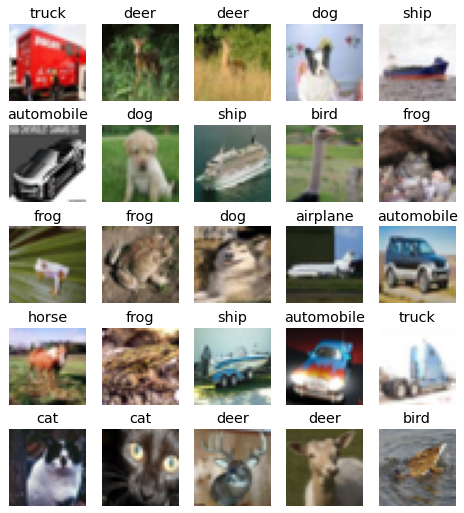

In [ ]:
# pick 25 random images and plot
idxs = np.random.randint(x_trn.shape[0], size=25)
images = x_trn[idxs]
labels = y_trn[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i]
  ax.set_title(classnames[idx])
plt.show()

In [ ]:
class Patches(tf.keras.layers.Layer):
  """Creates patches from an image. Implemented as a keras layer."""
  def __init__(self, patch_size: int):
    super().__init__()
    self.patch_size = patch_size

  def call(self, x):
    batch_size = tf.shape(x)[0]
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

  def get_config(self):
    return {"patch_size": self.patch_size}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


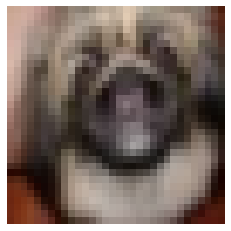

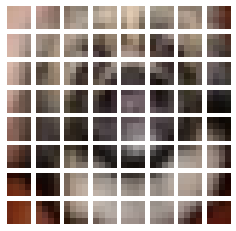

In [ ]:
plt.figure(figsize=(4, 4))
image = x_trn[np.random.choice(range(x_trn.shape[0]))]
plt.imshow(image)
plt.axis("off")

image_size = 32
patch_size = 4

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
def data_generator(split: str, batch_size: int, shuffle_buffer: int = 10000):
  """Creates a tf.data.Dataset instance.

  Args:
      split: The type of data to generate, ['train', 'val', 'test'].
      batch_size: Batch size.
      shuffle_buffer: Number of elements used for shuffling.

  Returns:
      A tf.data.Dataset instance.

  Raises:
      ValueError: If `split` is not ['train', 'val', 'test'].

  """
  if split == 'train':
    ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
    ds = ds.shuffle(shuffle_buffer)
  elif split == 'val':
    ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  elif split == 'test':
    ds = tf.data.Dataset.from_tensor_slices((x_tst, y_tst))
  else:
    raise ValueError(f"Unknown data split : {split}")
  return ds.batch(batch_size)

# Model

##CNN

A simple CNN example from the keras [CNN benchmark](https://github.com/keras-team/keras/blob/master/keras/benchmarks/keras_examples_benchmarks/cifar10_cnn_benchmark_test.py) .  
It is based on this [CNN example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) but the example is no longer available.


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Conv2D, 
  MaxPool2D,
  Dropout,
  Flatten,
  Dense
)
from tensorflow.keras.layers.experimental.preprocessing import (
  RandomFlip,
  RandomTranslation,
  RandomRotation,
  RandomZoom,
  Normalization,
  Rescaling,
  Resizing
)


class SmallCNN(Model):
  """SmallCNN implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               preprocess: bool = False):
    super().__init__()

    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = self.conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = self.conv2d(32, 3, name='conv2')
    self.pool2 = self.maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')
    self.conv3 = self.conv2d(64, 3, name='conv3', padding='same')
    self.conv4 = self.conv2d(64, 3, name='conv4')
    self.pool4 = self.maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')
    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=tf.keras.activations.relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.dens6 = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)
    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)
    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)
    x = self.pool4(self.conv4(self.conv3(x)))
    x = self.drop4(x, training=training)
    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.dens6(x)
    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
    return {"num_classes": self.num_classes,
            "image_height": self.image_height,
            "image_width": self.image_width,
            "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

  @staticmethod
  def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
    return Conv2D(filters, 
                  kernel_size, 
                  strides, 
                  padding=padding, 
                  activation=tf.keras.activations.relu,
                  **kwargs)
  
  @staticmethod
  def maxpool2d(**kwargs):
    return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

##VIT

[Vision Transformer](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al.  
Code taken from this [example](https://keras.io/examples/vision/image_classification_with_vision_transformer/) from the official keras website.

**Good to know points**
*  Multiheadattention is used here. 
*  Self attention is implemented, meaning that the projection_dim is used for the QKV projections and the final projection to get the output.

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Layer,
  Add,
  Conv2D, 
  Dense,
  Dropout,
  Embedding,
  Flatten,
  LayerNormalization,
  MaxPool2D,
  MultiHeadAttention
)
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)


class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self, hidden_units: list, dropout_rate: float):
    super().__init__()
    self.hidden_units = hidden_units
    self.dropout_rate = dropout_rate
    
    self.layers = []
    self.dropouts = []
    for idx, units in enumerate(self.hidden_units):
      self.layers.append(Dense(units, 
                               activation=tf.keras.activations.gelu, 
                               name=f'dens{idx}'))
      self.dropouts.append(Dropout(dropout_rate))

  def call(self, x, training: bool = None):
    for layer_i, dropout_i in zip(self.layers, self.dropouts):
        x = layer_i(x)
        x = dropout_i(x, training=training)
    return x
  
  def get_config(self):
    return {"hidden_units": self.hidden_units,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


def mlp(hidden_units: list, dropout_rate: float, name: str = ''):
  """Multilayer perceptron. 
  
  Same as MLP(...). But this is not a layer, meaning that the layers listed 
  here will be shown separately in model.summary() .

  """
  layers = []
  for idx, units in enumerate(hidden_units):
    layers.append(Dense(units, 
                        activation=tf.keras.activations.gelu, 
                        name=f'{name}/dens{idx}'))
    layers.append(Dropout(dropout_rate, name=f'{name}/drop{idx}'))
  return layers


class PatchEncoder(Layer):
  """Encoder for the image patches."""
  def __init__(self, num_patches: int, projection_dim: int):
    super().__init__()
    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.projection = Dense(units=self.projection_dim)
    self.position_embedding = Embedding(input_dim=num_patches,
                                        output_dim=self.projection_dim)

  def call(self, x):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(x) + self.position_embedding(positions)
    return encoded
  
  def get_config(self):
    return {"num_patches": self.num_patches,
            "projection_dim": self.projection_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class VIT(Model):
  """Vision Transformer implementation.
  
  Changes compared to the original model:
  - maxpool2d uses a kernel_size=3, stride=2.
  
  """
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               patch_size: int, 
               projection_dim: int,
               num_layers: int,
               num_heads: int,
               mlp_dims: list,
               classifier_mlp_dims: list,
               preprocess: bool = False):
    """Constructor.

    Args:
      num_classes: Number of classes.
      image_height: Height of image.
      image_width: Width of image.
      patch_size: SIze of the input patch.
      projection_dim: Dimension of input projection (to transformer) layer.
      num_layers: Number of transformer blocks.
      num_heads: Number of heads in the multiheadattention layers.
      mlp_dims: List of dimensions of the mlp.
      classifier_mlp_dims: List of dimension of the classifier layers.
      preprocess: Whether to do preprocessing or not.
      
    """
    super().__init__()
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.patch_size = patch_size
    self.projection_dim = projection_dim
    self.num_layers = num_layers
    self.num_heads = num_heads
    self.mlp_dims = mlp_dims
    self.classifier_mlp_dims = classifier_mlp_dims
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Patches
    self.patch = Patches(self.patch_size)
    num_patches = (self.image_height // self.patch_size) * \
                  (self.image_width // self.patch_size)
    self.patch_enc = PatchEncoder(num_patches, self.projection_dim)

    # Model
    self.transformer_blocks = []
    for idx in range(self.num_layers):
      block = []
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_1')]
      block += [MultiHeadAttention(self.num_heads, 
                                   self.projection_dim, 
                                   dropout=0.1, 
                                   name=f'mha{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_1')]
      block += [LayerNormalization(epsilon=1e-6, name=f'ln{idx + 1}_2')]
      block += [mlp(mlp_dims, dropout_rate=0.1, name=f'mlp{idx + 1}')]
      block += [Add(name=f'skip{idx + 1}_2')]
      self.transformer_blocks.append(block)

    self.lnorm = LayerNormalization(epsilon=1e-6, name='classifier_ln')
    self.flat = Flatten(name='classifier_flat')
    self.drop = Dropout(0.5, name='classifier_drop')
    self.mlp = mlp(self.classifier_mlp_dims, dropout_rate=0.5, 
                   name='classifier_mlp')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.patch(x)
    x = self.patch_enc(x)
    
    for block in self.transformer_blocks:
      x_layer_norm_1 = block[0](x)
      x_attention    = block[1](x_layer_norm_1, x_layer_norm_1)
      x_skip         = block[2]([x_attention, x])
      x_layer_norm_2 = block[3](x_skip)
      x_mlp          = self._iterate_mlp(block[4], x_layer_norm_2)
      x              = block[5]([x_mlp, x_skip])
    
    x = self.lnorm(x)
    x = self.flat(x)
    x = self.drop(x, training=training)
    x = self._iterate_mlp(self.mlp, x)
    x = self.logits(x)
    return x
  
  @staticmethod
  def _iterate_mlp(mlp_layers: list, x: tf.Tensor):
    _x = x
    for mlp_i in mlp_layers:
      _x = mlp_i(_x)
    return _x

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

##LambdaNetworks

[LambdaNetworks](https://arxiv.org/abs/2102.08602) from Irwan Bello.  

The LambdaNets is based on [tfkeras.py](https://github.com/lucidrains/lambda-networks/blob/main/lambda_networks/tfkeras.py) from [lucidrains/lambda-networks](https://github.com/lucidrains/lambda-networks) and [lambda2d.py](https://github.com/g0lemXIV/LambdaNetworks/blob/main/lambda_layers/lambda2d.py) from [g0lemXIV/LambdaNetworks](https://github.com/g0lemXIV/LambdaNetworks) .  

**Good to know points**
*   The paper main introduces lambdalayer and uses it to replace the convs in ResNet to create LambdaResNet.
*   LambdaResNet achieves high accuracy but is very slow (~7x slower).
*   The main conclusion is that a hybrid model of conv + lambda has the best speed-accuracy tradeoff.
*   The best hybrid model replaces only some blocks in C4 and all the blocks in C5.
*   Unlike the multihead attention in VIT, the final output projection is not included. This means that the V dimension must be divided by the number of heads.



In [ ]:
#! pip install einops
from einops.layers.tensorflow import Rearrange

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  BatchNormalization, 
  Conv2D,
  Conv3D
)
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)
from tensorflow import einsum, meshgrid


def calc_rel_pos(n: int):
  """Generates a relative position meshgrid.
  
  Args:
    n: Size of the original meshgrid. Size = Height = Width.

  Returns: 
    rel_pos: An array of [n*n, n*n, 2] with value range from [-n+1, n-1] to 
             [0, 2n-2].
  """
  # [2, n, n]
  pos = tf.stack(meshgrid(tf.range(n), tf.range(n), indexing = 'ij'))
  # [n*n, 2], pos[n] = (i, j)
  pos = Rearrange('n i j -> (i j) n')(pos)             
  # [n*n, n*n, 2], rel_pos[n, m] = (rel_i, rel_j)
  rel_pos = pos[None, :] - pos[:, None]                
  # shift value range from [-n+1, n-1] to [0, 2n-2]
  rel_pos += n - 1
  # [n*n, n*n, 2]                      
  return rel_pos


class Lambda(Layer):
  """Lambda Networks implementation."""

  def __init__(self,
               output_dim: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               batch_norm: bool = True,
               **kwargs):
    """Constructor

    Args:
      output_dim: Output dimension of the layer or v_dim * `num_heads`.
      k_dim: Dimension of key.
      u_dim: Intra depth for multiquery heads.
      num_heads: Number of heads for multiquery.
      n_r_size: If `local_contexts=True` n = height*width of query,
                else r = receptive field.
      local_contexts: If True lambdaconv is used, 
                      else relative position embeddings are used.
      batch_norm: Whether to apply batch norm to query and value after
                  the linear projection.

    """
    super().__init__(**kwargs)

    self.output_dim = output_dim
    self.u_dim = u_dim  # intra-depth dimension
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.batch_norm = batch_norm

    assert (self.output_dim % self.num_heads) == 0, \
      '`output_dim` must be divisible by `num_heads` for multi-head query.'
    self.v_dim = self.output_dim // self.num_heads
    self.k_dim = k_dim
    self.num_heads = num_heads

    self.to_q = Conv2D(self.k_dim * self.num_heads, 1, use_bias=self.batch_norm)
    self.to_k = Conv2D(self.k_dim * self.u_dim, 1, use_bias=self.batch_norm)
    self.to_v = Conv2D(self.v_dim * self.u_dim, 1, use_bias=self.batch_norm)

    self.norm_q = BatchNormalization() if self.batch_norm else None
    self.norm_v = BatchNormalization() if self.batch_norm else None

    if self.local_contexts:
      assert (self.n_r_size % 2) == 1, 'Receptive kernel size should be odd'
      self.pos_conv = Conv3D(self.k_dim, 
                             (1, self.n_r_size, self.n_r_size), 
                             padding='same')
    else:
      assert n is not None, 'You must specify the window length (n = h = w)'
      rel_length = 2 * self.n_r_size - 1
      self.rel_pos_emb = self.add_weight(
        name='pos_emb',
        shape=(rel_length, rel_length, self.k_dim, self.u_dim),
        initializer=tf.keras.initializers.RandomNormal,
        trainable=True
      )
      self.rel_pos = calc_rel_pos(self.n_r_size)

  def call(self, x):
    """
    Info on the notations for reference:
    x = 2D Image data (Assumption)
    q = query
    k = key
    v = value
    h = number of heads for multiquery
    u = intradepth
    b = batch size
    hh = height of input data
    ww = width of input data
    m = height * width of key / value.
    n = height * width of query.
    """
    b, hh, ww, c, u, h = *x.get_shape().as_list(), self.u_dim, self.num_heads

    q = self.to_q(x)
    k = self.to_k(x)
    v = self.to_v(x)

    if self.batch_norm:
      q = self.norm_q(q)
      v = self.norm_v(v)

    q = Rearrange('b hh ww (h k) -> b h k (hh ww)', h=h)(q)
    k = Rearrange('b hh ww (u k) -> b u k (hh ww)', u=u)(k)
    v = Rearrange('b hh ww (u v) -> b u v (hh ww)', u=u)(v)

    k = tf.nn.softmax(k)

    Lc = einsum('b u k m, b u v m -> b k v', k, v)
    Yc = einsum('b h k n, b k v -> b n h v', q, Lc)

    if self.local_contexts:
      # lambda convs, embedding is represented by the conv kernels.
      v = Rearrange('b u v (hh ww) -> b v hh ww u', hh=hh, ww=ww)(v)
      Lp = self.pos_conv(v)
      Lp = Rearrange('b v h w k -> b v k (h w)')(Lp)
      Yp = einsum('b h k n, b v k n -> b n h v', q, Lp)
    else:
      # relative position embedding.
      rel_pos_emb = tf.gather_nd(self.rel_pos_emb, self.rel_pos)
      Lp = einsum('n m k u, b u v m -> b n k v', rel_pos_emb, v)
      Yp = einsum('b h k n, b n k v -> b n h v', q, Lp)

    Y = Yc + Yp
    out = Rearrange('b (hh ww) h v -> b hh ww (h v)', hh = hh, ww = ww)(Y)
    return out

  def get_config(self):
    return {"output_dim": self.output_dim,
            "k_dim": self.k_dim,
            "u_dim": self.u_dim,
            "num_heads": self.num_heads,
            "n_r_size": self.n_r_size,
            "local_contexts": self.local_contexts,
            "batch_norm": self.batch_norm}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class LambdaNetwork(Model):
  """LambdaNetworks implementation. """
  
  def __init__(self, 
               num_classes: int, 
               image_height: int, 
               image_width: int,
               k_dim: int = 16,
               u_dim: int = 1,
               num_heads: int = 4,
               n_r_size: int = None,
               local_contexts: bool = False,
               preprocess: bool = False,
               **kwargs):
    """Constructor.

    Args:
      num_classes: Number of classes.
      image_height: Height of image.
      image_width: Width of image.
      k_dim: Dimension of key.
      u_dim: Intra depth for multiquery heads.
      num_heads: Number of heads for multiquery.
      n_r_size: If `local_contexts=True` n = height*width of query,
                else r = receptive field.
      local_contexts: If True lambdaconv is used, 
                      else relative position embeddings are used.
      preprocess: Whether to do preprocessing or not.
      
    """
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.k_dim = k_dim
    self.u_dim = u_dim
    self.num_heads = num_heads
    self.n_r_size = n_r_size
    self.local_contexts = local_contexts
    self.preprocess = preprocess

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model
    self.conv1 = self.conv2d(32, 3, name='conv1', padding='same')
    self.conv2 = self.conv2d(32, 3, name='conv2')
    self.pool2 = self.maxpool2d(name='pool1')
    self.drop2 = Dropout(0.5, name='drop2')

    # self.lamb3 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    # self.lamb4 = Lambda(64, k_dim=8, u_dim=1, num_heads=2, n_r_size=14, 
    #                     local_contexts=False, batch_norm=False)
    self.lamb3 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb3')
    self.lamb4 = Lambda(64, k_dim=self.k_dim, u_dim=self.u_dim, 
                        num_heads=self.num_heads, n_r_size=self.n_r_size, 
                        local_contexts=self.local_contexts, batch_norm=False,
                        name='lamb4')
    self.pool4 = self.maxpool2d(name='pool4')
    self.drop4 = Dropout(0.25, name='drop4')

    self.flat5 = Flatten(name='flat5')
    self.dens5 = Dense(512, activation=tf.keras.activations.relu, name='dens5')
    self.drop5 = Dropout(0.5, name='drop5')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    x = self.pool2(self.conv2(self.conv1(x)))
    x = self.drop2(x, training=training)

    x = self.pool4(self.lamb4(self.lamb3(x)))
    x = self.drop4(x, training=training)

    x = self.dens5(self.flat5(x))
    x = self.drop5(x, training=training)
    x = self.logits(x)

    return x
  
  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes": self.num_classes,
              "image_height": self.image_height,
              "image_width": self.image_width,
              "patch_size": self.patch_size,
              "projection_dim": self.projection_dim,
              "num_layers": self.num_layers,
              "num_heads": self.num_heads,
              "mlp_dims": self.mlp_dims,
              "classifier_mlp_dims": self.classifier_mlp_dims,
              "preprocess": self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)
  
  @staticmethod
  def conv2d(filters, kernel_size, strides=(1, 1), padding='valid', **kwargs):
    return Conv2D(filters, 
                  kernel_size, 
                  strides, 
                  padding=padding, 
                  activation=tf.keras.activations.relu,
                  **kwargs)
    
  @staticmethod
  def maxpool2d(**kwargs):
    return MaxPool2D([3, 3], 2, padding='valid', **kwargs)

##Perceiver

[Perceiver](https://arxiv.org/abs/2103.03206) from Jaegle et. al. .

The code is based on [perceiver_pytorch.py](https://github.com/lucidrains/perceiver-pytorch/blob/main/perceiver_pytorch/perceiver_pytorch.py) from [lucidrains/perceiver_pytorch](https://github.com/lucidrains/perceiver_pytorch) .  

**Good to know points from the paper**
*  Linear layers are implemented using Dense. In paper it is implied that 1x1 conv was used.
* 
* 




In [ ]:
#! pip install einops
from einops.layers.tensorflow import Rearrange
from einops import repeat
from datetime import datetime

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
  Add,
  AveragePooling1D,
  BatchNormalization, 
  Conv2D,
  Conv3D,
  Dense,
  Dropout,
  Embedding,
  Layer,
  LayerNormalization,
  MultiHeadAttention
)
from tensorflow.keras.layers.experimental.preprocessing import (
  Normalization,
  RandomFlip,
  RandomRotation,
  RandomZoom,
  Rescaling,
  Resizing,
)
from tensorflow import einsum, meshgrid

from functools import wraps
from math import pi


def cache_fn(func):
    cache = None
    @wraps(func)
    def cached_func(*args, _cache=False, **kwargs):
        if not _cache:
            return func(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = func(*args, **kwargs)
        return cache
    return cached_func


def fourier_encode(x: tf.Tensor, 
                   max_freq: float, 
                   num_bands: int = 4, 
                   base: float = 2.0) -> tf.Tensor:
  """Positional fourier encoding."""
  x = tf.expand_dims(x, -1)
  dtype, orig_x = x.dtype, x
  scales = tf.experimental.numpy.logspace(
    start=0., 
    stop=tf.math.log(max_freq / 2) / tf.math.log(base), 
    num=num_bands, 
    base = base, 
    dtype = dtype)
  scales = Rearrange('s -> () () () s')(scales)
  # x = [h,w,2,bands]
  x = x * scales * pi
  x = tf.concat([tf.math.sin(x), tf.math.cos(x), orig_x], axis=-1)
  return x


class InputByteArray(Layer):
  """Prepares input byte array for K, V."""

  def __init__(self,
               image_height: int = None, 
               image_width: int = None,
               batch_size: int = None, 
               max_freq: float = 224,
               num_freq_bands: int = 64,
               freq_base = 2.0,
               **kwargs):
    """Constructor"""
    super().__init__(**kwargs)
    self.max_freq = max_freq
    self.num_freq_bands = num_freq_bands
    self.freq_base = freq_base
    self.batch_size = batch_size
    self.image_height = image_height
    self.image_width = image_width

  @cache_fn
  def positional_encoding(self, x):
    x_shape = x.get_shape().as_list()
    assert len(x_shape) == 4, 'input data must have dim of 4'
    # 1. calculate fourier encoded positions in the range of [-1, 1]
    axis_pos = list(map(lambda num: tf.linspace(-1., 1., num), x_shape[1:3]))
    pos = tf.stack(meshgrid(*axis_pos), axis=-1)
    enc_pos = fourier_encode(pos, 
                             max_freq=self.max_freq, 
                             num_bands=self.num_freq_bands, 
                             base=self.freq_base)
    # 2. Merge the stacked dimension
    enc_pos = Rearrange('... n d -> ... (n d)')(enc_pos)
    # 3. Tile to the batch size
    # enc_pos = repeat(enc_pos, '... -> b ...', b=x_shape[0])
    enc_pos = tf.tile(tf.expand_dims(enc_pos, axis=0), 
                      [tf.shape(x)[0], 1, 1, 1], 
                      name='enc_pos')
    return enc_pos

  def call(self, x):
    # x_shape = x.get_shape().as_list()
    # assert len(x_shape) == 4, 'input data must have dim of 4'
    # # 1. calculate fourier encoded positions in the range of [-1, 1]
    # axis_pos = list(map(lambda num: tf.linspace(-1., 1., num), x_shape[1:3]))
    # pos = tf.stack(meshgrid(*axis_pos), axis=-1)
    # enc_pos = fourier_encode(pos, 
    #                          max_freq=self.max_freq, 
    #                          num_bands=self.num_freq_bands, 
    #                          base=self.freq_base)
    # # 2. Merge the stacked dimension
    # enc_pos = Rearrange('... n d -> ... (n d)')(enc_pos)
    # # 3. Tile to the batch size
    # # enc_pos = repeat(enc_pos, '... -> b ...', b=x_shape[0])
    # enc_pos = tf.tile(tf.expand_dims(enc_pos, axis=0), 
    #                   [tf.shape(x)[0], 1, 1, 1], 
    #                   name='enc_pos')
    # 4. concat to channels of data and flatten axis
    _cache = self.batch_size and self.image_height and self.image_width
    enc_pos = self.positional_encoding(x, _cache=_cache)
    x = tf.concat([x, enc_pos], axis=-1, name='data_input')
    x = Rearrange('b ... d -> b (...) d')(x)
    return x

  def get_config(self):
    return {'batch_size': self.batch_size,
            'image_height': self.image_height,
            'image_width': self.image_width,
            'max_freq': self.max_freq,
            'num_freq_bands': self.num_freq_bands,
            'freq_base': self.freq_base}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class InputLatentArray(Layer):
  """Prepares latent byte array for Q."""

  def __init__(self, num_latents: int = 1024, latent_dim: int = 512, **kwargs):
    """Constructor"""
    super().__init__(**kwargs)
    self.num_latents = num_latents
    self.latent_dim = latent_dim
    self.latents = self.add_weight('latent', 
                                   [self.num_latents, self.latent_dim],
                                   tf.float32,
                                   trainable=True)

  def call(self, x):
    x_shape = x.get_shape().as_list()
    assert len(x_shape) == 4, 'input data must have dim of 4'
    # z = repeat(self.latents, 'n d -> b n d', b=x_shape[0])
    z = tf.tile(tf.expand_dims(self.latents, axis=0), 
                [tf.shape(x)[0], 1, 1], 
                name='latent_input')
    return z

  def get_config(self):
    return {'num_latents': self.num_latents,
            'latent_dim': self.latent_dim}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class GELU(Layer):
  """GELU with gated linear unit option."""

  def __init__(self, glu: bool = True, **kwargs):
    """Constructor"""
    super().__init__(**kwargs)
    self.glu = glu
    self.gelu = tf.keras.layers.Activation('gelu')

  def call(self, x):
    if self.glu:
      return self.gelu(x)
    else:
      x_input, x_gates = tf.split(x, 2, axis=-1)
      return x_input * self.gelu(x_gates)

  def get_config(self):
    return {'glu': self.glu}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class MLP(Layer):
  """Multilayer perceptron."""
  def __init__(self,
               latent_dims: list,
               geglu: bool = True, 
               dropout_rate: float = 0.25, 
               **kwargs):
    super().__init__(**kwargs)
    self.latent_dims = latent_dims
    self.geglu = geglu
    self.dropout_rate = dropout_rate
    self.lrn   = LayerNormalization(epsilon=1e-6, name='ln')
    self.dens1 = Dense(latent_dims[0], name='dens1', use_bias=False)
    self.gelu  = GELU(geglu, name=f'{"geglu" if geglu else "gelu"}')
    self.dens2 = Dense(latent_dims[1], name='dens2')
    self.drop  = Dropout(dropout_rate, name='drop')

  def call(self, x, training: bool = None):
    x = self.lrn(x)
    x = self.dens1(x)
    x = self.gelu(x)
    x = self.dens2(x)
    x = self.drop(x)
    return x
  
  def get_config(self):
    return {"latent_dims": self.latent_dims,
            "geglu": self.geglu,
            "dropout_rate": self.dropout_rate}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


def mlp(latent_dims: list,
        geglu: bool = True, 
        dropout_rate: float = 0.25, 
        name: str = '') -> list:
  """Multilayer perceptron.
  
  Same as MLP(...). But this is not a layer, meaning that the layers listed 
  here will be shown separately in model.summary() .
  """
  assert len(latent_dims) == 2, "Length of `latent_dims` must be 2."
  layers = []  
  layers.append(LayerNormalization(epsilon=1e-6, name=f'{name}/ln{idx}'))
  layers.append(Dense(latent_dims[0], name=f'{name}/dens1'))
  layers.append(GELU(geglu, name=f'{name}/{"geglu" if geglu else "gelu"}'))
  layers.append(Dense(latent_dims[1], name=f'{name}/dens2'))
  layers.append(Dropout(dropout_rate, name=f'{name}/drop'))
  return layers


class Transformer(Layer):
  """Transformer module for cross attention or self attention.
  
  This is different than the `MultiHeadAttention` (MHA) layer. MHA shares the 
  same Q and K dimensions whereas this layer shares the K and V dimensions.
  """

  def __init__(self, 
               query_dim: int, 
               use_context: bool = False, 
               num_heads: int = 8, 
               dim_head: int = 64, 
               dropout: float = 0.25,
               **kwargs):
    """Constructor.

    Args:
      query_dim: Dimension of Query.
      use_context: Whether context (Key, Value) is used.
      num_heads: Number of heads.
      dim_head: Dimension per head.
      dropout: Dropout rate.
      
    """
    super().__init__(**kwargs)
    self.query_dim = query_dim
    self.num_heads = num_heads
    self.dim_head = dim_head
    self.dropout = dropout
    self.use_context = use_context

    self.lrn = LayerNormalization(epsilon=1e-6, name='ln')

    if self.use_context:
      self.lrn_ctxt = LayerNormalization(epsilon=1e-6, name='ln_ctxt')
    else:
      self.lrn_ctxt = None

    # Reference : VIT paper appendix.
    self.scale = dim_head ** -0.5

    inner_dim = self.dim_head * self.num_heads

    self.to_q  = Dense(inner_dim, use_bias=False)
    self.to_kv = Dense(inner_dim * 2, use_bias=False)

    self.dens  = Dense(self.query_dim, name='dens')
    # self.drop1 = Dropout(self.dropout, name='drop1')
    self.drop2 = Dropout(self.dropout, name='drop2')

  def call(self, x: tf.Tensor, context: tf.Tensor = None):
    """
    Args:
      x: Latent data.
      context: Input data.

    """
    x = self.lrn(x)
    q = self.to_q(x)

    if context is not None:
      assert self.lrn_ctxt, '`self.lrn_ctxt` is False.'
      context = self.lrn_ctxt(context)
      kv = self.to_kv(context)
    else:
      kv = self.to_kv(x)

    k, v = tf.split(kv, 2, axis=-1)

    q = Rearrange('b n (h d) -> (b h) n d', h=self.num_heads)(q)
    k = Rearrange('b n (h d) -> (b h) n d', h=self.num_heads)(k)
    v = Rearrange('b n (h d) -> (b h) n d', h=self.num_heads)(v)

    sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
    attn = tf.math.softmax(sim, axis=-1)
    # attn = self.drop1(attn)

    x = einsum('b i j, b j d -> b i d', attn, v)
    x = Rearrange('(b h) n d -> b n (h d)', h=self.num_heads)(x)

    x = self.dens(x)
    x = self.drop2(x)

    return x

  def get_config(self):
    return {'query_dim'  : self.query_dim  ,
            'use_context': self.use_context,
            'num_heads'  : self.num_heads  ,
            'dim_head'   : self.dim_head   ,
            'dropout'    : self.dropout    }

  @classmethod
  def from_config(cls, config):
    return cls(**config)


class Perceiver(Model):
  """Perceiver implementation. """
  
  def __init__(self,
               num_classes: int, 
               image_height: int, 
               image_width: int,
               batch_size: int = None,
               max_freq: float = 224,
               num_freq_bands: int = 64,
               freq_base: float = 2.0,
               num_latents: int = 1024,
               latent_dim: int = 512,
               latent_heads: int = 8,
               latent_head_dim: int = 512,
               cross_heads: int = 1,
               cross_head_dim: int = 512,
               attn_dropout: float = 0.2,
               mlp_dropout: float = 0.2,
               cross_depth: int = 8,
               latent_depth: int = 6,             
               weight_tie_layers: bool = False,
               preprocess: bool = False,
               **kwargs):
    """Constructor.

    Args:
      num_classes: Number of classes.
      image_height: Height of image.
      image_width: Width of image.
      max_freq:locked_drop_o
      num_freq_bands:
      freq_base:
      num_latents:
      latent_dim:
      latent_heads:
      latent_head_dim:
      cross_heads:
      cross_head_dim:
      attn_dropout:
      mlp_dropout:
      cross_depth:
      latent_depth:
      weight_tie_layers:
      preprocess: Whether to do preprocessing or not.
      
    """
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.image_height = image_height
    self.image_width = image_width
    self.preprocess = preprocess
    self.batch_size = batch_size

    # Position encoding
    self.max_freq = max_freq
    self.num_freq_bands = num_freq_bands
    self.freq_base = freq_base

    # Latent transformer
    self.num_latents = num_latents
    self.latent_dim = latent_dim
    self.latent_heads = latent_heads
    self.latent_head_dim = latent_head_dim

    # Cross attention
    self.cross_heads = cross_heads
    self.cross_head_dim = cross_head_dim

    self.attn_dropout = attn_dropout
    self.mlp_dropout = mlp_dropout

    # How many latent transformer repeats and how many input data attends.
    self.cross_depth = cross_depth
    self.latent_depth = latent_depth
    self.weight_tie_layers = weight_tie_layers

    self.rescale = Rescaling(1./255., name='rescale')
    self.resize = Resizing(self.image_height, self.image_width, name='resize')

    # Preprocessing ------------------------------------------------------------
    self.augs = [
      RandomFlip("horizontal", name='data_aug_flip'),
      # RandomTranslation((-0.1, 0.1), (-0.1, 0.1), name='data_aug2'),
      RandomRotation(0.02, name='data_aug_rot'),
      RandomZoom(0.2, 0.2, name='data_aug_zoom'),
    ]

    # Model --------------------------------------------------------------------
    # data array for key and value.
    self.input_data = InputByteArray(batch_size=self.batch_size,
                                     image_height=self.image_height,
                                     image_width=self.image_width,
                                     max_freq=self.max_freq, 
                                     num_freq_bands=self.num_freq_bands, 
                                     freq_base=self.freq_base,
                                     name='input_data')
    
    # latent array for query.
    self.input_latent = InputLatentArray(num_latents=self.num_latents, 
                                         latent_dim=self.latent_dim, 
                                         name='input_latent')
    
    # context refers to the input data array.
    input_axis, input_channels = 2, 3
    # self.context_dim = input_axis * ((self.num_freq_bands * 2) + 1) + input_channels

    # cross attention module.
    cross_attn  = self.get_cross_attn()
    cross_mlp   = self.get_cross_mlp()

    # latent attention module. 
    # We do not want to share the weights within a module.
    latent_attn = [self.get_latent_attn() for _ in range(self.latent_depth)]
    latent_mlp  = [self.get_latent_mlp() for _ in range(self.latent_depth)]

    # stack modules to form Perceiver.
    self.blocks = []
    for i in range(self.cross_depth):
      cache_args = {'_cache': i > 0 and self.weight_tie_layers}
      cross_attn_i = cross_attn(cross_idx=i, **cache_args)
      cross_mlp_i  = cross_mlp(cross_idx=i)
      self.blocks.append((cross_attn_i, f'cross_attn_{i}'))
      self.blocks.append((cross_mlp_i,  f'cross_mlp_{i}' ))
      for j in range(self.latent_depth):
        latent_attn_j = latent_attn[j](cross_idx=i, latent_idx=j, **cache_args)
        latent_mlp_j  = latent_mlp[j](cross_idx=i, latent_idx=j)
        self.blocks.append((latent_attn_j, f'latent_attn_{i}_{j}'))
        self.blocks.append((latent_mlp_j,  f'latent_mlp_{i}_{j}'))

    self.avgpool = AveragePooling1D(pool_size=self.num_latents, name='avgpool')
    self.lrn = LayerNormalization(epsilon=1e-6, name='ln')
    self.logits = Dense(self.num_classes, name='logits')

  def call(self, x, training: bool = None):
    x = self.rescale(x)
    x = self.resize(x)

    if self.preprocess:
      for aug_i in self.augs:
        x = aug_i(x, training=training)

    z = self.input_latent(x)
    x = self.input_data(x)

    for l in self.blocks:
      if 'cross_attn' in l[1]:
        z = Add(name='skip_' + l[1])([l[0](z, context=x), z])
      else:
        z = Add(name='skip_' + l[1])([l[0](z), z])

    z = self.avgpool(z)
    # z = self.lrn(z)
    z = self.logits(z)

    return z
  
  def get_cross_attn(self):
    """Transformer of the cross attention module.
    Returns a function that can be cached, enabling weight sharing.
    """
    @cache_fn
    def cross_attn(cross_idx: int = 0):
      return Transformer(query_dim=self.latent_dim, 
                         use_context=True, 
                         num_heads=self.cross_heads, 
                         dim_head=self.cross_head_dim, 
                         dropout=self.attn_dropout, 
                         name=f'cross_attn_{cross_idx}')
    return cross_attn
    
  def get_cross_mlp(self):
    """MLP of the cross attention module. 
    Returns a function that can be cached, enabling weight sharing.    
    """
    @cache_fn
    def cross_mlp(cross_idx: int = 0):
      return MLP(latent_dims=[self.latent_dim, self.latent_dim],
                 geglu=True,
                 dropout_rate=self.mlp_dropout,
                 name=f'cross_mlp_{cross_idx}')
    return cross_mlp

  def get_latent_attn(self):
    """Transformer of the latent attention module.
    Returns a function that can be cached, enabling weight sharing.
    """
    @cache_fn
    def latent_attn(cross_idx: int = 0, latent_idx: int = 0):
      return Transformer(query_dim=self.latent_dim, 
                         use_context=False, 
                         num_heads=self.latent_heads, 
                         dim_head=self.latent_head_dim, 
                         dropout=self.attn_dropout, 
                         name=f'latent_attn_{cross_idx}_{latent_idx}')
    return latent_attn
  
  def get_latent_mlp(self):
    """MLP of the latent attention module. 
    Returns a function that can be cached, enabling weight sharing.    
    """
    @cache_fn      
    def latent_mlp(cross_idx: int = 0, latent_idx: int = 0):
      return MLP(latent_dims=[self.latent_dim, self.latent_dim],
                 geglu=True,
                 dropout_rate=self.mlp_dropout,
                 name=f'latent_mlp_{cross_idx}_{latent_idx}')
    return latent_mlp

  # https://stackoverflow.com/questions/55235212
  def model(self, input_shape=None):
    if input_shape is None:
      x = Input(shape=(self.image_height, self.image_width, 3))
    else:
      x = Input(shape=input_shape)
    return Model(inputs=[x], outputs=self.call(x))
  
  def get_config(self):
      return {"num_classes"       : self.num_classes,
              "image_height"      : self.image_height,
              "image_width"       : self.image_width,
              "batch_size"        : self.batch_size,
              "max_freq"          : self.max_freq,
              "num_freq_bands"    : self.num_freq_bands,
              "freq_base"         : self.freq_base,
              "num_latents"       : self.num_latents,
              "latent_dim"        : self.latent_dim,
              "latent_heads"      : self.latent_heads,
              "latent_head_dim"   : self.latent_head_dim,
              "cross_heads"       : self.cross_heads,
              "cross_head_dim"    : self.cross_head_dim,
              "attn_dropout"      : self.attn_dropout,
              "mlp_dropout"       : self.mlp_dropout,
              "cross_depth"       : self.cross_depth,
              "latent_depth"      : self.latent_depth,
              "weight_tie_layers" : self.weight_tie_layers,
              "preprocess"        : self.preprocess}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [ ]:
model = Perceiver(num_classes=1000, 
                  image_height=224, 
                  image_width=224,
                  max_freq=224,
                  num_freq_bands=64,
                  freq_base=2.0,
                  num_latents=1024,
                  latent_dim=512,
                  latent_heads=8,
                  latent_head_dim=512//8,
                  cross_heads=1,
                  cross_head_dim=512,
                  attn_dropout=0.2,
                  mlp_dropout=0.2,
                  cross_depth=8,
                  latent_depth=6,             
                  weight_tie_layers=True,
                  preprocess=False).model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 224, 224, 3)  0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 1024, 512)    524288      resize[0][0]                     
______________________________________________________________________________________________

# Train

Training configs.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy
batch_size = 256
shuffle_buffer = 50000
epochs = 50
learning_rate = 1e-3

num_classes = 10 
image_height = 32
image_width = 32

Keras model.compile(...) and model.fit(...) .


In [ ]:
def train_and_eval(_model, checkpoint_dir=None, history_dir=None, verbose=1):
  """Wrapper code for training and evaluating.

  Args:
      _model: A keras Model.
      checkpoint_dir: Path to save a checkpoint.
      history_dir: Path to save a history.
      verbose: Option for logging output during train and eval.

  Returns:
      A history instance that contains logged values per epoch.

  """
  steps_per_epoch = len(data_generator('train', batch_size, shuffle_buffer))

  _model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=[acc_metric_fn(name='sparse_categorical_accuracy')]
  )

  if checkpoint_dir is not None:
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_dir,
      monitor="val_sparse_categorical_accuracy",
      save_best_only=True,
    )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=os.path.join(checkpoint_dir, 'logs'), 
      histogram_freq=epochs//10,
      update_freq=(steps_per_epoch // batch_size +
                   (steps_per_epoch % batch_size > 0)) * 5
    )
    callbacks=[tensorboard_callback, checkpoint_callback]
  else:
    callbacks = None

  start = time()
  history = _model.fit(
      data_generator('train', batch_size, shuffle_buffer), 
      epochs=epochs, 
      steps_per_epoch=steps_per_epoch,
      validation_data=data_generator('val', batch_size),
      callbacks=callbacks,
      verbose=verbose
  )
  end = time()
  print(f'Total training time {end - start} seconds')
  
  if history_dir is not None:
    # Save history output, should be the same as the tensorboard logs.
    np.save(os.path.join(history_dir, 'history.npy'), history.history)
  
  return history

# Loss and accuracy plots

In [ ]:
def plot(losses: list, 
         accuracies: list, 
         legend_labels: list, 
         subplot_title: list):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  
  for x, ll in zip(losses, legend_labels):
    c = ax1.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax1.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  ax1.legend()   

  for x, ll in zip(accuracies, legend_labels):
    c = ax2.plot(x[0], label='Trn: ' + ll, linestyle='--')[0].get_c()
    _ = ax2.plot(x[1], label='Val: ' + ll, linestyle='-', color=c)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
  ax2.legend()   

  plt.show()

#Experiments

In [ ]:
history = dict()

##Exp 1
Model : CNN  
Preprocessing : False  
Batch size : 256

---
Trainable params: 890,410  
Total training time 251.87630558013916 seconds


In [ ]:
# model = SmallCNN(num_classes=num_classes, 
#                  image_height=image_height, 
#                  image_width=image_width,
#                  preprocess=False).model()
# model.summary()
# history['CNN'] = train_and_eval(model, SAVE_PATH + '_CNN', verbose=2)

##Exp 2
Model : VIT  
Preprocessing : False  
Batch size : 256  
Patch : 4x4  
Heads : 2

---
Trainable params: 1,108,842  
Total training time 574.3961868286133 seconds


In [ ]:
# # Saves a full copy of the model.
# model = VIT(num_classes=num_classes, 
#             image_height=image_height, 
#             image_width=image_width,
#             patch_size=4, 
#             projection_dim=32,
#             num_layers=4,
#             num_heads=2,
#             mlp_dims=[64, 32],
#             classifier_mlp_dims=[512],
#             preprocess=False).model()
# model.summary()
# history['VIT'] = train_and_eval(model, SAVE_PATH + '_VIT_4x4_2hds', verbose=2)

##Exp 3
Model : LAMBDA  
Preprocessing : False  
Batch size : 256  
Key dim : 2  
u dim : 8  
Heads : 2  
Pos. emb. size : 14  
LambdaConv : False  

---
<pre>
Q = k * hd       =   4
K = k * u        =  16
V = 64 // hd * u = 256
</pre>

---
Trainable params: 1,245,258  
Total training time 729.7639191150665 seconds



In [ ]:
# for hds in [2]:
#   for u_dim in [8]:
#     for k_dim in [2]:
#       model = LambdaNetwork(num_classes=num_classes, 
#                             image_height=image_height, 
#                             image_width=image_width,
#                             k_dim=k_dim,
#                             u_dim=u_dim,
#                             num_heads=hds,
#                             n_r_size=14,
#                             local_contexts=False,
#                             preprocess=False).model()
#       model.summary()
#       if 'LAMBDA' not in history:
#         history['LAMBDA'] = dict()
#       if hds not in history['LAMBDA']:
#         history['LAMBDA'][hds] = dict()
#       if u_dim not in history['LAMBDA'][hds]:
#         history['LAMBDA'][hds][u_dim] = dict()
#       history['LAMBDA'][hds][u_dim][k_dim]= train_and_eval(model, SAVE_PATH + f'_LAMBDA_{k_dim}kdim_{u_dim}udim_{hds}hds', verbose=2)

##Exp 1a-Freq
Model : PERCEIVER  
Preprocessing   : False  
Batch size      : 256  
max_freq        : 4  
num_freq_bands  : 4  
freq_base       : 2.0  
num_latents     : 4  
latent_dim      : 16  
latent_heads    : 1  
latent_head_dim : 16  
cross_heads     : 1  
cross_head_dim  : 16  
cross_depth     : 2  
latent_depth    : 4     

---

In [ ]:
model = Perceiver(num_classes=num_classes, 
                  image_height=image_height, 
                  image_width=image_width,
                  max_freq=4,
                  num_freq_bands=4,
                  freq_base=2.0,
                  num_latents=4,
                  latent_dim=16,
                  latent_heads=1,
                  latent_head_dim=16,
                  cross_heads=1,
                  cross_head_dim=16,
                  attn_dropout=0.2,
                  mlp_dropout=0.2,
                  cross_depth=2,
                  latent_depth=4,             
                  weight_tie_layers=True,
                  preprocess=False).model()
model.summary()
train_and_eval(model, SAVE_PATH + '_PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld', verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 4, 16)        64          resize[0][0]                     
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 9s 45ms/step - loss: 2.0719 - sparse_categorical_accuracy: 0.2113 - val_loss: 1.9792 - val_sparse_categorical_accuracy: 0.2507


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 9s 45ms/step - loss: 1.9894 - sparse_categorical_accuracy: 0.2519 - val_loss: 1.9186 - val_sparse_categorical_accuracy: 0.2871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 9s 45ms/step - loss: 1.9480 - sparse_categorical_accuracy: 0.2723 - val_loss: 1.8822 - val_sparse_categorical_accuracy: 0.3069


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 9s 46ms/step - loss: 1.9191 - sparse_categorical_accuracy: 0.2928 - val_loss: 1.8574 - val_sparse_categorical_accuracy: 0.3215


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8840 - sparse_categorical_accuracy: 0.3060 - val_loss: 1.8331 - val_sparse_categorical_accuracy: 0.3246


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8715 - sparse_categorical_accuracy: 0.3101 - val_loss: 1.7940 - val_sparse_categorical_accuracy: 0.3417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8463 - sparse_categorical_accuracy: 0.3249 - val_loss: 1.7801 - val_sparse_categorical_accuracy: 0.3539


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8347 - sparse_categorical_accuracy: 0.3326 - val_loss: 1.7632 - val_sparse_categorical_accuracy: 0.3599


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8078 - sparse_categorical_accuracy: 0.3391 - val_loss: 1.7512 - val_sparse_categorical_accuracy: 0.3611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8038 - sparse_categorical_accuracy: 0.3395 - val_loss: 1.7437 - val_sparse_categorical_accuracy: 0.3686


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7996 - sparse_categorical_accuracy: 0.3451 - val_loss: 1.7384 - val_sparse_categorical_accuracy: 0.3690


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7808 - sparse_categorical_accuracy: 0.3514 - val_loss: 1.7293 - val_sparse_categorical_accuracy: 0.3748


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7885 - sparse_categorical_accuracy: 0.3423 - val_loss: 1.7196 - val_sparse_categorical_accuracy: 0.3725
Epoch 15/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7749 - sparse_categorical_accuracy: 0.3559 - val_loss: 1.7176 - val_sparse_categorical_accuracy: 0.3757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7721 - sparse_categorical_accuracy: 0.3501 - val_loss: 1.7098 - val_sparse_categorical_accuracy: 0.3777


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7619 - sparse_categorical_accuracy: 0.3554 - val_loss: 1.7154 - val_sparse_categorical_accuracy: 0.3809


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7698 - sparse_categorical_accuracy: 0.3557 - val_loss: 1.6954 - val_sparse_categorical_accuracy: 0.3846


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7570 - sparse_categorical_accuracy: 0.3593 - val_loss: 1.6884 - val_sparse_categorical_accuracy: 0.3847


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7449 - sparse_categorical_accuracy: 0.3591 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.3831
Epoch 21/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7414 - sparse_categorical_accuracy: 0.3618 - val_loss: 1.6766 - val_sparse_categorical_accuracy: 0.3919


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7422 - sparse_categorical_accuracy: 0.3630 - val_loss: 1.6780 - val_sparse_categorical_accuracy: 0.3926


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7384 - sparse_categorical_accuracy: 0.3648 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.3837
Epoch 24/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7297 - sparse_categorical_accuracy: 0.3679 - val_loss: 1.6615 - val_sparse_categorical_accuracy: 0.3982


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7206 - sparse_categorical_accuracy: 0.3727 - val_loss: 1.6728 - val_sparse_categorical_accuracy: 0.3946
Epoch 26/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7238 - sparse_categorical_accuracy: 0.3680 - val_loss: 1.6585 - val_sparse_categorical_accuracy: 0.3949
Epoch 27/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7123 - sparse_categorical_accuracy: 0.3742 - val_loss: 1.6486 - val_sparse_categorical_accuracy: 0.4012


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 28/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7090 - sparse_categorical_accuracy: 0.3790 - val_loss: 1.6362 - val_sparse_categorical_accuracy: 0.4079


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7014 - sparse_categorical_accuracy: 0.3783 - val_loss: 1.6258 - val_sparse_categorical_accuracy: 0.4081


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 30/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6886 - sparse_categorical_accuracy: 0.3820 - val_loss: 1.6310 - val_sparse_categorical_accuracy: 0.4102


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 31/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6915 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.6167 - val_sparse_categorical_accuracy: 0.4118


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 32/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6911 - sparse_categorical_accuracy: 0.3859 - val_loss: 1.6120 - val_sparse_categorical_accuracy: 0.4205


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 33/50
196/196 [==============================] - 9s 46ms/step - loss: 1.6810 - sparse_categorical_accuracy: 0.3872 - val_loss: 1.6053 - val_sparse_categorical_accuracy: 0.4173
Epoch 34/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6721 - sparse_categorical_accuracy: 0.3921 - val_loss: 1.6125 - val_sparse_categorical_accuracy: 0.4146
Epoch 35/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6649 - sparse_categorical_accuracy: 0.3923 - val_loss: 1.6038 - val_sparse_categorical_accuracy: 0.4171
Epoch 36/50
196/196 [==============================] - 9s 46ms/step - loss: 1.6718 - sparse_categorical_accuracy: 0.3887 - val_loss: 1.5886 - val_sparse_categorical_accuracy: 0.4274


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 37/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6623 - sparse_categorical_accuracy: 0.3959 - val_loss: 1.5856 - val_sparse_categorical_accuracy: 0.4290


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 38/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6473 - sparse_categorical_accuracy: 0.3989 - val_loss: 1.5875 - val_sparse_categorical_accuracy: 0.4250
Epoch 39/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6548 - sparse_categorical_accuracy: 0.3986 - val_loss: 1.5798 - val_sparse_categorical_accuracy: 0.4252
Epoch 40/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6530 - sparse_categorical_accuracy: 0.3962 - val_loss: 1.5783 - val_sparse_categorical_accuracy: 0.4261
Epoch 41/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6462 - sparse_categorical_accuracy: 0.4036 - val_loss: 1.5804 - val_sparse_categorical_accuracy: 0.4240
Epoch 42/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6427 - sparse_categorical_accuracy: 0.4037 - val_loss: 1.5736 - val_sparse_categorical_accuracy: 0.4292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 43/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6407 - sparse_categorical_accuracy: 0.4029 - val_loss: 1.5868 - val_sparse_categorical_accuracy: 0.4252
Epoch 44/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6426 - sparse_categorical_accuracy: 0.4061 - val_loss: 1.5773 - val_sparse_categorical_accuracy: 0.4280
Epoch 45/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6314 - sparse_categorical_accuracy: 0.4090 - val_loss: 1.5769 - val_sparse_categorical_accuracy: 0.4285
Epoch 46/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6333 - sparse_categorical_accuracy: 0.4057 - val_loss: 1.5612 - val_sparse_categorical_accuracy: 0.4346


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 47/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6393 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.5573 - val_sparse_categorical_accuracy: 0.4359


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 48/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6314 - sparse_categorical_accuracy: 0.4071 - val_loss: 1.5661 - val_sparse_categorical_accuracy: 0.4330
Epoch 49/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6291 - sparse_categorical_accuracy: 0.4083 - val_loss: 1.5508 - val_sparse_categorical_accuracy: 0.4398


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 50/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6150 - sparse_categorical_accuracy: 0.4115 - val_loss: 1.5510 - val_sparse_categorical_accuracy: 0.4434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Total training time 1270.7488918304443 seconds


##Exp 1b-Freq
Model : PERCEIVER  
Preprocessing   : False  
Batch size      : 256  
max_freq        : 8  
num_freq_bands  : 8  
freq_base       : 2.0  
num_latents     : 4  
latent_dim      : 16  
latent_heads    : 1  
latent_head_dim : 16  
cross_heads     : 1  
cross_head_dim  : 16  
cross_depth     : 2  
latent_depth    : 4     

---

In [ ]:
model = Perceiver(num_classes=num_classes, 
                  image_height=image_height, 
                  image_width=image_width,
                  max_freq=8,
                  num_freq_bands=8,
                  freq_base=2.0,
                  num_latents=4,
                  latent_dim=16,
                  latent_heads=1,
                  latent_head_dim=16,
                  cross_heads=1,
                  cross_head_dim=16,
                  attn_dropout=0.2,
                  mlp_dropout=0.2,
                  cross_depth=2,
                  latent_depth=4,             
                  weight_tie_layers=True,
                  preprocess=False).model()
model.summary()
train_and_eval(model, SAVE_PATH + '_PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld', verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 4, 16)        64          resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 10s 51ms/step - loss: 2.2534 - sparse_categorical_accuracy: 0.1425 - val_loss: 2.0181 - val_sparse_categorical_accuracy: 0.2602


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 10s 51ms/step - loss: 2.0281 - sparse_categorical_accuracy: 0.2438 - val_loss: 1.9423 - val_sparse_categorical_accuracy: 0.2909


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 10s 51ms/step - loss: 1.9544 - sparse_categorical_accuracy: 0.2779 - val_loss: 1.8909 - val_sparse_categorical_accuracy: 0.3063


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 10s 51ms/step - loss: 1.9214 - sparse_categorical_accuracy: 0.2898 - val_loss: 1.8659 - val_sparse_categorical_accuracy: 0.3170


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8926 - sparse_categorical_accuracy: 0.3047 - val_loss: 1.8394 - val_sparse_categorical_accuracy: 0.3273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8838 - sparse_categorical_accuracy: 0.3137 - val_loss: 1.8157 - val_sparse_categorical_accuracy: 0.3428


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8579 - sparse_categorical_accuracy: 0.3228 - val_loss: 1.7940 - val_sparse_categorical_accuracy: 0.3515


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8424 - sparse_categorical_accuracy: 0.3316 - val_loss: 1.7725 - val_sparse_categorical_accuracy: 0.3591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 10s 52ms/step - loss: 1.8231 - sparse_categorical_accuracy: 0.3394 - val_loss: 1.7595 - val_sparse_categorical_accuracy: 0.3611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7975 - sparse_categorical_accuracy: 0.3477 - val_loss: 1.7391 - val_sparse_categorical_accuracy: 0.3736


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7869 - sparse_categorical_accuracy: 0.3521 - val_loss: 1.7007 - val_sparse_categorical_accuracy: 0.3858


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7623 - sparse_categorical_accuracy: 0.3648 - val_loss: 1.7082 - val_sparse_categorical_accuracy: 0.3855
Epoch 14/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7504 - sparse_categorical_accuracy: 0.3686 - val_loss: 1.6926 - val_sparse_categorical_accuracy: 0.3896


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7429 - sparse_categorical_accuracy: 0.3682 - val_loss: 1.6608 - val_sparse_categorical_accuracy: 0.4018


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 10s 52ms/step - loss: 1.7193 - sparse_categorical_accuracy: 0.3775 - val_loss: 1.6599 - val_sparse_categorical_accuracy: 0.4038


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 10s 52ms/step - loss: 1.7105 - sparse_categorical_accuracy: 0.3798 - val_loss: 1.6529 - val_sparse_categorical_accuracy: 0.4039


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7087 - sparse_categorical_accuracy: 0.3794 - val_loss: 1.6309 - val_sparse_categorical_accuracy: 0.4106


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6910 - sparse_categorical_accuracy: 0.3885 - val_loss: 1.6241 - val_sparse_categorical_accuracy: 0.4127


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6852 - sparse_categorical_accuracy: 0.3872 - val_loss: 1.6245 - val_sparse_categorical_accuracy: 0.4102
Epoch 21/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6817 - sparse_categorical_accuracy: 0.3930 - val_loss: 1.6055 - val_sparse_categorical_accuracy: 0.4177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6748 - sparse_categorical_accuracy: 0.3938 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.4176
Epoch 23/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6690 - sparse_categorical_accuracy: 0.3984 - val_loss: 1.5968 - val_sparse_categorical_accuracy: 0.4235


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6610 - sparse_categorical_accuracy: 0.3993 - val_loss: 1.5859 - val_sparse_categorical_accuracy: 0.4256


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6492 - sparse_categorical_accuracy: 0.4046 - val_loss: 1.5761 - val_sparse_categorical_accuracy: 0.4261


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 26/50
196/196 [==============================] - 10s 53ms/step - loss: 1.6506 - sparse_categorical_accuracy: 0.4053 - val_loss: 1.5669 - val_sparse_categorical_accuracy: 0.4312


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6363 - sparse_categorical_accuracy: 0.4093 - val_loss: 1.5812 - val_sparse_categorical_accuracy: 0.4227
Epoch 28/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6324 - sparse_categorical_accuracy: 0.4118 - val_loss: 1.5579 - val_sparse_categorical_accuracy: 0.4362


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6251 - sparse_categorical_accuracy: 0.4120 - val_loss: 1.5680 - val_sparse_categorical_accuracy: 0.4348
Epoch 30/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6175 - sparse_categorical_accuracy: 0.4120 - val_loss: 1.5600 - val_sparse_categorical_accuracy: 0.4373


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 31/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.4134 - val_loss: 1.5611 - val_sparse_categorical_accuracy: 0.4373
Epoch 32/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6089 - sparse_categorical_accuracy: 0.4212 - val_loss: 1.5513 - val_sparse_categorical_accuracy: 0.4342
Epoch 33/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6071 - sparse_categorical_accuracy: 0.4190 - val_loss: 1.5479 - val_sparse_categorical_accuracy: 0.4349
Epoch 34/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5990 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.5482 - val_sparse_categorical_accuracy: 0.4363
Epoch 35/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6084 - sparse_categorical_accuracy: 0.4195 - val_loss: 1.5203 - val_sparse_categorical_accuracy: 0.4516


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 36/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5896 - sparse_categorical_accuracy: 0.4248 - val_loss: 1.5257 - val_sparse_categorical_accuracy: 0.4550


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 37/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5879 - sparse_categorical_accuracy: 0.4274 - val_loss: 1.5188 - val_sparse_categorical_accuracy: 0.4513
Epoch 38/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5882 - sparse_categorical_accuracy: 0.4256 - val_loss: 1.5111 - val_sparse_categorical_accuracy: 0.4515
Epoch 39/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5819 - sparse_categorical_accuracy: 0.4248 - val_loss: 1.5147 - val_sparse_categorical_accuracy: 0.4493
Epoch 40/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5731 - sparse_categorical_accuracy: 0.4315 - val_loss: 1.5242 - val_sparse_categorical_accuracy: 0.4482
Epoch 41/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5643 - sparse_categorical_accuracy: 0.4348 - val_loss: 1.5169 - val_sparse_categorical_accuracy: 0.4541
Epoch 42/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5720 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 47/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5468 - sparse_categorical_accuracy: 0.4438 - val_loss: 1.4936 - val_sparse_categorical_accuracy: 0.4638


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 48/50
196/196 [==============================] - 10s 52ms/step - loss: 1.5570 - sparse_categorical_accuracy: 0.4387 - val_loss: 1.4939 - val_sparse_categorical_accuracy: 0.4583
Epoch 49/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5500 - sparse_categorical_accuracy: 0.4419 - val_loss: 1.4821 - val_sparse_categorical_accuracy: 0.4673


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 50/50
196/196 [==============================] - 10s 51ms/step - loss: 1.5402 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.4930 - val_sparse_categorical_accuracy: 0.4589
Total training time 1210.9064228534698 seconds


##Exp 1c-Freq
Model : PERCEIVER  
Preprocessing   : False  
Batch size      : 256  
max_freq        : 4  
num_freq_bands  : 8  
freq_base       : 2.0  
num_latents     : 4  
latent_dim      : 16  
latent_heads    : 1  
latent_head_dim : 16  
cross_heads     : 1  
cross_head_dim  : 16  
cross_depth     : 2  
latent_depth    : 4     

---

In [ ]:
model = Perceiver(num_classes=num_classes, 
                  image_height=image_height, 
                  image_width=image_width,
                  max_freq=4,
                  num_freq_bands=8,
                  freq_base=2.0,
                  num_latents=4,
                  latent_dim=16,
                  latent_heads=1,
                  latent_head_dim=16,
                  cross_heads=1,
                  cross_head_dim=16,
                  attn_dropout=0.2,
                  mlp_dropout=0.2,
                  cross_depth=2,
                  latent_depth=4,             
                  weight_tie_layers=True,
                  preprocess=False).model()
model.summary()
train_and_eval(model, SAVE_PATH + '_PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld', verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 4, 16)        64          resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 10s 50ms/step - loss: 2.1240 - sparse_categorical_accuracy: 0.1953 - val_loss: 2.0579 - val_sparse_categorical_accuracy: 0.2227


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 10s 50ms/step - loss: 2.0829 - sparse_categorical_accuracy: 0.2090 - val_loss: 2.0211 - val_sparse_categorical_accuracy: 0.2336


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 10s 51ms/step - loss: 2.0357 - sparse_categorical_accuracy: 0.2337 - val_loss: 1.9377 - val_sparse_categorical_accuracy: 0.2797


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 10s 51ms/step - loss: 1.9768 - sparse_categorical_accuracy: 0.2674 - val_loss: 1.8952 - val_sparse_categorical_accuracy: 0.2994


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 10s 51ms/step - loss: 1.9377 - sparse_categorical_accuracy: 0.2825 - val_loss: 1.8722 - val_sparse_categorical_accuracy: 0.3069


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 10s 50ms/step - loss: 1.9154 - sparse_categorical_accuracy: 0.2943 - val_loss: 1.8421 - val_sparse_categorical_accuracy: 0.3274


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8954 - sparse_categorical_accuracy: 0.3023 - val_loss: 1.8652 - val_sparse_categorical_accuracy: 0.3196
Epoch 9/50
196/196 [==============================] - 10s 50ms/step - loss: 1.8772 - sparse_categorical_accuracy: 0.3095 - val_loss: 1.8015 - val_sparse_categorical_accuracy: 0.3406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8536 - sparse_categorical_accuracy: 0.3236 - val_loss: 1.7829 - val_sparse_categorical_accuracy: 0.3480


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8448 - sparse_categorical_accuracy: 0.3271 - val_loss: 1.7780 - val_sparse_categorical_accuracy: 0.3524


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8210 - sparse_categorical_accuracy: 0.3366 - val_loss: 1.7501 - val_sparse_categorical_accuracy: 0.3613


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8124 - sparse_categorical_accuracy: 0.3410 - val_loss: 1.7518 - val_sparse_categorical_accuracy: 0.3632


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7996 - sparse_categorical_accuracy: 0.3479 - val_loss: 1.7435 - val_sparse_categorical_accuracy: 0.3625
Epoch 15/50
196/196 [==============================] - 10s 51ms/step - loss: 1.8045 - sparse_categorical_accuracy: 0.3466 - val_loss: 1.7373 - val_sparse_categorical_accuracy: 0.3676


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7836 - sparse_categorical_accuracy: 0.3504 - val_loss: 1.7155 - val_sparse_categorical_accuracy: 0.3757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7801 - sparse_categorical_accuracy: 0.3505 - val_loss: 1.7092 - val_sparse_categorical_accuracy: 0.3801


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7736 - sparse_categorical_accuracy: 0.3560 - val_loss: 1.7158 - val_sparse_categorical_accuracy: 0.3808


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7681 - sparse_categorical_accuracy: 0.3581 - val_loss: 1.6949 - val_sparse_categorical_accuracy: 0.3859


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7642 - sparse_categorical_accuracy: 0.3590 - val_loss: 1.6990 - val_sparse_categorical_accuracy: 0.3805
Epoch 21/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7609 - sparse_categorical_accuracy: 0.3582 - val_loss: 1.6840 - val_sparse_categorical_accuracy: 0.3900


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7556 - sparse_categorical_accuracy: 0.3616 - val_loss: 1.6782 - val_sparse_categorical_accuracy: 0.3923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7427 - sparse_categorical_accuracy: 0.3725 - val_loss: 1.6675 - val_sparse_categorical_accuracy: 0.3944


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7351 - sparse_categorical_accuracy: 0.3720 - val_loss: 1.6636 - val_sparse_categorical_accuracy: 0.3943
Epoch 25/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7398 - sparse_categorical_accuracy: 0.3689 - val_loss: 1.6621 - val_sparse_categorical_accuracy: 0.3956


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 26/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7297 - sparse_categorical_accuracy: 0.3721 - val_loss: 1.6563 - val_sparse_categorical_accuracy: 0.4005


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7253 - sparse_categorical_accuracy: 0.3725 - val_loss: 1.6521 - val_sparse_categorical_accuracy: 0.4005
Epoch 28/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7197 - sparse_categorical_accuracy: 0.3741 - val_loss: 1.6524 - val_sparse_categorical_accuracy: 0.3992
Epoch 29/50
196/196 [==============================] - 10s 50ms/step - loss: 1.7095 - sparse_categorical_accuracy: 0.3804 - val_loss: 1.6794 - val_sparse_categorical_accuracy: 0.3887
Epoch 30/50
196/196 [==============================] - 10s 50ms/step - loss: 1.7154 - sparse_categorical_accuracy: 0.3795 - val_loss: 1.6532 - val_sparse_categorical_accuracy: 0.3983
Epoch 31/50
196/196 [==============================] - 10s 51ms/step - loss: 1.7063 - sparse_categorical_accuracy: 0.3849 - val_loss: 1.6432 - val_sparse_categorical_accuracy: 0.4054


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 32/50
196/196 [==============================] - 10s 52ms/step - loss: 1.7077 - sparse_categorical_accuracy: 0.3806 - val_loss: 1.6609 - val_sparse_categorical_accuracy: 0.3974
Epoch 33/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6991 - sparse_categorical_accuracy: 0.3837 - val_loss: 1.6262 - val_sparse_categorical_accuracy: 0.4116


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 34/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6933 - sparse_categorical_accuracy: 0.3882 - val_loss: 1.6249 - val_sparse_categorical_accuracy: 0.4156


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6927 - sparse_categorical_accuracy: 0.3885 - val_loss: 1.6182 - val_sparse_categorical_accuracy: 0.4152
Epoch 36/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6938 - sparse_categorical_accuracy: 0.3841 - val_loss: 1.6266 - val_sparse_categorical_accuracy: 0.4102
Epoch 37/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6858 - sparse_categorical_accuracy: 0.3881 - val_loss: 1.6121 - val_sparse_categorical_accuracy: 0.4159


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 38/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6817 - sparse_categorical_accuracy: 0.3891 - val_loss: 1.6220 - val_sparse_categorical_accuracy: 0.4112
Epoch 39/50
196/196 [==============================] - 10s 50ms/step - loss: 1.6744 - sparse_categorical_accuracy: 0.3918 - val_loss: 1.6010 - val_sparse_categorical_accuracy: 0.4194


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 40/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6727 - sparse_categorical_accuracy: 0.3933 - val_loss: 1.6076 - val_sparse_categorical_accuracy: 0.4184
Epoch 41/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6637 - sparse_categorical_accuracy: 0.3979 - val_loss: 1.6033 - val_sparse_categorical_accuracy: 0.4183
Epoch 42/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6694 - sparse_categorical_accuracy: 0.3954 - val_loss: 1.6020 - val_sparse_categorical_accuracy: 0.4202


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 43/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6693 - sparse_categorical_accuracy: 0.3942 - val_loss: 1.5982 - val_sparse_categorical_accuracy: 0.4192
Epoch 44/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6587 - sparse_categorical_accuracy: 0.3969 - val_loss: 1.5968 - val_sparse_categorical_accuracy: 0.4204


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 45/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6652 - sparse_categorical_accuracy: 0.3942 - val_loss: 1.5911 - val_sparse_categorical_accuracy: 0.4207


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 46/50
196/196 [==============================] - 10s 51ms/step - loss: 1.6533 - sparse_categorical_accuracy: 0.3983 - val_loss: 1.5882 - val_sparse_categorical_accuracy: 0.4280


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 47/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6597 - sparse_categorical_accuracy: 0.4022 - val_loss: 1.5864 - val_sparse_categorical_accuracy: 0.4271
Epoch 48/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6490 - sparse_categorical_accuracy: 0.4015 - val_loss: 1.5920 - val_sparse_categorical_accuracy: 0.4208
Epoch 49/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6466 - sparse_categorical_accuracy: 0.4034 - val_loss: 1.5868 - val_sparse_categorical_accuracy: 0.4231
Epoch 50/50
196/196 [==============================] - 10s 52ms/step - loss: 1.6481 - sparse_categorical_accuracy: 0.4019 - val_loss: 1.5827 - val_sparse_categorical_accuracy: 0.4291


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_8fqb_4l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Total training time 1261.4271109104156 seconds


##Exp 2-latent
Model : PERCEIVER  
Preprocessing   : False  
Batch size      : 256  
max_freq        : 4  
num_freq_bands  : 4  
freq_base       : 2.0  
num_latents     : 8,16  
latent_dim      : 16  
latent_heads    : 1  
latent_head_dim : 16  
cross_heads     : 1  
cross_head_dim  : 16  
cross_depth     : 2  
latent_depth    : 4     

---

In [ ]:
for num_latents in [8, 16]:
  model = Perceiver(num_classes=num_classes, 
                    image_height=image_height, 
                    image_width=image_width,
                    max_freq=4,
                    num_freq_bands=4,
                    freq_base=2.0,
                    num_latents=num_latents,
                    latent_dim=16,
                    latent_heads=1,
                    latent_head_dim=16,
                    cross_heads=1,
                    cross_head_dim=16,
                    attn_dropout=0.2,
                    mlp_dropout=0.2,
                    cross_depth=2,
                    latent_depth=4,             
                    weight_tie_layers=True,
                    preprocess=False).model()
  model.summary()
  train_and_eval(model, SAVE_PATH + f'_PERCEIVER_4fq_4fqb_{num_latents}l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld', verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 8, 16)        128         resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 9s 48ms/step - loss: 2.0825 - sparse_categorical_accuracy: 0.2030 - val_loss: 1.9958 - val_sparse_categorical_accuracy: 0.2576


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 9s 48ms/step - loss: 2.0139 - sparse_categorical_accuracy: 0.2447 - val_loss: 1.9257 - val_sparse_categorical_accuracy: 0.2838


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 9s 47ms/step - loss: 1.9619 - sparse_categorical_accuracy: 0.2726 - val_loss: 1.9317 - val_sparse_categorical_accuracy: 0.2905


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 9s 47ms/step - loss: 1.9408 - sparse_categorical_accuracy: 0.2822 - val_loss: 1.8987 - val_sparse_categorical_accuracy: 0.2991


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 9s 47ms/step - loss: 1.9376 - sparse_categorical_accuracy: 0.2844 - val_loss: 1.8833 - val_sparse_categorical_accuracy: 0.3059


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 9s 47ms/step - loss: 1.9188 - sparse_categorical_accuracy: 0.2940 - val_loss: 1.8739 - val_sparse_categorical_accuracy: 0.3201


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 9s 47ms/step - loss: 1.9055 - sparse_categorical_accuracy: 0.3011 - val_loss: 1.8494 - val_sparse_categorical_accuracy: 0.3177
Epoch 9/50
196/196 [==============================] - 9s 47ms/step - loss: 1.8990 - sparse_categorical_accuracy: 0.3045 - val_loss: 1.8375 - val_sparse_categorical_accuracy: 0.3294


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 9s 47ms/step - loss: 1.8754 - sparse_categorical_accuracy: 0.3193 - val_loss: 1.8134 - val_sparse_categorical_accuracy: 0.3411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 9s 47ms/step - loss: 1.8619 - sparse_categorical_accuracy: 0.3252 - val_loss: 1.8258 - val_sparse_categorical_accuracy: 0.3358
Epoch 12/50
196/196 [==============================] - 9s 46ms/step - loss: 1.8477 - sparse_categorical_accuracy: 0.3268 - val_loss: 1.8022 - val_sparse_categorical_accuracy: 0.3445


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 9s 48ms/step - loss: 1.8305 - sparse_categorical_accuracy: 0.3352 - val_loss: 1.7813 - val_sparse_categorical_accuracy: 0.3511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 9s 47ms/step - loss: 1.8302 - sparse_categorical_accuracy: 0.3367 - val_loss: 1.7735 - val_sparse_categorical_accuracy: 0.3552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 9s 47ms/step - loss: 1.8058 - sparse_categorical_accuracy: 0.3486 - val_loss: 1.7653 - val_sparse_categorical_accuracy: 0.3614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 9s 47ms/step - loss: 1.8013 - sparse_categorical_accuracy: 0.3460 - val_loss: 1.7782 - val_sparse_categorical_accuracy: 0.3509
Epoch 17/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7856 - sparse_categorical_accuracy: 0.3521 - val_loss: 1.7593 - val_sparse_categorical_accuracy: 0.3599
Epoch 18/50
196/196 [==============================] - 9s 47ms/step - loss: 1.7787 - sparse_categorical_accuracy: 0.3553 - val_loss: 1.7259 - val_sparse_categorical_accuracy: 0.3747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7642 - sparse_categorical_accuracy: 0.3609 - val_loss: 1.7144 - val_sparse_categorical_accuracy: 0.3758


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 9s 47ms/step - loss: 1.7606 - sparse_categorical_accuracy: 0.3590 - val_loss: 1.7196 - val_sparse_categorical_accuracy: 0.3793


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7475 - sparse_categorical_accuracy: 0.3659 - val_loss: 1.6924 - val_sparse_categorical_accuracy: 0.3867


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7439 - sparse_categorical_accuracy: 0.3697 - val_loss: 1.6835 - val_sparse_categorical_accuracy: 0.3910


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 9s 47ms/step - loss: 1.7350 - sparse_categorical_accuracy: 0.3739 - val_loss: 1.6833 - val_sparse_categorical_accuracy: 0.3922


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 9s 46ms/step - loss: 1.7206 - sparse_categorical_accuracy: 0.3770 - val_loss: 1.6794 - val_sparse_categorical_accuracy: 0.3944


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 9s 47ms/step - loss: 1.7147 - sparse_categorical_accuracy: 0.3788 - val_loss: 1.6610 - val_sparse_categorical_accuracy: 0.3957


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 26/50
196/196 [==============================] - 9s 47ms/step - loss: 1.7163 - sparse_categorical_accuracy: 0.3772 - val_loss: 1.6630 - val_sparse_categorical_accuracy: 0.4011


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 9s 47ms/step - loss: 1.7091 - sparse_categorical_accuracy: 0.3823 - val_loss: 1.6557 - val_sparse_categorical_accuracy: 0.4050


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 28/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6909 - sparse_categorical_accuracy: 0.3878 - val_loss: 1.6474 - val_sparse_categorical_accuracy: 0.4034
Epoch 29/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6911 - sparse_categorical_accuracy: 0.3870 - val_loss: 1.6436 - val_sparse_categorical_accuracy: 0.4058


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 30/50
196/196 [==============================] - 9s 48ms/step - loss: 1.6827 - sparse_categorical_accuracy: 0.3916 - val_loss: 1.6488 - val_sparse_categorical_accuracy: 0.4043
Epoch 31/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6792 - sparse_categorical_accuracy: 0.3918 - val_loss: 1.6411 - val_sparse_categorical_accuracy: 0.4058
Epoch 32/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6792 - sparse_categorical_accuracy: 0.3919 - val_loss: 1.6432 - val_sparse_categorical_accuracy: 0.4047
Epoch 33/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6738 - sparse_categorical_accuracy: 0.3930 - val_loss: 1.6399 - val_sparse_categorical_accuracy: 0.4052
Epoch 34/50
196/196 [==============================] - 9s 48ms/step - loss: 1.6722 - sparse_categorical_accuracy: 0.3958 - val_loss: 1.6243 - val_sparse_categorical_accuracy: 0.4149


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6606 - sparse_categorical_accuracy: 0.4001 - val_loss: 1.6166 - val_sparse_categorical_accuracy: 0.4123
Epoch 36/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6610 - sparse_categorical_accuracy: 0.3995 - val_loss: 1.6321 - val_sparse_categorical_accuracy: 0.4077
Epoch 37/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6555 - sparse_categorical_accuracy: 0.4015 - val_loss: 1.6191 - val_sparse_categorical_accuracy: 0.4163


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 38/50
196/196 [==============================] - 9s 48ms/step - loss: 1.6474 - sparse_categorical_accuracy: 0.4036 - val_loss: 1.6111 - val_sparse_categorical_accuracy: 0.4199


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 39/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6388 - sparse_categorical_accuracy: 0.4111 - val_loss: 1.5997 - val_sparse_categorical_accuracy: 0.4228


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 40/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6408 - sparse_categorical_accuracy: 0.4104 - val_loss: 1.5944 - val_sparse_categorical_accuracy: 0.4270


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 41/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6413 - sparse_categorical_accuracy: 0.4073 - val_loss: 1.5899 - val_sparse_categorical_accuracy: 0.4293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 42/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6257 - sparse_categorical_accuracy: 0.4112 - val_loss: 1.5929 - val_sparse_categorical_accuracy: 0.4250
Epoch 43/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6269 - sparse_categorical_accuracy: 0.4133 - val_loss: 1.5857 - val_sparse_categorical_accuracy: 0.4288
Epoch 44/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6318 - sparse_categorical_accuracy: 0.4099 - val_loss: 1.5810 - val_sparse_categorical_accuracy: 0.4303


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 45/50
196/196 [==============================] - 10s 48ms/step - loss: 1.6157 - sparse_categorical_accuracy: 0.4197 - val_loss: 1.5809 - val_sparse_categorical_accuracy: 0.4293
Epoch 46/50
196/196 [==============================] - 10s 48ms/step - loss: 1.6307 - sparse_categorical_accuracy: 0.4109 - val_loss: 1.5843 - val_sparse_categorical_accuracy: 0.4309


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 47/50
196/196 [==============================] - 9s 48ms/step - loss: 1.6220 - sparse_categorical_accuracy: 0.4151 - val_loss: 1.5733 - val_sparse_categorical_accuracy: 0.4351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 48/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6117 - sparse_categorical_accuracy: 0.4145 - val_loss: 1.5762 - val_sparse_categorical_accuracy: 0.4306
Epoch 49/50
196/196 [==============================] - 9s 47ms/step - loss: 1.6082 - sparse_categorical_accuracy: 0.4204 - val_loss: 1.5703 - val_sparse_categorical_accuracy: 0.4321
Epoch 50/50
196/196 [==============================] - 9s 48ms/step - loss: 1.6078 - sparse_categorical_accuracy: 0.4218 - val_loss: 1.5598 - val_sparse_categorical_accuracy: 0.4383


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_8l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Total training time 1272.4663836956024 seconds
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 16)       256         resize[0][0]                     
_____________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 11s 55ms/step - loss: 2.0798 - sparse_categorical_accuracy: 0.2081 - val_loss: 1.9811 - val_sparse_categorical_accuracy: 0.2650


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 11s 56ms/step - loss: 2.0012 - sparse_categorical_accuracy: 0.2511 - val_loss: 1.9410 - val_sparse_categorical_accuracy: 0.2841


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 11s 56ms/step - loss: 1.9372 - sparse_categorical_accuracy: 0.2864 - val_loss: 1.8573 - val_sparse_categorical_accuracy: 0.3271


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 11s 56ms/step - loss: 1.8899 - sparse_categorical_accuracy: 0.3129 - val_loss: 1.8617 - val_sparse_categorical_accuracy: 0.3273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 11s 57ms/step - loss: 1.8665 - sparse_categorical_accuracy: 0.3183 - val_loss: 1.8201 - val_sparse_categorical_accuracy: 0.3413


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 11s 56ms/step - loss: 1.8386 - sparse_categorical_accuracy: 0.3304 - val_loss: 1.7991 - val_sparse_categorical_accuracy: 0.3458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 11s 55ms/step - loss: 1.8317 - sparse_categorical_accuracy: 0.3327 - val_loss: 1.8116 - val_sparse_categorical_accuracy: 0.3439
Epoch 9/50
196/196 [==============================] - 11s 55ms/step - loss: 1.8110 - sparse_categorical_accuracy: 0.3427 - val_loss: 1.7587 - val_sparse_categorical_accuracy: 0.3676


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 11s 55ms/step - loss: 1.7913 - sparse_categorical_accuracy: 0.3500 - val_loss: 1.7458 - val_sparse_categorical_accuracy: 0.3712


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 11s 57ms/step - loss: 1.7777 - sparse_categorical_accuracy: 0.3567 - val_loss: 1.7349 - val_sparse_categorical_accuracy: 0.3734


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 11s 56ms/step - loss: 1.7581 - sparse_categorical_accuracy: 0.3653 - val_loss: 1.7295 - val_sparse_categorical_accuracy: 0.3817


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 11s 56ms/step - loss: 1.7585 - sparse_categorical_accuracy: 0.3608 - val_loss: 1.7156 - val_sparse_categorical_accuracy: 0.3778
Epoch 14/50
196/196 [==============================] - 11s 55ms/step - loss: 1.7439 - sparse_categorical_accuracy: 0.3695 - val_loss: 1.7169 - val_sparse_categorical_accuracy: 0.3788
Epoch 15/50
196/196 [==============================] - 11s 55ms/step - loss: 1.7401 - sparse_categorical_accuracy: 0.3700 - val_loss: 1.7040 - val_sparse_categorical_accuracy: 0.3855


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 11s 56ms/step - loss: 1.7175 - sparse_categorical_accuracy: 0.3757 - val_loss: 1.6859 - val_sparse_categorical_accuracy: 0.3877


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 11s 56ms/step - loss: 1.7114 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.6695 - val_sparse_categorical_accuracy: 0.3928


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6930 - sparse_categorical_accuracy: 0.3907 - val_loss: 1.6645 - val_sparse_categorical_accuracy: 0.3933


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6882 - sparse_categorical_accuracy: 0.3886 - val_loss: 1.6453 - val_sparse_categorical_accuracy: 0.4004


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6738 - sparse_categorical_accuracy: 0.3900 - val_loss: 1.6495 - val_sparse_categorical_accuracy: 0.4043


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6625 - sparse_categorical_accuracy: 0.3965 - val_loss: 1.6231 - val_sparse_categorical_accuracy: 0.4130


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6602 - sparse_categorical_accuracy: 0.3991 - val_loss: 1.6156 - val_sparse_categorical_accuracy: 0.4099
Epoch 23/50
196/196 [==============================] - 11s 55ms/step - loss: 1.6476 - sparse_categorical_accuracy: 0.3985 - val_loss: 1.6392 - val_sparse_categorical_accuracy: 0.4097
Epoch 24/50
196/196 [==============================] - 11s 55ms/step - loss: 1.6418 - sparse_categorical_accuracy: 0.4051 - val_loss: 1.6018 - val_sparse_categorical_accuracy: 0.4193


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6263 - sparse_categorical_accuracy: 0.4106 - val_loss: 1.5923 - val_sparse_categorical_accuracy: 0.4221


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 26/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6239 - sparse_categorical_accuracy: 0.4080 - val_loss: 1.5944 - val_sparse_categorical_accuracy: 0.4248


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6197 - sparse_categorical_accuracy: 0.4168 - val_loss: 1.6182 - val_sparse_categorical_accuracy: 0.4135
Epoch 28/50
196/196 [==============================] - 11s 55ms/step - loss: 1.6135 - sparse_categorical_accuracy: 0.4120 - val_loss: 1.5664 - val_sparse_categorical_accuracy: 0.4311


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6031 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.5929 - val_sparse_categorical_accuracy: 0.4205
Epoch 30/50
196/196 [==============================] - 11s 55ms/step - loss: 1.6022 - sparse_categorical_accuracy: 0.4208 - val_loss: 1.5714 - val_sparse_categorical_accuracy: 0.4280
Epoch 31/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6012 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.5558 - val_sparse_categorical_accuracy: 0.4376


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 32/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6027 - sparse_categorical_accuracy: 0.4168 - val_loss: 1.5538 - val_sparse_categorical_accuracy: 0.4334
Epoch 33/50
196/196 [==============================] - 11s 55ms/step - loss: 1.5937 - sparse_categorical_accuracy: 0.4205 - val_loss: 1.5533 - val_sparse_categorical_accuracy: 0.4374
Epoch 34/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5905 - sparse_categorical_accuracy: 0.4268 - val_loss: 1.5524 - val_sparse_categorical_accuracy: 0.4398


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5871 - sparse_categorical_accuracy: 0.4231 - val_loss: 1.5376 - val_sparse_categorical_accuracy: 0.4435


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 36/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5761 - sparse_categorical_accuracy: 0.4300 - val_loss: 1.5299 - val_sparse_categorical_accuracy: 0.4409
Epoch 37/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5584 - sparse_categorical_accuracy: 0.4341 - val_loss: 1.5265 - val_sparse_categorical_accuracy: 0.4458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 38/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5642 - sparse_categorical_accuracy: 0.4313 - val_loss: 1.5322 - val_sparse_categorical_accuracy: 0.4410
Epoch 39/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5603 - sparse_categorical_accuracy: 0.4334 - val_loss: 1.5307 - val_sparse_categorical_accuracy: 0.4436
Epoch 40/50
196/196 [==============================] - 11s 55ms/step - loss: 1.5544 - sparse_categorical_accuracy: 0.4373 - val_loss: 1.5184 - val_sparse_categorical_accuracy: 0.4477


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 41/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5452 - sparse_categorical_accuracy: 0.4401 - val_loss: 1.5186 - val_sparse_categorical_accuracy: 0.4475
Epoch 42/50
196/196 [==============================] - 11s 57ms/step - loss: 1.5572 - sparse_categorical_accuracy: 0.4358 - val_loss: 1.5181 - val_sparse_categorical_accuracy: 0.4517


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 43/50
196/196 [==============================] - 11s 57ms/step - loss: 1.5429 - sparse_categorical_accuracy: 0.4407 - val_loss: 1.5102 - val_sparse_categorical_accuracy: 0.4499
Epoch 44/50
196/196 [==============================] - 11s 57ms/step - loss: 1.5355 - sparse_categorical_accuracy: 0.4453 - val_loss: 1.5088 - val_sparse_categorical_accuracy: 0.4544


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 45/50
196/196 [==============================] - 11s 55ms/step - loss: 1.5423 - sparse_categorical_accuracy: 0.4432 - val_loss: 1.5235 - val_sparse_categorical_accuracy: 0.4495
Epoch 46/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5494 - sparse_categorical_accuracy: 0.4365 - val_loss: 1.5010 - val_sparse_categorical_accuracy: 0.4591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 47/50
196/196 [==============================] - 11s 57ms/step - loss: 1.5268 - sparse_categorical_accuracy: 0.4489 - val_loss: 1.5118 - val_sparse_categorical_accuracy: 0.4537
Epoch 48/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5301 - sparse_categorical_accuracy: 0.4477 - val_loss: 1.5134 - val_sparse_categorical_accuracy: 0.4541
Epoch 49/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5349 - sparse_categorical_accuracy: 0.4412 - val_loss: 1.5095 - val_sparse_categorical_accuracy: 0.4620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_16l_16ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 50/50
196/196 [==============================] - 11s 56ms/step - loss: 1.5258 - sparse_categorical_accuracy: 0.4478 - val_loss: 1.5005 - val_sparse_categorical_accuracy: 0.4583
Total training time 1287.535783290863 seconds


##Exp 3-latent dimension
Model : PERCEIVER  
Preprocessing   : False  
Batch size      : 256  
max_freq        : 4  
num_freq_bands  : 4  
freq_base       : 2.0  
num_latents     : 4  
latent_dim      : 32  
latent_heads    : 1  
latent_head_dim : 16  
cross_heads     : 1  
cross_head_dim  : 16  
cross_depth     : 2  
latent_depth    : 4     

---

In [ ]:
for num_latents in [4]:
  for latent_dim in [32]:
    model = Perceiver(num_classes=num_classes, 
                      image_height=image_height, 
                      image_width=image_width,
                      max_freq=4,
                      num_freq_bands=4,
                      freq_base=2.0,
                      num_latents=num_latents,
                      latent_dim=latent_dim,
                      latent_heads=1,
                      latent_head_dim=16,
                      cross_heads=1,
                      cross_head_dim=16,
                      attn_dropout=0.2,
                      mlp_dropout=0.2,
                      cross_depth=2,
                      latent_depth=4,             
                      weight_tie_layers=True,
                      preprocess=False).model()
    model.summary()
    train_and_eval(model, SAVE_PATH + f'_PERCEIVER_4fq_4fqb_{num_latents}l_{latent_dim}ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld', verbose=1)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 4, 32)        128         resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 9s 44ms/step - loss: 2.0265 - sparse_categorical_accuracy: 0.2367 - val_loss: 1.9316 - val_sparse_categorical_accuracy: 0.2752


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 9s 44ms/step - loss: 1.9552 - sparse_categorical_accuracy: 0.2708 - val_loss: 1.8569 - val_sparse_categorical_accuracy: 0.3231


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 9s 44ms/step - loss: 1.9013 - sparse_categorical_accuracy: 0.3032 - val_loss: 1.8154 - val_sparse_categorical_accuracy: 0.3414


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 9s 45ms/step - loss: 1.8672 - sparse_categorical_accuracy: 0.3161 - val_loss: 1.8021 - val_sparse_categorical_accuracy: 0.3496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 9s 44ms/step - loss: 1.8394 - sparse_categorical_accuracy: 0.3310 - val_loss: 1.7832 - val_sparse_categorical_accuracy: 0.3572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 9s 44ms/step - loss: 1.8195 - sparse_categorical_accuracy: 0.3396 - val_loss: 1.7589 - val_sparse_categorical_accuracy: 0.3657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 9s 44ms/step - loss: 1.8088 - sparse_categorical_accuracy: 0.3419 - val_loss: 1.7408 - val_sparse_categorical_accuracy: 0.3684


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7874 - sparse_categorical_accuracy: 0.3525 - val_loss: 1.7244 - val_sparse_categorical_accuracy: 0.3788


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7706 - sparse_categorical_accuracy: 0.3619 - val_loss: 1.7211 - val_sparse_categorical_accuracy: 0.3777
Epoch 11/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7551 - sparse_categorical_accuracy: 0.3625 - val_loss: 1.7015 - val_sparse_categorical_accuracy: 0.3885


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7499 - sparse_categorical_accuracy: 0.3699 - val_loss: 1.6940 - val_sparse_categorical_accuracy: 0.3856
Epoch 13/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7248 - sparse_categorical_accuracy: 0.3723 - val_loss: 1.6879 - val_sparse_categorical_accuracy: 0.3924


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7247 - sparse_categorical_accuracy: 0.3765 - val_loss: 1.6635 - val_sparse_categorical_accuracy: 0.3978


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 9s 45ms/step - loss: 1.7045 - sparse_categorical_accuracy: 0.3802 - val_loss: 1.6614 - val_sparse_categorical_accuracy: 0.3981


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6993 - sparse_categorical_accuracy: 0.3833 - val_loss: 1.6582 - val_sparse_categorical_accuracy: 0.3995


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6855 - sparse_categorical_accuracy: 0.3927 - val_loss: 1.6265 - val_sparse_categorical_accuracy: 0.4153


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6725 - sparse_categorical_accuracy: 0.3953 - val_loss: 1.6211 - val_sparse_categorical_accuracy: 0.4136
Epoch 19/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6540 - sparse_categorical_accuracy: 0.4010 - val_loss: 1.6134 - val_sparse_categorical_accuracy: 0.4166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6522 - sparse_categorical_accuracy: 0.4030 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.4211


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6485 - sparse_categorical_accuracy: 0.4020 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.4140
Epoch 22/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6354 - sparse_categorical_accuracy: 0.4063 - val_loss: 1.6448 - val_sparse_categorical_accuracy: 0.4092
Epoch 23/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6362 - sparse_categorical_accuracy: 0.4086 - val_loss: 1.5812 - val_sparse_categorical_accuracy: 0.4304


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6213 - sparse_categorical_accuracy: 0.4113 - val_loss: 1.5833 - val_sparse_categorical_accuracy: 0.4299
Epoch 25/50
196/196 [==============================] - 9s 44ms/step - loss: 1.6168 - sparse_categorical_accuracy: 0.4153 - val_loss: 1.5715 - val_sparse_categorical_accuracy: 0.4313


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 26/50
196/196 [==============================] - 9s 45ms/step - loss: 1.6029 - sparse_categorical_accuracy: 0.4220 - val_loss: 1.5569 - val_sparse_categorical_accuracy: 0.4364


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5978 - sparse_categorical_accuracy: 0.4242 - val_loss: 1.5638 - val_sparse_categorical_accuracy: 0.4334
Epoch 28/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5999 - sparse_categorical_accuracy: 0.4177 - val_loss: 1.5412 - val_sparse_categorical_accuracy: 0.4414


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5790 - sparse_categorical_accuracy: 0.4285 - val_loss: 1.5509 - val_sparse_categorical_accuracy: 0.4339
Epoch 30/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5752 - sparse_categorical_accuracy: 0.4321 - val_loss: 1.5383 - val_sparse_categorical_accuracy: 0.4479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 31/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5738 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.5420 - val_sparse_categorical_accuracy: 0.4480


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 32/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5703 - sparse_categorical_accuracy: 0.4330 - val_loss: 1.5222 - val_sparse_categorical_accuracy: 0.4526


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 33/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5632 - sparse_categorical_accuracy: 0.4324 - val_loss: 1.5140 - val_sparse_categorical_accuracy: 0.4553


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 34/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5535 - sparse_categorical_accuracy: 0.4412 - val_loss: 1.5097 - val_sparse_categorical_accuracy: 0.4566


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5445 - sparse_categorical_accuracy: 0.4437 - val_loss: 1.5128 - val_sparse_categorical_accuracy: 0.4566
Epoch 36/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5495 - sparse_categorical_accuracy: 0.4405 - val_loss: 1.4971 - val_sparse_categorical_accuracy: 0.4579


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 37/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5384 - sparse_categorical_accuracy: 0.4468 - val_loss: 1.5196 - val_sparse_categorical_accuracy: 0.4544
Epoch 38/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5373 - sparse_categorical_accuracy: 0.4456 - val_loss: 1.4868 - val_sparse_categorical_accuracy: 0.4601


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 39/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5264 - sparse_categorical_accuracy: 0.4535 - val_loss: 1.4857 - val_sparse_categorical_accuracy: 0.4607


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 40/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5234 - sparse_categorical_accuracy: 0.4498 - val_loss: 1.4815 - val_sparse_categorical_accuracy: 0.4631


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 41/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5081 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.4723 - val_sparse_categorical_accuracy: 0.4724


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 42/50
196/196 [==============================] - 9s 46ms/step - loss: 1.5255 - sparse_categorical_accuracy: 0.4502 - val_loss: 1.4845 - val_sparse_categorical_accuracy: 0.4649
Epoch 43/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5168 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.4854 - val_sparse_categorical_accuracy: 0.4642
Epoch 44/50
196/196 [==============================] - 9s 44ms/step - loss: 1.5105 - sparse_categorical_accuracy: 0.4571 - val_loss: 1.4658 - val_sparse_categorical_accuracy: 0.4753


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 45/50
196/196 [==============================] - 9s 45ms/step - loss: 1.4984 - sparse_categorical_accuracy: 0.4600 - val_loss: 1.4731 - val_sparse_categorical_accuracy: 0.4673
Epoch 46/50
196/196 [==============================] - 9s 45ms/step - loss: 1.5033 - sparse_categorical_accuracy: 0.4611 - val_loss: 1.4651 - val_sparse_categorical_accuracy: 0.4746
Epoch 47/50
196/196 [==============================] - 9s 44ms/step - loss: 1.4941 - sparse_categorical_accuracy: 0.4633 - val_loss: 1.4652 - val_sparse_categorical_accuracy: 0.4774


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 48/50
196/196 [==============================] - 9s 45ms/step - loss: 1.4966 - sparse_categorical_accuracy: 0.4642 - val_loss: 1.4612 - val_sparse_categorical_accuracy: 0.4746
Epoch 49/50
196/196 [==============================] - 9s 44ms/step - loss: 1.4799 - sparse_categorical_accuracy: 0.4696 - val_loss: 1.4569 - val_sparse_categorical_accuracy: 0.4775


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_4fq_4fqb_4l_32ldim_1lh_16lhdim_1ch_16chdim_2cd_4ld/assets


Epoch 50/50
196/196 [==============================] - 9s 45ms/step - loss: 1.4887 - sparse_categorical_accuracy: 0.4638 - val_loss: 1.4655 - val_sparse_categorical_accuracy: 0.4723
Total training time 1249.5326635837555 seconds


Different latent dimensions. Helps.

In [ ]:
for num_latents in [16]:
  for latent_dim in [64,128]:
    for latent_head_dim in [64]:
      for cross_head_dim in [64]:
        model = Perceiver(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          max_freq=8,
                          num_freq_bands=8,
                          freq_base=2.0,
                          num_latents=num_latents,
                          latent_dim=latent_dim,
                          latent_heads=1,
                          latent_head_dim=latent_head_dim,
                          cross_heads=1,
                          cross_head_dim=cross_head_dim,
                          attn_dropout=0.2,
                          mlp_dropout=0.2,
                          cross_depth=2,
                          latent_depth=4,             
                          weight_tie_layers=True,
                          preprocess=False).model()
        model.summary()
        train_and_eval(model, SAVE_PATH + f'_PERCEIVER_8fq_8fqb_{num_latents}l_{latent_dim}ldim_1lh_{latent_head_dim}lhdim_1ch_{cross_head_dim}chdim_2cd_4ld', verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 64)       1024        resize[0][0]                     
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 16s 79ms/step - loss: 1.9178 - sparse_categorical_accuracy: 0.2957 - val_loss: 1.8154 - val_sparse_categorical_accuracy: 0.3388


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 16s 80ms/step - loss: 1.7898 - sparse_categorical_accuracy: 0.3503 - val_loss: 1.7168 - val_sparse_categorical_accuracy: 0.3769


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 16s 79ms/step - loss: 1.7251 - sparse_categorical_accuracy: 0.3731 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.3914


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 16s 82ms/step - loss: 1.6755 - sparse_categorical_accuracy: 0.3974 - val_loss: 1.6150 - val_sparse_categorical_accuracy: 0.4211


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 16s 80ms/step - loss: 1.6132 - sparse_categorical_accuracy: 0.4185 - val_loss: 1.5775 - val_sparse_categorical_accuracy: 0.4330


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 16s 81ms/step - loss: 1.5804 - sparse_categorical_accuracy: 0.4316 - val_loss: 1.5527 - val_sparse_categorical_accuracy: 0.4403


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 16s 81ms/step - loss: 1.5482 - sparse_categorical_accuracy: 0.4451 - val_loss: 1.5218 - val_sparse_categorical_accuracy: 0.4551


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 15s 78ms/step - loss: 1.5225 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.5159 - val_sparse_categorical_accuracy: 0.4595


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 16s 82ms/step - loss: 1.4998 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.4752 - val_sparse_categorical_accuracy: 0.4702


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 16s 80ms/step - loss: 1.4776 - sparse_categorical_accuracy: 0.4661 - val_loss: 1.4374 - val_sparse_categorical_accuracy: 0.4833


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 16s 79ms/step - loss: 1.4498 - sparse_categorical_accuracy: 0.4773 - val_loss: 1.4272 - val_sparse_categorical_accuracy: 0.4883


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 16s 82ms/step - loss: 1.4089 - sparse_categorical_accuracy: 0.4933 - val_loss: 1.3859 - val_sparse_categorical_accuracy: 0.5075


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 16s 82ms/step - loss: 1.3917 - sparse_categorical_accuracy: 0.4981 - val_loss: 1.3731 - val_sparse_categorical_accuracy: 0.5064
Epoch 15/50
196/196 [==============================] - 16s 82ms/step - loss: 1.3676 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.3691 - val_sparse_categorical_accuracy: 0.5096


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 16s 81ms/step - loss: 1.3445 - sparse_categorical_accuracy: 0.5183 - val_loss: 1.3715 - val_sparse_categorical_accuracy: 0.5059
Epoch 17/50
196/196 [==============================] - 16s 81ms/step - loss: 1.3319 - sparse_categorical_accuracy: 0.5213 - val_loss: 1.3243 - val_sparse_categorical_accuracy: 0.5217


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 16s 83ms/step - loss: 1.3208 - sparse_categorical_accuracy: 0.5255 - val_loss: 1.3282 - val_sparse_categorical_accuracy: 0.5222


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 16s 81ms/step - loss: 1.2971 - sparse_categorical_accuracy: 0.5361 - val_loss: 1.3162 - val_sparse_categorical_accuracy: 0.5338


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 16s 83ms/step - loss: 1.2888 - sparse_categorical_accuracy: 0.5393 - val_loss: 1.3014 - val_sparse_categorical_accuracy: 0.5272
Epoch 21/50
196/196 [==============================] - 16s 80ms/step - loss: 1.2694 - sparse_categorical_accuracy: 0.5454 - val_loss: 1.3055 - val_sparse_categorical_accuracy: 0.5278
Epoch 22/50
196/196 [==============================] - 16s 80ms/step - loss: 1.2562 - sparse_categorical_accuracy: 0.5479 - val_loss: 1.2889 - val_sparse_categorical_accuracy: 0.5375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 16s 79ms/step - loss: 1.2354 - sparse_categorical_accuracy: 0.5558 - val_loss: 1.2811 - val_sparse_categorical_accuracy: 0.5440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 16s 79ms/step - loss: 1.2329 - sparse_categorical_accuracy: 0.5570 - val_loss: 1.3201 - val_sparse_categorical_accuracy: 0.5285
Epoch 25/50
196/196 [==============================] - 16s 82ms/step - loss: 1.2239 - sparse_categorical_accuracy: 0.5590 - val_loss: 1.2767 - val_sparse_categorical_accuracy: 0.5439
Epoch 26/50
196/196 [==============================] - 16s 80ms/step - loss: 1.2130 - sparse_categorical_accuracy: 0.5649 - val_loss: 1.2619 - val_sparse_categorical_accuracy: 0.5479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 16s 81ms/step - loss: 1.1987 - sparse_categorical_accuracy: 0.5720 - val_loss: 1.2655 - val_sparse_categorical_accuracy: 0.5496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 28/50
196/196 [==============================] - 16s 82ms/step - loss: 1.2039 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.2862 - val_sparse_categorical_accuracy: 0.5482
Epoch 29/50
196/196 [==============================] - 16s 81ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.5818 - val_loss: 1.2625 - val_sparse_categorical_accuracy: 0.5546


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 30/50
196/196 [==============================] - 16s 81ms/step - loss: 1.1738 - sparse_categorical_accuracy: 0.5803 - val_loss: 1.2710 - val_sparse_categorical_accuracy: 0.5479
Epoch 31/50
196/196 [==============================] - 16s 82ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.2592 - val_sparse_categorical_accuracy: 0.5506
Epoch 32/50
196/196 [==============================] - 16s 82ms/step - loss: 1.1495 - sparse_categorical_accuracy: 0.5880 - val_loss: 1.2533 - val_sparse_categorical_accuracy: 0.5571


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 33/50
196/196 [==============================] - 16s 82ms/step - loss: 1.1463 - sparse_categorical_accuracy: 0.5886 - val_loss: 1.2597 - val_sparse_categorical_accuracy: 0.5591


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 34/50
196/196 [==============================] - 16s 83ms/step - loss: 1.1296 - sparse_categorical_accuracy: 0.5921 - val_loss: 1.2413 - val_sparse_categorical_accuracy: 0.5596


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 16s 80ms/step - loss: 1.1266 - sparse_categorical_accuracy: 0.5991 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.5559
Epoch 36/50
196/196 [==============================] - 16s 82ms/step - loss: 1.1252 - sparse_categorical_accuracy: 0.5954 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.5569
Epoch 37/50
196/196 [==============================] - 16s 81ms/step - loss: 1.0972 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.5578
Epoch 38/50
196/196 [==============================] - 16s 82ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.6077 - val_loss: 1.2477 - val_sparse_categorical_accuracy: 0.5595
Epoch 39/50
196/196 [==============================] - 16s 80ms/step - loss: 1.0963 - sparse_categorical_accuracy: 0.6072 - val_loss: 1.2437 - val_sparse_categorical_accuracy: 0.5626


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 40/50
196/196 [==============================] - 16s 82ms/step - loss: 1.0862 - sparse_categorical_accuracy: 0.6096 - val_loss: 1.2563 - val_sparse_categorical_accuracy: 0.5538
Epoch 41/50
196/196 [==============================] - 16s 80ms/step - loss: 1.0882 - sparse_categorical_accuracy: 0.6096 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.5623
Epoch 42/50
196/196 [==============================] - 16s 81ms/step - loss: 1.0701 - sparse_categorical_accuracy: 0.6141 - val_loss: 1.2379 - val_sparse_categorical_accuracy: 0.5609
Epoch 43/50
196/196 [==============================] - 16s 79ms/step - loss: 1.0519 - sparse_categorical_accuracy: 0.6226 - val_loss: 1.2446 - val_sparse_categorical_accuracy: 0.5590
Epoch 44/50
196/196 [==============================] - 16s 80ms/step - loss: 1.0566 - sparse_categorical_accuracy: 0.6195 - val_loss: 1.2374 - val_sparse_categorical_accuracy: 0.5669


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 45/50
196/196 [==============================] - 16s 79ms/step - loss: 1.0521 - sparse_categorical_accuracy: 0.6251 - val_loss: 1.2576 - val_sparse_categorical_accuracy: 0.5622
Epoch 46/50
196/196 [==============================] - 16s 81ms/step - loss: 1.0395 - sparse_categorical_accuracy: 0.6241 - val_loss: 1.2303 - val_sparse_categorical_accuracy: 0.5700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 47/50
196/196 [==============================] - 16s 81ms/step - loss: 1.0365 - sparse_categorical_accuracy: 0.6241 - val_loss: 1.2562 - val_sparse_categorical_accuracy: 0.5567
Epoch 48/50
196/196 [==============================] - 15s 78ms/step - loss: 1.0284 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.2287 - val_sparse_categorical_accuracy: 0.5673
Epoch 49/50
196/196 [==============================] - 16s 82ms/step - loss: 1.0239 - sparse_categorical_accuracy: 0.6323 - val_loss: 1.2479 - val_sparse_categorical_accuracy: 0.5692
Epoch 50/50
196/196 [==============================] - 16s 79ms/step - loss: 1.0177 - sparse_categorical_accuracy: 0.6367 - val_loss: 1.2273 - val_sparse_categorical_accuracy: 0.5672
Total training time 1495.888422012329 seconds
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 17s 87ms/step - loss: 1.9421 - sparse_categorical_accuracy: 0.2727 - val_loss: 1.8298 - val_sparse_categorical_accuracy: 0.3263


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 17s 87ms/step - loss: 1.8332 - sparse_categorical_accuracy: 0.3285 - val_loss: 1.7460 - val_sparse_categorical_accuracy: 0.3563


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 17s 87ms/step - loss: 1.7328 - sparse_categorical_accuracy: 0.3662 - val_loss: 1.6577 - val_sparse_categorical_accuracy: 0.3998


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 17s 87ms/step - loss: 1.6736 - sparse_categorical_accuracy: 0.3872 - val_loss: 1.5664 - val_sparse_categorical_accuracy: 0.4351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 17s 87ms/step - loss: 1.5969 - sparse_categorical_accuracy: 0.4143 - val_loss: 1.5065 - val_sparse_categorical_accuracy: 0.4530


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 17s 88ms/step - loss: 1.5316 - sparse_categorical_accuracy: 0.4421 - val_loss: 1.4798 - val_sparse_categorical_accuracy: 0.4627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 17s 86ms/step - loss: 1.4987 - sparse_categorical_accuracy: 0.4559 - val_loss: 1.4664 - val_sparse_categorical_accuracy: 0.4765


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 17s 87ms/step - loss: 1.4565 - sparse_categorical_accuracy: 0.4767 - val_loss: 1.4479 - val_sparse_categorical_accuracy: 0.4740
Epoch 10/50
196/196 [==============================] - 17s 89ms/step - loss: 1.4277 - sparse_categorical_accuracy: 0.4838 - val_loss: 1.3795 - val_sparse_categorical_accuracy: 0.5016


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 17s 88ms/step - loss: 1.3941 - sparse_categorical_accuracy: 0.4974 - val_loss: 1.3434 - val_sparse_categorical_accuracy: 0.5173


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 17s 87ms/step - loss: 1.3659 - sparse_categorical_accuracy: 0.5077 - val_loss: 1.3354 - val_sparse_categorical_accuracy: 0.5214


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 17s 87ms/step - loss: 1.3372 - sparse_categorical_accuracy: 0.5197 - val_loss: 1.3329 - val_sparse_categorical_accuracy: 0.5278


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 17s 88ms/step - loss: 1.3108 - sparse_categorical_accuracy: 0.5283 - val_loss: 1.3365 - val_sparse_categorical_accuracy: 0.5157
Epoch 15/50
196/196 [==============================] - 17s 88ms/step - loss: 1.3033 - sparse_categorical_accuracy: 0.5288 - val_loss: 1.2865 - val_sparse_categorical_accuracy: 0.5374


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 17s 87ms/step - loss: 1.2755 - sparse_categorical_accuracy: 0.5376 - val_loss: 1.2905 - val_sparse_categorical_accuracy: 0.5406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 17s 88ms/step - loss: 1.2641 - sparse_categorical_accuracy: 0.5461 - val_loss: 1.2806 - val_sparse_categorical_accuracy: 0.5404
Epoch 18/50
196/196 [==============================] - 17s 88ms/step - loss: 1.2444 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.2574 - val_sparse_categorical_accuracy: 0.5525


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 17s 88ms/step - loss: 1.2249 - sparse_categorical_accuracy: 0.5559 - val_loss: 1.2562 - val_sparse_categorical_accuracy: 0.5472
Epoch 20/50
196/196 [==============================] - 17s 87ms/step - loss: 1.2031 - sparse_categorical_accuracy: 0.5666 - val_loss: 1.2396 - val_sparse_categorical_accuracy: 0.5597


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1968 - sparse_categorical_accuracy: 0.5683 - val_loss: 1.2855 - val_sparse_categorical_accuracy: 0.5498
Epoch 22/50
196/196 [==============================] - 18s 89ms/step - loss: 1.1708 - sparse_categorical_accuracy: 0.5791 - val_loss: 1.2304 - val_sparse_categorical_accuracy: 0.5650


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 17s 88ms/step - loss: 1.1579 - sparse_categorical_accuracy: 0.5852 - val_loss: 1.2227 - val_sparse_categorical_accuracy: 0.5679


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 17s 88ms/step - loss: 1.1385 - sparse_categorical_accuracy: 0.5940 - val_loss: 1.2280 - val_sparse_categorical_accuracy: 0.5597
Epoch 25/50
196/196 [==============================] - 17s 88ms/step - loss: 1.1342 - sparse_categorical_accuracy: 0.5920 - val_loss: 1.2298 - val_sparse_categorical_accuracy: 0.5618
Epoch 26/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1183 - sparse_categorical_accuracy: 0.5987 - val_loss: 1.2222 - val_sparse_categorical_accuracy: 0.5665
Epoch 27/50
196/196 [==============================] - 17s 89ms/step - loss: 1.1093 - sparse_categorical_accuracy: 0.6019 - val_loss: 1.2278 - val_sparse_categorical_accuracy: 0.5635
Epoch 28/50
196/196 [==============================] - 17s 89ms/step - loss: 1.0979 - sparse_categorical_accuracy: 0.6015 - val_loss: 1.1929 - val_sparse_categorical_accuracy: 0.5797


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 17s 89ms/step - loss: 1.0710 - sparse_categorical_accuracy: 0.6143 - val_loss: 1.2138 - val_sparse_categorical_accuracy: 0.5710
Epoch 30/50
196/196 [==============================] - 17s 89ms/step - loss: 1.0644 - sparse_categorical_accuracy: 0.6181 - val_loss: 1.1855 - val_sparse_categorical_accuracy: 0.5851


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 31/50
196/196 [==============================] - 17s 88ms/step - loss: 1.0423 - sparse_categorical_accuracy: 0.6274 - val_loss: 1.1804 - val_sparse_categorical_accuracy: 0.5804
Epoch 32/50
196/196 [==============================] - 17s 87ms/step - loss: 1.0359 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.2224 - val_sparse_categorical_accuracy: 0.5782
Epoch 33/50
196/196 [==============================] - 18s 90ms/step - loss: 1.0368 - sparse_categorical_accuracy: 0.6286 - val_loss: 1.2031 - val_sparse_categorical_accuracy: 0.5804
Epoch 34/50
196/196 [==============================] - 18s 89ms/step - loss: 1.0112 - sparse_categorical_accuracy: 0.6336 - val_loss: 1.1862 - val_sparse_categorical_accuracy: 0.5873


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 17s 88ms/step - loss: 0.9924 - sparse_categorical_accuracy: 0.6431 - val_loss: 1.1894 - val_sparse_categorical_accuracy: 0.5851
Epoch 36/50
196/196 [==============================] - 17s 87ms/step - loss: 0.9859 - sparse_categorical_accuracy: 0.6462 - val_loss: 1.1963 - val_sparse_categorical_accuracy: 0.5844
Epoch 37/50
196/196 [==============================] - 18s 90ms/step - loss: 0.9792 - sparse_categorical_accuracy: 0.6476 - val_loss: 1.1998 - val_sparse_categorical_accuracy: 0.5800
Epoch 38/50
196/196 [==============================] - 17s 87ms/step - loss: 0.9515 - sparse_categorical_accuracy: 0.6564 - val_loss: 1.2023 - val_sparse_categorical_accuracy: 0.5822
Epoch 39/50
196/196 [==============================] - 17s 88ms/step - loss: 0.9483 - sparse_categorical_accuracy: 0.6600 - val_loss: 1.2152 - val_sparse_categorical_accuracy: 0.5884


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 40/50
196/196 [==============================] - 17s 88ms/step - loss: 0.9351 - sparse_categorical_accuracy: 0.6587 - val_loss: 1.2129 - val_sparse_categorical_accuracy: 0.5849
Epoch 41/50
196/196 [==============================] - 17s 88ms/step - loss: 0.9332 - sparse_categorical_accuracy: 0.6655 - val_loss: 1.1882 - val_sparse_categorical_accuracy: 0.5845
Epoch 42/50
196/196 [==============================] - 17s 89ms/step - loss: 0.9006 - sparse_categorical_accuracy: 0.6772 - val_loss: 1.1975 - val_sparse_categorical_accuracy: 0.5897


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 43/50
196/196 [==============================] - 17s 89ms/step - loss: 0.8958 - sparse_categorical_accuracy: 0.6779 - val_loss: 1.2017 - val_sparse_categorical_accuracy: 0.5923


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_128ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 44/50
196/196 [==============================] - 17s 87ms/step - loss: 0.8777 - sparse_categorical_accuracy: 0.6838 - val_loss: 1.1935 - val_sparse_categorical_accuracy: 0.5910
Epoch 45/50
196/196 [==============================] - 17s 88ms/step - loss: 0.8639 - sparse_categorical_accuracy: 0.6855 - val_loss: 1.2050 - val_sparse_categorical_accuracy: 0.5909
Epoch 46/50
196/196 [==============================] - 17s 88ms/step - loss: 0.8539 - sparse_categorical_accuracy: 0.6946 - val_loss: 1.2202 - val_sparse_categorical_accuracy: 0.5782
Epoch 47/50
196/196 [==============================] - 17s 88ms/step - loss: 0.8480 - sparse_categorical_accuracy: 0.6955 - val_loss: 1.2432 - val_sparse_categorical_accuracy: 0.5859
Epoch 48/50
196/196 [==============================] - 17s 88ms/step - loss: 0.8244 - sparse_categorical_accuracy: 0.7043 - val_loss: 1.2487 - val_sparse_categorical_accuracy: 0.5831
Epoch 49/50
196/196 [==============================] - 17s 89ms/step - loss: 0.8118 -

Different number of latent heads. Help slightly with 2.

In [ ]:
for num_latents in [16]:
  for latent_dim in [64]:
    for latent_head_dim in [64]:
      for cross_head_dim in [64]:
        for latent_heads in [2,4]:
          model = Perceiver(num_classes=num_classes, 
                            image_height=image_height, 
                            image_width=image_width,
                            max_freq=8,
                            num_freq_bands=8,
                            freq_base=2.0,
                            num_latents=num_latents,
                            latent_dim=latent_dim,
                            latent_heads=latent_heads,
                            latent_head_dim=latent_head_dim,
                            cross_heads=1,
                            cross_head_dim=cross_head_dim,
                            attn_dropout=0.2,
                            mlp_dropout=0.2,
                            cross_depth=2,
                            latent_depth=4,             
                            weight_tie_layers=True,
                            preprocess=False).model()
          model.summary()
          train_and_eval(model, SAVE_PATH + f'_PERCEIVER_8fq_8fqb_{num_latents}l_{latent_dim}ldim_{latent_heads}lh_{latent_head_dim}lhdim_1ch_{cross_head_dim}chdim_2cd_4ld', verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 64)       1024        resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 16s 83ms/step - loss: 1.9272 - sparse_categorical_accuracy: 0.2874 - val_loss: 1.7997 - val_sparse_categorical_accuracy: 0.3413


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 16s 82ms/step - loss: 1.8216 - sparse_categorical_accuracy: 0.3354 - val_loss: 1.7090 - val_sparse_categorical_accuracy: 0.3800


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 16s 83ms/step - loss: 1.7370 - sparse_categorical_accuracy: 0.3655 - val_loss: 1.6572 - val_sparse_categorical_accuracy: 0.3992


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 16s 83ms/step - loss: 1.6750 - sparse_categorical_accuracy: 0.3929 - val_loss: 1.6145 - val_sparse_categorical_accuracy: 0.4162


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 16s 81ms/step - loss: 1.6226 - sparse_categorical_accuracy: 0.4083 - val_loss: 1.5805 - val_sparse_categorical_accuracy: 0.4294


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 16s 81ms/step - loss: 1.5941 - sparse_categorical_accuracy: 0.4201 - val_loss: 1.4992 - val_sparse_categorical_accuracy: 0.4575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 16s 82ms/step - loss: 1.5377 - sparse_categorical_accuracy: 0.4427 - val_loss: 1.4756 - val_sparse_categorical_accuracy: 0.4715


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 16s 82ms/step - loss: 1.4902 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.4408 - val_sparse_categorical_accuracy: 0.4831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 17s 84ms/step - loss: 1.4520 - sparse_categorical_accuracy: 0.4747 - val_loss: 1.4277 - val_sparse_categorical_accuracy: 0.4826
Epoch 11/50
196/196 [==============================] - 16s 83ms/step - loss: 1.4346 - sparse_categorical_accuracy: 0.4824 - val_loss: 1.4114 - val_sparse_categorical_accuracy: 0.4917


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 16s 82ms/step - loss: 1.4143 - sparse_categorical_accuracy: 0.4931 - val_loss: 1.3704 - val_sparse_categorical_accuracy: 0.5094


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 16s 82ms/step - loss: 1.3793 - sparse_categorical_accuracy: 0.5043 - val_loss: 1.3900 - val_sparse_categorical_accuracy: 0.5038
Epoch 14/50
196/196 [==============================] - 16s 83ms/step - loss: 1.3673 - sparse_categorical_accuracy: 0.5091 - val_loss: 1.3555 - val_sparse_categorical_accuracy: 0.5128


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 17s 85ms/step - loss: 1.3468 - sparse_categorical_accuracy: 0.5166 - val_loss: 1.3404 - val_sparse_categorical_accuracy: 0.5168


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 17s 84ms/step - loss: 1.3358 - sparse_categorical_accuracy: 0.5204 - val_loss: 1.3272 - val_sparse_categorical_accuracy: 0.5208


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 17s 84ms/step - loss: 1.3132 - sparse_categorical_accuracy: 0.5279 - val_loss: 1.3592 - val_sparse_categorical_accuracy: 0.5118
Epoch 18/50
196/196 [==============================] - 16s 82ms/step - loss: 1.2908 - sparse_categorical_accuracy: 0.5391 - val_loss: 1.3171 - val_sparse_categorical_accuracy: 0.5254


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 17s 85ms/step - loss: 1.2845 - sparse_categorical_accuracy: 0.5388 - val_loss: 1.3192 - val_sparse_categorical_accuracy: 0.5305


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 16s 83ms/step - loss: 1.2789 - sparse_categorical_accuracy: 0.5412 - val_loss: 1.3001 - val_sparse_categorical_accuracy: 0.5325


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 16s 84ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.5510 - val_loss: 1.2951 - val_sparse_categorical_accuracy: 0.5344


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 17s 84ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.5516 - val_loss: 1.2802 - val_sparse_categorical_accuracy: 0.5400


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 17s 84ms/step - loss: 1.2284 - sparse_categorical_accuracy: 0.5600 - val_loss: 1.2828 - val_sparse_categorical_accuracy: 0.5404


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 16s 83ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.5611 - val_loss: 1.3027 - val_sparse_categorical_accuracy: 0.5359
Epoch 25/50
196/196 [==============================] - 16s 83ms/step - loss: 1.2146 - sparse_categorical_accuracy: 0.5621 - val_loss: 1.2983 - val_sparse_categorical_accuracy: 0.5366
Epoch 26/50
196/196 [==============================] - 16s 84ms/step - loss: 1.1987 - sparse_categorical_accuracy: 0.5721 - val_loss: 1.2708 - val_sparse_categorical_accuracy: 0.5488


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 16s 84ms/step - loss: 1.1935 - sparse_categorical_accuracy: 0.5683 - val_loss: 1.2856 - val_sparse_categorical_accuracy: 0.5416
Epoch 28/50
196/196 [==============================] - 17s 84ms/step - loss: 1.1884 - sparse_categorical_accuracy: 0.5727 - val_loss: 1.2698 - val_sparse_categorical_accuracy: 0.5424
Epoch 29/50
196/196 [==============================] - 17s 86ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.5561


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 30/50
196/196 [==============================] - 17s 84ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.5841 - val_loss: 1.2515 - val_sparse_categorical_accuracy: 0.5502
Epoch 31/50
196/196 [==============================] - 16s 84ms/step - loss: 1.1404 - sparse_categorical_accuracy: 0.5931 - val_loss: 1.2478 - val_sparse_categorical_accuracy: 0.5555
Epoch 32/50
196/196 [==============================] - 16s 82ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.5923 - val_loss: 1.2462 - val_sparse_categorical_accuracy: 0.5617


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 33/50
196/196 [==============================] - 16s 83ms/step - loss: 1.1319 - sparse_categorical_accuracy: 0.5943 - val_loss: 1.2558 - val_sparse_categorical_accuracy: 0.5538
Epoch 34/50
196/196 [==============================] - 17s 86ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.6024 - val_loss: 1.2614 - val_sparse_categorical_accuracy: 0.5562
Epoch 35/50
196/196 [==============================] - 17s 84ms/step - loss: 1.1159 - sparse_categorical_accuracy: 0.6004 - val_loss: 1.2263 - val_sparse_categorical_accuracy: 0.5640


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 36/50
196/196 [==============================] - 16s 82ms/step - loss: 1.1045 - sparse_categorical_accuracy: 0.6059 - val_loss: 1.2407 - val_sparse_categorical_accuracy: 0.5632
Epoch 37/50
196/196 [==============================] - 17s 84ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.6050 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.5557
Epoch 38/50
196/196 [==============================] - 17s 86ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.6063 - val_loss: 1.2359 - val_sparse_categorical_accuracy: 0.5694


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 39/50
196/196 [==============================] - 16s 82ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.6196 - val_loss: 1.2395 - val_sparse_categorical_accuracy: 0.5628
Epoch 40/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0646 - sparse_categorical_accuracy: 0.6154 - val_loss: 1.2593 - val_sparse_categorical_accuracy: 0.5645
Epoch 41/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0679 - sparse_categorical_accuracy: 0.6148 - val_loss: 1.2599 - val_sparse_categorical_accuracy: 0.5601
Epoch 42/50
196/196 [==============================] - 16s 82ms/step - loss: 1.0506 - sparse_categorical_accuracy: 0.6229 - val_loss: 1.2284 - val_sparse_categorical_accuracy: 0.5664
Epoch 43/50
196/196 [==============================] - 16s 84ms/step - loss: 1.0494 - sparse_categorical_accuracy: 0.6245 - val_loss: 1.2527 - val_sparse_categorical_accuracy: 0.5669
Epoch 44/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0476 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 49/50
196/196 [==============================] - 17s 84ms/step - loss: 0.9968 - sparse_categorical_accuracy: 0.6428 - val_loss: 1.2402 - val_sparse_categorical_accuracy: 0.5704


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 50/50
196/196 [==============================] - 16s 83ms/step - loss: 1.0020 - sparse_categorical_accuracy: 0.6416 - val_loss: 1.2412 - val_sparse_categorical_accuracy: 0.5735


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_2lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Total training time 1504.2219491004944 seconds
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 64)       1024        resize[0][0]                     
_____________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 18s 90ms/step - loss: 1.9425 - sparse_categorical_accuracy: 0.2802 - val_loss: 1.7731 - val_sparse_categorical_accuracy: 0.3496


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 18s 90ms/step - loss: 1.7936 - sparse_categorical_accuracy: 0.3409 - val_loss: 1.7116 - val_sparse_categorical_accuracy: 0.3781


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 18s 90ms/step - loss: 1.7325 - sparse_categorical_accuracy: 0.3697 - val_loss: 1.6548 - val_sparse_categorical_accuracy: 0.4037


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 18s 90ms/step - loss: 1.6771 - sparse_categorical_accuracy: 0.3917 - val_loss: 1.6428 - val_sparse_categorical_accuracy: 0.4071


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 18s 91ms/step - loss: 1.6385 - sparse_categorical_accuracy: 0.4119 - val_loss: 1.5640 - val_sparse_categorical_accuracy: 0.4380


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 18s 90ms/step - loss: 1.5899 - sparse_categorical_accuracy: 0.4256 - val_loss: 1.5537 - val_sparse_categorical_accuracy: 0.4398


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 18s 91ms/step - loss: 1.5596 - sparse_categorical_accuracy: 0.4429 - val_loss: 1.5158 - val_sparse_categorical_accuracy: 0.4587


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 18s 90ms/step - loss: 1.5268 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.5115 - val_sparse_categorical_accuracy: 0.4654


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 18s 91ms/step - loss: 1.5097 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.4764 - val_sparse_categorical_accuracy: 0.4743


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 18s 90ms/step - loss: 1.4676 - sparse_categorical_accuracy: 0.4738 - val_loss: 1.4306 - val_sparse_categorical_accuracy: 0.4831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 18s 91ms/step - loss: 1.4405 - sparse_categorical_accuracy: 0.4831 - val_loss: 1.4232 - val_sparse_categorical_accuracy: 0.4843


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 18s 90ms/step - loss: 1.4200 - sparse_categorical_accuracy: 0.4878 - val_loss: 1.4102 - val_sparse_categorical_accuracy: 0.4890


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 18s 89ms/step - loss: 1.4001 - sparse_categorical_accuracy: 0.4945 - val_loss: 1.4021 - val_sparse_categorical_accuracy: 0.5008


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 18s 89ms/step - loss: 1.3790 - sparse_categorical_accuracy: 0.5031 - val_loss: 1.3616 - val_sparse_categorical_accuracy: 0.5162


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 18s 91ms/step - loss: 1.3515 - sparse_categorical_accuracy: 0.5134 - val_loss: 1.3391 - val_sparse_categorical_accuracy: 0.5225


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 18s 90ms/step - loss: 1.3385 - sparse_categorical_accuracy: 0.5179 - val_loss: 1.3467 - val_sparse_categorical_accuracy: 0.5179
Epoch 18/50
196/196 [==============================] - 18s 91ms/step - loss: 1.3333 - sparse_categorical_accuracy: 0.5196 - val_loss: 1.3297 - val_sparse_categorical_accuracy: 0.5208
Epoch 19/50
196/196 [==============================] - 18s 92ms/step - loss: 1.3075 - sparse_categorical_accuracy: 0.5304 - val_loss: 1.3299 - val_sparse_categorical_accuracy: 0.5201
Epoch 20/50
196/196 [==============================] - 18s 90ms/step - loss: 1.2891 - sparse_categorical_accuracy: 0.5408 - val_loss: 1.3346 - val_sparse_categorical_accuracy: 0.5268


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 18s 90ms/step - loss: 1.2953 - sparse_categorical_accuracy: 0.5346 - val_loss: 1.3008 - val_sparse_categorical_accuracy: 0.5341


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 22/50
196/196 [==============================] - 18s 89ms/step - loss: 1.2704 - sparse_categorical_accuracy: 0.5436 - val_loss: 1.3088 - val_sparse_categorical_accuracy: 0.5363


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 18s 90ms/step - loss: 1.2499 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.3024 - val_sparse_categorical_accuracy: 0.5375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 18s 90ms/step - loss: 1.2404 - sparse_categorical_accuracy: 0.5554 - val_loss: 1.2969 - val_sparse_categorical_accuracy: 0.5407


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 18s 91ms/step - loss: 1.2303 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.2962 - val_sparse_categorical_accuracy: 0.5367
Epoch 26/50
196/196 [==============================] - 18s 91ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.5636 - val_loss: 1.2788 - val_sparse_categorical_accuracy: 0.5415


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 17s 88ms/step - loss: 1.2138 - sparse_categorical_accuracy: 0.5657 - val_loss: 1.2747 - val_sparse_categorical_accuracy: 0.5481


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 28/50
196/196 [==============================] - 18s 91ms/step - loss: 1.2152 - sparse_categorical_accuracy: 0.5608 - val_loss: 1.2692 - val_sparse_categorical_accuracy: 0.5523


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 18s 91ms/step - loss: 1.1844 - sparse_categorical_accuracy: 0.5730 - val_loss: 1.2509 - val_sparse_categorical_accuracy: 0.5572


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 30/50
196/196 [==============================] - 18s 91ms/step - loss: 1.1830 - sparse_categorical_accuracy: 0.5756 - val_loss: 1.2593 - val_sparse_categorical_accuracy: 0.5525
Epoch 31/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.5771 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.5594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 32/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1567 - sparse_categorical_accuracy: 0.5824 - val_loss: 1.2492 - val_sparse_categorical_accuracy: 0.5544
Epoch 33/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1464 - sparse_categorical_accuracy: 0.5871 - val_loss: 1.2606 - val_sparse_categorical_accuracy: 0.5522
Epoch 34/50
196/196 [==============================] - 18s 89ms/step - loss: 1.1344 - sparse_categorical_accuracy: 0.5925 - val_loss: 1.2349 - val_sparse_categorical_accuracy: 0.5627


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 35/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1264 - sparse_categorical_accuracy: 0.5950 - val_loss: 1.2546 - val_sparse_categorical_accuracy: 0.5582
Epoch 36/50
196/196 [==============================] - 18s 89ms/step - loss: 1.1172 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.2755 - val_sparse_categorical_accuracy: 0.5519
Epoch 37/50
196/196 [==============================] - 18s 90ms/step - loss: 1.1036 - sparse_categorical_accuracy: 0.6026 - val_loss: 1.2640 - val_sparse_categorical_accuracy: 0.5572
Epoch 38/50
196/196 [==============================] - 18s 90ms/step - loss: 1.0941 - sparse_categorical_accuracy: 0.6069 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.5595
Epoch 39/50
196/196 [==============================] - 17s 89ms/step - loss: 1.0980 - sparse_categorical_accuracy: 0.6049 - val_loss: 1.2584 - val_sparse_categorical_accuracy: 0.5584
Epoch 40/50
196/196 [==============================] - 18s 89ms/step - loss: 1.0824 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 42/50
196/196 [==============================] - 17s 88ms/step - loss: 1.0609 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.2705 - val_sparse_categorical_accuracy: 0.5566
Epoch 43/50
196/196 [==============================] - 18s 89ms/step - loss: 1.0571 - sparse_categorical_accuracy: 0.6224 - val_loss: 1.2441 - val_sparse_categorical_accuracy: 0.5690


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_16l_64ldim_4lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 44/50
196/196 [==============================] - 17s 87ms/step - loss: 1.0518 - sparse_categorical_accuracy: 0.6205 - val_loss: 1.2567 - val_sparse_categorical_accuracy: 0.5664
Epoch 45/50
196/196 [==============================] - 18s 89ms/step - loss: 1.0382 - sparse_categorical_accuracy: 0.6262 - val_loss: 1.2518 - val_sparse_categorical_accuracy: 0.5653
Epoch 46/50
196/196 [==============================] - 17s 88ms/step - loss: 1.0399 - sparse_categorical_accuracy: 0.6275 - val_loss: 1.2658 - val_sparse_categorical_accuracy: 0.5585
Epoch 47/50
196/196 [==============================] - 18s 89ms/step - loss: 1.0207 - sparse_categorical_accuracy: 0.6344 - val_loss: 1.2553 - val_sparse_categorical_accuracy: 0.5637
Epoch 48/50
196/196 [==============================] - 18s 93ms/step - loss: 1.0102 - sparse_categorical_accuracy: 0.6342 - val_loss: 1.2784 - val_sparse_categorical_accuracy: 0.5664
Epoch 49/50
196/196 [==============================] - 18s 91ms/step - loss: 1.0074 -

Different number of latents. Help slightly.

In [ ]:
for num_latents in [32,64,128]:
  for latent_dim in [64]:
    for latent_head_dim in [64]:
      for cross_head_dim in [64]:
        model = Perceiver(num_classes=num_classes, 
                          image_height=image_height, 
                          image_width=image_width,
                          max_freq=8,
                          num_freq_bands=8,
                          freq_base=2.0,
                          num_latents=num_latents,
                          latent_dim=latent_dim,
                          latent_heads=1,
                          latent_head_dim=latent_head_dim,
                          cross_heads=1,
                          cross_head_dim=cross_head_dim,
                          attn_dropout=0.2,
                          mlp_dropout=0.2,
                          cross_depth=2,
                          latent_depth=4,             
                          weight_tie_layers=True,
                          preprocess=False).model()
        model.summary()
        train_and_eval(model, SAVE_PATH + f'_PERCEIVER_8fq_8fqb_{num_latents}l_{latent_dim}ldim_1lh_{latent_head_dim}lhdim_1ch_{cross_head_dim}chdim_2cd_4ld', verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 32, 64)       2048        resize[0][0]                     
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 16s 83ms/step - loss: 1.9526 - sparse_categorical_accuracy: 0.2785 - val_loss: 1.8416 - val_sparse_categorical_accuracy: 0.3281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 17s 87ms/step - loss: 1.8337 - sparse_categorical_accuracy: 0.3273 - val_loss: 1.7286 - val_sparse_categorical_accuracy: 0.3718


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 17s 86ms/step - loss: 1.7360 - sparse_categorical_accuracy: 0.3689 - val_loss: 1.6638 - val_sparse_categorical_accuracy: 0.3942


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 17s 86ms/step - loss: 1.6685 - sparse_categorical_accuracy: 0.3920 - val_loss: 1.5870 - val_sparse_categorical_accuracy: 0.4232


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 17s 85ms/step - loss: 1.6062 - sparse_categorical_accuracy: 0.4227 - val_loss: 1.5558 - val_sparse_categorical_accuracy: 0.4396


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 17s 89ms/step - loss: 1.5604 - sparse_categorical_accuracy: 0.4326 - val_loss: 1.5015 - val_sparse_categorical_accuracy: 0.4621


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 17s 87ms/step - loss: 1.5233 - sparse_categorical_accuracy: 0.4515 - val_loss: 1.4672 - val_sparse_categorical_accuracy: 0.4577
Epoch 9/50
196/196 [==============================] - 17s 85ms/step - loss: 1.4954 - sparse_categorical_accuracy: 0.4607 - val_loss: 1.4509 - val_sparse_categorical_accuracy: 0.4785


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 17s 86ms/step - loss: 1.4568 - sparse_categorical_accuracy: 0.4740 - val_loss: 1.4170 - val_sparse_categorical_accuracy: 0.4843


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 17s 86ms/step - loss: 1.4307 - sparse_categorical_accuracy: 0.4842 - val_loss: 1.4085 - val_sparse_categorical_accuracy: 0.4903


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 17s 85ms/step - loss: 1.4075 - sparse_categorical_accuracy: 0.4910 - val_loss: 1.3719 - val_sparse_categorical_accuracy: 0.5054


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 17s 86ms/step - loss: 1.3825 - sparse_categorical_accuracy: 0.5038 - val_loss: 1.3825 - val_sparse_categorical_accuracy: 0.5082


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 17s 88ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.5122 - val_loss: 1.3554 - val_sparse_categorical_accuracy: 0.5138


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 17s 86ms/step - loss: 1.3339 - sparse_categorical_accuracy: 0.5168 - val_loss: 1.3249 - val_sparse_categorical_accuracy: 0.5270


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 17s 86ms/step - loss: 1.3076 - sparse_categorical_accuracy: 0.5281 - val_loss: 1.3026 - val_sparse_categorical_accuracy: 0.5315


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 17s 87ms/step - loss: 1.2998 - sparse_categorical_accuracy: 0.5311 - val_loss: 1.3589 - val_sparse_categorical_accuracy: 0.5123
Epoch 18/50
196/196 [==============================] - 17s 87ms/step - loss: 1.3006 - sparse_categorical_accuracy: 0.5268 - val_loss: 1.2989 - val_sparse_categorical_accuracy: 0.5351


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 19/50
196/196 [==============================] - 17s 86ms/step - loss: 1.2745 - sparse_categorical_accuracy: 0.5421 - val_loss: 1.2850 - val_sparse_categorical_accuracy: 0.5449


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 17s 85ms/step - loss: 1.2483 - sparse_categorical_accuracy: 0.5532 - val_loss: 1.2862 - val_sparse_categorical_accuracy: 0.5420
Epoch 21/50
196/196 [==============================] - 17s 84ms/step - loss: 1.2488 - sparse_categorical_accuracy: 0.5491 - val_loss: 1.2805 - val_sparse_categorical_accuracy: 0.5422
Epoch 22/50
196/196 [==============================] - 17s 84ms/step - loss: 1.2283 - sparse_categorical_accuracy: 0.5570 - val_loss: 1.2999 - val_sparse_categorical_accuracy: 0.5385
Epoch 23/50
196/196 [==============================] - 16s 83ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.5646 - val_loss: 1.2747 - val_sparse_categorical_accuracy: 0.5462


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 17s 85ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.5694 - val_loss: 1.2703 - val_sparse_categorical_accuracy: 0.5424
Epoch 25/50
196/196 [==============================] - 17s 86ms/step - loss: 1.2097 - sparse_categorical_accuracy: 0.5627 - val_loss: 1.2614 - val_sparse_categorical_accuracy: 0.5552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 26/50
196/196 [==============================] - 17s 84ms/step - loss: 1.1872 - sparse_categorical_accuracy: 0.5785 - val_loss: 1.2656 - val_sparse_categorical_accuracy: 0.5509
Epoch 27/50
196/196 [==============================] - 17s 85ms/step - loss: 1.1752 - sparse_categorical_accuracy: 0.5773 - val_loss: 1.2467 - val_sparse_categorical_accuracy: 0.5573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 28/50
196/196 [==============================] - 17s 85ms/step - loss: 1.1744 - sparse_categorical_accuracy: 0.5771 - val_loss: 1.2348 - val_sparse_categorical_accuracy: 0.5611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 17s 88ms/step - loss: 1.1508 - sparse_categorical_accuracy: 0.5863 - val_loss: 1.2423 - val_sparse_categorical_accuracy: 0.5564
Epoch 30/50
196/196 [==============================] - 17s 86ms/step - loss: 1.1408 - sparse_categorical_accuracy: 0.5928 - val_loss: 1.2229 - val_sparse_categorical_accuracy: 0.5683


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 31/50
196/196 [==============================] - 17s 86ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.5932 - val_loss: 1.2345 - val_sparse_categorical_accuracy: 0.5672
Epoch 32/50
196/196 [==============================] - 17s 86ms/step - loss: 1.1226 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.2347 - val_sparse_categorical_accuracy: 0.5634
Epoch 33/50
196/196 [==============================] - 17s 87ms/step - loss: 1.1265 - sparse_categorical_accuracy: 0.5948 - val_loss: 1.2349 - val_sparse_categorical_accuracy: 0.5623
Epoch 34/50
196/196 [==============================] - 17s 85ms/step - loss: 1.1156 - sparse_categorical_accuracy: 0.6017 - val_loss: 1.2352 - val_sparse_categorical_accuracy: 0.5654
Epoch 35/50
196/196 [==============================] - 17s 87ms/step - loss: 1.1047 - sparse_categorical_accuracy: 0.6045 - val_loss: 1.2276 - val_sparse_categorical_accuracy: 0.5645
Epoch 36/50
196/196 [==============================] - 17s 86ms/step - loss: 1.0902 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 38/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0843 - sparse_categorical_accuracy: 0.6096 - val_loss: 1.2738 - val_sparse_categorical_accuracy: 0.5639
Epoch 39/50
196/196 [==============================] - 17s 87ms/step - loss: 1.0717 - sparse_categorical_accuracy: 0.6142 - val_loss: 1.2300 - val_sparse_categorical_accuracy: 0.5700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 40/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0630 - sparse_categorical_accuracy: 0.6174 - val_loss: 1.2386 - val_sparse_categorical_accuracy: 0.5672
Epoch 41/50
196/196 [==============================] - 17s 86ms/step - loss: 1.0578 - sparse_categorical_accuracy: 0.6212 - val_loss: 1.2461 - val_sparse_categorical_accuracy: 0.5661
Epoch 42/50
196/196 [==============================] - 17s 87ms/step - loss: 1.0448 - sparse_categorical_accuracy: 0.6285 - val_loss: 1.2197 - val_sparse_categorical_accuracy: 0.5766


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 43/50
196/196 [==============================] - 17s 86ms/step - loss: 1.0365 - sparse_categorical_accuracy: 0.6279 - val_loss: 1.2336 - val_sparse_categorical_accuracy: 0.5747
Epoch 44/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0399 - sparse_categorical_accuracy: 0.6273 - val_loss: 1.2171 - val_sparse_categorical_accuracy: 0.5765
Epoch 45/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0208 - sparse_categorical_accuracy: 0.6327 - val_loss: 1.2314 - val_sparse_categorical_accuracy: 0.5724
Epoch 46/50
196/196 [==============================] - 17s 86ms/step - loss: 1.0098 - sparse_categorical_accuracy: 0.6372 - val_loss: 1.2284 - val_sparse_categorical_accuracy: 0.5679
Epoch 47/50
196/196 [==============================] - 17s 85ms/step - loss: 1.0089 - sparse_categorical_accuracy: 0.6391 - val_loss: 1.2405 - val_sparse_categorical_accuracy: 0.5771


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 48/50
196/196 [==============================] - 17s 86ms/step - loss: 1.0036 - sparse_categorical_accuracy: 0.6392 - val_loss: 1.2312 - val_sparse_categorical_accuracy: 0.5758
Epoch 49/50
196/196 [==============================] - 17s 85ms/step - loss: 0.9980 - sparse_categorical_accuracy: 0.6416 - val_loss: 1.2228 - val_sparse_categorical_accuracy: 0.5831


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 50/50
196/196 [==============================] - 17s 85ms/step - loss: 0.9899 - sparse_categorical_accuracy: 0.6388 - val_loss: 1.2417 - val_sparse_categorical_accuracy: 0.5680
Total training time 1516.595031261444 seconds
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 25s 125ms/step - loss: 1.9243 - sparse_categorical_accuracy: 0.2853 - val_loss: 1.7814 - val_sparse_categorical_accuracy: 0.3484


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 25s 125ms/step - loss: 1.7843 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.7364 - val_sparse_categorical_accuracy: 0.3717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 24s 124ms/step - loss: 1.7062 - sparse_categorical_accuracy: 0.3817 - val_loss: 1.6882 - val_sparse_categorical_accuracy: 0.3950


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 25s 126ms/step - loss: 1.6541 - sparse_categorical_accuracy: 0.3960 - val_loss: 1.6374 - val_sparse_categorical_accuracy: 0.4187


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 24s 125ms/step - loss: 1.6046 - sparse_categorical_accuracy: 0.4165 - val_loss: 1.5590 - val_sparse_categorical_accuracy: 0.4430


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 25s 125ms/step - loss: 1.5740 - sparse_categorical_accuracy: 0.4338 - val_loss: 1.5220 - val_sparse_categorical_accuracy: 0.4528


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 25s 126ms/step - loss: 1.5212 - sparse_categorical_accuracy: 0.4488 - val_loss: 1.4973 - val_sparse_categorical_accuracy: 0.4555


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 25s 125ms/step - loss: 1.4877 - sparse_categorical_accuracy: 0.4631 - val_loss: 1.4716 - val_sparse_categorical_accuracy: 0.4700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 25s 126ms/step - loss: 1.4454 - sparse_categorical_accuracy: 0.4773 - val_loss: 1.4802 - val_sparse_categorical_accuracy: 0.4717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 25s 125ms/step - loss: 1.4125 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.3931 - val_sparse_categorical_accuracy: 0.5014


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 25s 125ms/step - loss: 1.3716 - sparse_categorical_accuracy: 0.5101 - val_loss: 1.3981 - val_sparse_categorical_accuracy: 0.5017


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 25s 125ms/step - loss: 1.3559 - sparse_categorical_accuracy: 0.5093 - val_loss: 1.3479 - val_sparse_categorical_accuracy: 0.5190


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 25s 125ms/step - loss: 1.3249 - sparse_categorical_accuracy: 0.5212 - val_loss: 1.3327 - val_sparse_categorical_accuracy: 0.5246


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 25s 125ms/step - loss: 1.3071 - sparse_categorical_accuracy: 0.5292 - val_loss: 1.3360 - val_sparse_categorical_accuracy: 0.5177
Epoch 16/50
196/196 [==============================] - 25s 126ms/step - loss: 1.2813 - sparse_categorical_accuracy: 0.5395 - val_loss: 1.3739 - val_sparse_categorical_accuracy: 0.5175
Epoch 17/50
196/196 [==============================] - 25s 125ms/step - loss: 1.2700 - sparse_categorical_accuracy: 0.5439 - val_loss: 1.2751 - val_sparse_categorical_accuracy: 0.5448


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 24s 124ms/step - loss: 1.2300 - sparse_categorical_accuracy: 0.5563 - val_loss: 1.3072 - val_sparse_categorical_accuracy: 0.5375
Epoch 19/50
196/196 [==============================] - 25s 125ms/step - loss: 1.2324 - sparse_categorical_accuracy: 0.5574 - val_loss: 1.3008 - val_sparse_categorical_accuracy: 0.5360
Epoch 20/50
196/196 [==============================] - 24s 124ms/step - loss: 1.2106 - sparse_categorical_accuracy: 0.5665 - val_loss: 1.3131 - val_sparse_categorical_accuracy: 0.5356
Epoch 21/50
196/196 [==============================] - 24s 123ms/step - loss: 1.2010 - sparse_categorical_accuracy: 0.5689 - val_loss: 1.2935 - val_sparse_categorical_accuracy: 0.5366
Epoch 22/50
196/196 [==============================] - 24s 124ms/step - loss: 1.1792 - sparse_categorical_accuracy: 0.5763 - val_loss: 1.2614 - val_sparse_categorical_accuracy: 0.5479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 25s 125ms/step - loss: 1.1661 - sparse_categorical_accuracy: 0.5811 - val_loss: 1.2693 - val_sparse_categorical_accuracy: 0.5443
Epoch 24/50
196/196 [==============================] - 25s 126ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.5821 - val_loss: 1.2718 - val_sparse_categorical_accuracy: 0.5519


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 24s 123ms/step - loss: 1.1428 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.2797 - val_sparse_categorical_accuracy: 0.5467
Epoch 26/50
196/196 [==============================] - 24s 124ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.6023 - val_loss: 1.2385 - val_sparse_categorical_accuracy: 0.5631


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 25s 125ms/step - loss: 1.1158 - sparse_categorical_accuracy: 0.5952 - val_loss: 1.2284 - val_sparse_categorical_accuracy: 0.5700


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 28/50
196/196 [==============================] - 25s 125ms/step - loss: 1.1003 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.2064 - val_sparse_categorical_accuracy: 0.5685
Epoch 29/50
196/196 [==============================] - 25s 125ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.6102 - val_loss: 1.2173 - val_sparse_categorical_accuracy: 0.5655
Epoch 30/50
196/196 [==============================] - 24s 124ms/step - loss: 1.0825 - sparse_categorical_accuracy: 0.6141 - val_loss: 1.2313 - val_sparse_categorical_accuracy: 0.5669
Epoch 31/50
196/196 [==============================] - 25s 125ms/step - loss: 1.0645 - sparse_categorical_accuracy: 0.6184 - val_loss: 1.2557 - val_sparse_categorical_accuracy: 0.5627
Epoch 32/50
196/196 [==============================] - 25s 125ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.6154 - val_loss: 1.2223 - val_sparse_categorical_accuracy: 0.5674
Epoch 33/50
196/196 [==============================] - 24s 125ms/step - loss: 1.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 34/50
196/196 [==============================] - 24s 124ms/step - loss: 1.0259 - sparse_categorical_accuracy: 0.6365 - val_loss: 1.2258 - val_sparse_categorical_accuracy: 0.5685
Epoch 35/50
196/196 [==============================] - 25s 125ms/step - loss: 1.0247 - sparse_categorical_accuracy: 0.6302 - val_loss: 1.2355 - val_sparse_categorical_accuracy: 0.5682
Epoch 36/50
196/196 [==============================] - 24s 123ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.6353 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.5743


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 37/50
196/196 [==============================] - 25s 125ms/step - loss: 1.0045 - sparse_categorical_accuracy: 0.6397 - val_loss: 1.2373 - val_sparse_categorical_accuracy: 0.5664
Epoch 38/50
196/196 [==============================] - 25s 126ms/step - loss: 0.9952 - sparse_categorical_accuracy: 0.6457 - val_loss: 1.2381 - val_sparse_categorical_accuracy: 0.5751


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 39/50
196/196 [==============================] - 24s 124ms/step - loss: 0.9855 - sparse_categorical_accuracy: 0.6436 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.5703
Epoch 40/50
196/196 [==============================] - 25s 125ms/step - loss: 0.9717 - sparse_categorical_accuracy: 0.6521 - val_loss: 1.2625 - val_sparse_categorical_accuracy: 0.5659
Epoch 41/50
196/196 [==============================] - 24s 124ms/step - loss: 0.9716 - sparse_categorical_accuracy: 0.6558 - val_loss: 1.2241 - val_sparse_categorical_accuracy: 0.5764


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 42/50
196/196 [==============================] - 25s 125ms/step - loss: 0.9601 - sparse_categorical_accuracy: 0.6544 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.5743
Epoch 43/50
196/196 [==============================] - 24s 124ms/step - loss: 0.9524 - sparse_categorical_accuracy: 0.6574 - val_loss: 1.2385 - val_sparse_categorical_accuracy: 0.5740
Epoch 44/50
196/196 [==============================] - 24s 124ms/step - loss: 0.9410 - sparse_categorical_accuracy: 0.6592 - val_loss: 1.2241 - val_sparse_categorical_accuracy: 0.5847


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_64l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 45/50
196/196 [==============================] - 25s 125ms/step - loss: 0.9302 - sparse_categorical_accuracy: 0.6680 - val_loss: 1.2497 - val_sparse_categorical_accuracy: 0.5660
Epoch 46/50
196/196 [==============================] - 24s 124ms/step - loss: 0.9172 - sparse_categorical_accuracy: 0.6712 - val_loss: 1.2380 - val_sparse_categorical_accuracy: 0.5805
Epoch 47/50
196/196 [==============================] - 24s 124ms/step - loss: 0.9241 - sparse_categorical_accuracy: 0.6680 - val_loss: 1.2290 - val_sparse_categorical_accuracy: 0.5736
Epoch 48/50
196/196 [==============================] - 25s 125ms/step - loss: 0.9050 - sparse_categorical_accuracy: 0.6772 - val_loss: 1.2633 - val_sparse_categorical_accuracy: 0.5735
Epoch 49/50
196/196 [==============================] - 25s 125ms/step - loss: 0.8921 - sparse_categorical_accuracy: 0.6798 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.5763
Epoch 50/50
196/196 [==============================] - 25s 125ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 40s 203ms/step - loss: 1.8715 - sparse_categorical_accuracy: 0.3129 - val_loss: 1.7920 - val_sparse_categorical_accuracy: 0.3542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 40s 205ms/step - loss: 1.7649 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.7410 - val_sparse_categorical_accuracy: 0.3690


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 40s 204ms/step - loss: 1.6911 - sparse_categorical_accuracy: 0.3815 - val_loss: 1.6571 - val_sparse_categorical_accuracy: 0.4029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 40s 204ms/step - loss: 1.6338 - sparse_categorical_accuracy: 0.4106 - val_loss: 1.6133 - val_sparse_categorical_accuracy: 0.4177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 40s 204ms/step - loss: 1.5869 - sparse_categorical_accuracy: 0.4283 - val_loss: 1.5825 - val_sparse_categorical_accuracy: 0.4355


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 40s 204ms/step - loss: 1.5420 - sparse_categorical_accuracy: 0.4385 - val_loss: 1.5166 - val_sparse_categorical_accuracy: 0.4545


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 40s 205ms/step - loss: 1.5012 - sparse_categorical_accuracy: 0.4578 - val_loss: 1.4887 - val_sparse_categorical_accuracy: 0.4657


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 40s 205ms/step - loss: 1.4676 - sparse_categorical_accuracy: 0.4735 - val_loss: 1.4778 - val_sparse_categorical_accuracy: 0.4735


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 40s 204ms/step - loss: 1.4610 - sparse_categorical_accuracy: 0.4729 - val_loss: 1.4365 - val_sparse_categorical_accuracy: 0.4864


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 40s 205ms/step - loss: 1.4140 - sparse_categorical_accuracy: 0.4883 - val_loss: 1.4463 - val_sparse_categorical_accuracy: 0.4813
Epoch 12/50
196/196 [==============================] - 40s 205ms/step - loss: 1.3944 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.4045 - val_sparse_categorical_accuracy: 0.4989


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 40s 204ms/step - loss: 1.3639 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.4051 - val_sparse_categorical_accuracy: 0.4975
Epoch 14/50
196/196 [==============================] - 40s 203ms/step - loss: 1.3404 - sparse_categorical_accuracy: 0.5208 - val_loss: 1.3961 - val_sparse_categorical_accuracy: 0.5029


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 15/50
196/196 [==============================] - 40s 204ms/step - loss: 1.3259 - sparse_categorical_accuracy: 0.5224 - val_loss: 1.3907 - val_sparse_categorical_accuracy: 0.5072


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 40s 204ms/step - loss: 1.3030 - sparse_categorical_accuracy: 0.5292 - val_loss: 1.3590 - val_sparse_categorical_accuracy: 0.5150


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 17/50
196/196 [==============================] - 40s 204ms/step - loss: 1.2856 - sparse_categorical_accuracy: 0.5368 - val_loss: 1.3210 - val_sparse_categorical_accuracy: 0.5273


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 40s 205ms/step - loss: 1.2563 - sparse_categorical_accuracy: 0.5488 - val_loss: 1.3556 - val_sparse_categorical_accuracy: 0.5224
Epoch 19/50
196/196 [==============================] - 40s 203ms/step - loss: 1.2444 - sparse_categorical_accuracy: 0.5522 - val_loss: 1.2936 - val_sparse_categorical_accuracy: 0.5328


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 40s 204ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.5617 - val_loss: 1.2920 - val_sparse_categorical_accuracy: 0.5390


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 40s 204ms/step - loss: 1.2052 - sparse_categorical_accuracy: 0.5693 - val_loss: 1.3115 - val_sparse_categorical_accuracy: 0.5349
Epoch 22/50
196/196 [==============================] - 40s 204ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.5707 - val_loss: 1.3092 - val_sparse_categorical_accuracy: 0.5411


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 40s 204ms/step - loss: 1.1679 - sparse_categorical_accuracy: 0.5815 - val_loss: 1.2717 - val_sparse_categorical_accuracy: 0.5463


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 24/50
196/196 [==============================] - 40s 206ms/step - loss: 1.1681 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.2772 - val_sparse_categorical_accuracy: 0.5487


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 25/50
196/196 [==============================] - 40s 204ms/step - loss: 1.1436 - sparse_categorical_accuracy: 0.5862 - val_loss: 1.2802 - val_sparse_categorical_accuracy: 0.5473
Epoch 26/50
196/196 [==============================] - 40s 205ms/step - loss: 1.1345 - sparse_categorical_accuracy: 0.5909 - val_loss: 1.3112 - val_sparse_categorical_accuracy: 0.5422
Epoch 27/50
196/196 [==============================] - 40s 206ms/step - loss: 1.1216 - sparse_categorical_accuracy: 0.5950 - val_loss: 1.2966 - val_sparse_categorical_accuracy: 0.5444
Epoch 28/50
196/196 [==============================] - 40s 204ms/step - loss: 1.1203 - sparse_categorical_accuracy: 0.5969 - val_loss: 1.2862 - val_sparse_categorical_accuracy: 0.5487
Epoch 29/50
196/196 [==============================] - 40s 206ms/step - loss: 1.0945 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.2946 - val_sparse_categorical_accuracy: 0.5468
Epoch 30/50
196/196 [==============================] - 40s 205ms/step - loss: 1.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 31/50
196/196 [==============================] - 40s 205ms/step - loss: 1.0762 - sparse_categorical_accuracy: 0.6137 - val_loss: 1.2897 - val_sparse_categorical_accuracy: 0.5473
Epoch 32/50
196/196 [==============================] - 40s 205ms/step - loss: 1.0565 - sparse_categorical_accuracy: 0.6193 - val_loss: 1.2919 - val_sparse_categorical_accuracy: 0.5543
Epoch 33/50
196/196 [==============================] - 40s 204ms/step - loss: 1.0443 - sparse_categorical_accuracy: 0.6251 - val_loss: 1.2581 - val_sparse_categorical_accuracy: 0.5612
Epoch 34/50
196/196 [==============================] - 40s 204ms/step - loss: 1.0389 - sparse_categorical_accuracy: 0.6245 - val_loss: 1.2683 - val_sparse_categorical_accuracy: 0.5595
Epoch 35/50
196/196 [==============================] - 40s 205ms/step - loss: 1.0321 - sparse_categorical_accuracy: 0.6286 - val_loss: 1.2510 - val_sparse_categorical_accuracy: 0.5637


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 36/50
196/196 [==============================] - 40s 205ms/step - loss: 1.0121 - sparse_categorical_accuracy: 0.6340 - val_loss: 1.2928 - val_sparse_categorical_accuracy: 0.5515
Epoch 37/50
196/196 [==============================] - 40s 204ms/step - loss: 0.9905 - sparse_categorical_accuracy: 0.6441 - val_loss: 1.2648 - val_sparse_categorical_accuracy: 0.5701


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 38/50
196/196 [==============================] - 40s 204ms/step - loss: 0.9889 - sparse_categorical_accuracy: 0.6429 - val_loss: 1.2623 - val_sparse_categorical_accuracy: 0.5653
Epoch 39/50
196/196 [==============================] - 40s 204ms/step - loss: 0.9700 - sparse_categorical_accuracy: 0.6517 - val_loss: 1.2703 - val_sparse_categorical_accuracy: 0.5629
Epoch 40/50
196/196 [==============================] - 40s 204ms/step - loss: 0.9655 - sparse_categorical_accuracy: 0.6548 - val_loss: 1.2510 - val_sparse_categorical_accuracy: 0.5722


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_4ld/assets


Epoch 41/50
196/196 [==============================] - 40s 204ms/step - loss: 0.9545 - sparse_categorical_accuracy: 0.6556 - val_loss: 1.3238 - val_sparse_categorical_accuracy: 0.5546
Epoch 42/50
196/196 [==============================] - 40s 204ms/step - loss: 0.9574 - sparse_categorical_accuracy: 0.6571 - val_loss: 1.3040 - val_sparse_categorical_accuracy: 0.5575
Epoch 43/50
196/196 [==============================] - 40s 205ms/step - loss: 0.9459 - sparse_categorical_accuracy: 0.6603 - val_loss: 1.2985 - val_sparse_categorical_accuracy: 0.5619
Epoch 44/50
196/196 [==============================] - 40s 203ms/step - loss: 0.9245 - sparse_categorical_accuracy: 0.6667 - val_loss: 1.2905 - val_sparse_categorical_accuracy: 0.5677
Epoch 45/50
196/196 [==============================] - 40s 202ms/step - loss: 0.9062 - sparse_categorical_accuracy: 0.6758 - val_loss: 1.3032 - val_sparse_categorical_accuracy: 0.5643
Epoch 46/50
196/196 [==============================] - 40s 204ms/step - loss: 0.

Different number of attends. Doesnt help.

In [ ]:
for num_latents in [128]:
  for latent_dim in [64]:
    for latent_head_dim in [64]:
      for cross_head_dim in [64]:
        for cross_depth in [4,8]:
          model = Perceiver(num_classes=num_classes, 
                            image_height=image_height, 
                            image_width=image_width,
                            max_freq=8,
                            num_freq_bands=8,
                            freq_base=2.0,
                            num_latents=num_latents,
                            latent_dim=latent_dim,
                            latent_heads=1,
                            latent_head_dim=latent_head_dim,
                            cross_heads=1,
                            cross_head_dim=cross_head_dim,
                            attn_dropout=0.2,
                            mlp_dropout=0.2,
                            cross_depth=cross_depth,
                            latent_depth=4,             
                            weight_tie_layers=True,
                            preprocess=False).model()
          model.summary()
          train_and_eval(model, SAVE_PATH + f'_PERCEIVER_8fq_8fqb_{num_latents}l_{latent_dim}ldim_1lh_{latent_head_dim}lhdim_1ch_{cross_head_dim}chdim_{cross_depth}cd_4ld', verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 128, 64)      8192        resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 77s 392ms/step - loss: 1.9551 - sparse_categorical_accuracy: 0.2705 - val_loss: 1.8299 - val_sparse_categorical_accuracy: 0.3332


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 77s 392ms/step - loss: 1.8308 - sparse_categorical_accuracy: 0.3313 - val_loss: 1.7708 - val_sparse_categorical_accuracy: 0.3478


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 77s 392ms/step - loss: 1.7486 - sparse_categorical_accuracy: 0.3593 - val_loss: 1.7053 - val_sparse_categorical_accuracy: 0.3802


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 77s 393ms/step - loss: 1.6828 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.6112 - val_sparse_categorical_accuracy: 0.4081


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 6/50
196/196 [==============================] - 77s 395ms/step - loss: 1.6122 - sparse_categorical_accuracy: 0.4091 - val_loss: 1.5587 - val_sparse_categorical_accuracy: 0.4300


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 77s 395ms/step - loss: 1.5698 - sparse_categorical_accuracy: 0.4293 - val_loss: 1.5516 - val_sparse_categorical_accuracy: 0.4440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 77s 394ms/step - loss: 1.5251 - sparse_categorical_accuracy: 0.4440 - val_loss: 1.4648 - val_sparse_categorical_accuracy: 0.4717


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 77s 394ms/step - loss: 1.4706 - sparse_categorical_accuracy: 0.4689 - val_loss: 1.4376 - val_sparse_categorical_accuracy: 0.4794


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 77s 394ms/step - loss: 1.4346 - sparse_categorical_accuracy: 0.4794 - val_loss: 1.4386 - val_sparse_categorical_accuracy: 0.4788
Epoch 11/50
196/196 [==============================] - 77s 394ms/step - loss: 1.4019 - sparse_categorical_accuracy: 0.4923 - val_loss: 1.3684 - val_sparse_categorical_accuracy: 0.5055


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 77s 395ms/step - loss: 1.3680 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.3668 - val_sparse_categorical_accuracy: 0.5077


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 77s 394ms/step - loss: 1.3326 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.3232 - val_sparse_categorical_accuracy: 0.5243


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 14/50
196/196 [==============================] - 77s 395ms/step - loss: 1.3166 - sparse_categorical_accuracy: 0.5214 - val_loss: 1.3647 - val_sparse_categorical_accuracy: 0.5184
Epoch 15/50
196/196 [==============================] - 77s 393ms/step - loss: 1.2946 - sparse_categorical_accuracy: 0.5340 - val_loss: 1.3285 - val_sparse_categorical_accuracy: 0.5304


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 16/50
196/196 [==============================] - 77s 394ms/step - loss: 1.2757 - sparse_categorical_accuracy: 0.5420 - val_loss: 1.3270 - val_sparse_categorical_accuracy: 0.5271
Epoch 17/50
196/196 [==============================] - 77s 393ms/step - loss: 1.2488 - sparse_categorical_accuracy: 0.5541 - val_loss: 1.3044 - val_sparse_categorical_accuracy: 0.5339


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 18/50
196/196 [==============================] - 77s 394ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.5552 - val_loss: 1.3371 - val_sparse_categorical_accuracy: 0.5290
Epoch 19/50
196/196 [==============================] - 77s 394ms/step - loss: 1.2213 - sparse_categorical_accuracy: 0.5627 - val_loss: 1.2809 - val_sparse_categorical_accuracy: 0.5420


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 20/50
196/196 [==============================] - 77s 394ms/step - loss: 1.2004 - sparse_categorical_accuracy: 0.5702 - val_loss: 1.2725 - val_sparse_categorical_accuracy: 0.5482


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 21/50
196/196 [==============================] - 78s 395ms/step - loss: 1.1948 - sparse_categorical_accuracy: 0.5706 - val_loss: 1.2818 - val_sparse_categorical_accuracy: 0.5469
Epoch 22/50
196/196 [==============================] - 77s 394ms/step - loss: 1.1754 - sparse_categorical_accuracy: 0.5790 - val_loss: 1.2525 - val_sparse_categorical_accuracy: 0.5592


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 23/50
196/196 [==============================] - 77s 393ms/step - loss: 1.1502 - sparse_categorical_accuracy: 0.5888 - val_loss: 1.2649 - val_sparse_categorical_accuracy: 0.5505
Epoch 24/50
196/196 [==============================] - 77s 393ms/step - loss: 1.1338 - sparse_categorical_accuracy: 0.5953 - val_loss: 1.2517 - val_sparse_categorical_accuracy: 0.5547
Epoch 25/50
196/196 [==============================] - 77s 393ms/step - loss: 1.1182 - sparse_categorical_accuracy: 0.6010 - val_loss: 1.2723 - val_sparse_categorical_accuracy: 0.5536
Epoch 26/50
196/196 [==============================] - 77s 393ms/step - loss: 1.1186 - sparse_categorical_accuracy: 0.5974 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.5656


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 27/50
196/196 [==============================] - 77s 394ms/step - loss: 1.1039 - sparse_categorical_accuracy: 0.6050 - val_loss: 1.2583 - val_sparse_categorical_accuracy: 0.5613
Epoch 28/50
196/196 [==============================] - 77s 394ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.6093 - val_loss: 1.2397 - val_sparse_categorical_accuracy: 0.5667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 29/50
196/196 [==============================] - 77s 394ms/step - loss: 1.0678 - sparse_categorical_accuracy: 0.6152 - val_loss: 1.2377 - val_sparse_categorical_accuracy: 0.5684


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 30/50
196/196 [==============================] - 78s 396ms/step - loss: 1.0699 - sparse_categorical_accuracy: 0.6147 - val_loss: 1.2359 - val_sparse_categorical_accuracy: 0.5671
Epoch 31/50
196/196 [==============================] - 77s 394ms/step - loss: 1.0524 - sparse_categorical_accuracy: 0.6199 - val_loss: 1.2176 - val_sparse_categorical_accuracy: 0.5707


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 32/50
196/196 [==============================] - 77s 394ms/step - loss: 1.0386 - sparse_categorical_accuracy: 0.6289 - val_loss: 1.2409 - val_sparse_categorical_accuracy: 0.5747


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 33/50
196/196 [==============================] - 77s 394ms/step - loss: 1.0252 - sparse_categorical_accuracy: 0.6342 - val_loss: 1.2774 - val_sparse_categorical_accuracy: 0.5581
Epoch 34/50
196/196 [==============================] - 77s 392ms/step - loss: 1.0207 - sparse_categorical_accuracy: 0.6368 - val_loss: 1.2581 - val_sparse_categorical_accuracy: 0.5625
Epoch 35/50
196/196 [==============================] - 77s 392ms/step - loss: 1.0074 - sparse_categorical_accuracy: 0.6376 - val_loss: 1.2363 - val_sparse_categorical_accuracy: 0.5719
Epoch 36/50
196/196 [==============================] - 77s 392ms/step - loss: 0.9929 - sparse_categorical_accuracy: 0.6445 - val_loss: 1.2312 - val_sparse_categorical_accuracy: 0.5777


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_4cd_4ld/assets


Epoch 37/50
196/196 [==============================] - 77s 393ms/step - loss: 0.9708 - sparse_categorical_accuracy: 0.6539 - val_loss: 1.2798 - val_sparse_categorical_accuracy: 0.5613
Epoch 38/50
196/196 [==============================] - 77s 392ms/step - loss: 0.9663 - sparse_categorical_accuracy: 0.6588 - val_loss: 1.2732 - val_sparse_categorical_accuracy: 0.5654
Epoch 39/50
196/196 [==============================] - 77s 393ms/step - loss: 0.9579 - sparse_categorical_accuracy: 0.6587 - val_loss: 1.2632 - val_sparse_categorical_accuracy: 0.5657
Epoch 40/50
196/196 [==============================] - 77s 392ms/step - loss: 0.9430 - sparse_categorical_accuracy: 0.6650 - val_loss: 1.2346 - val_sparse_categorical_accuracy: 0.5760
Epoch 41/50
196/196 [==============================] - 77s 393ms/step - loss: 0.9199 - sparse_categorical_accuracy: 0.6737 - val_loss: 1.2596 - val_sparse_categorical_accuracy: 0.5710
Epoch 42/50
196/196 [==============================] - 77s 392ms/step - loss: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 2/50
196/196 [==============================] - 152s 775ms/step - loss: 1.9468 - sparse_categorical_accuracy: 0.2793 - val_loss: 1.8643 - val_sparse_categorical_accuracy: 0.3266


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 3/50
196/196 [==============================] - 152s 777ms/step - loss: 1.8234 - sparse_categorical_accuracy: 0.3303 - val_loss: 1.8016 - val_sparse_categorical_accuracy: 0.3470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 4/50
196/196 [==============================] - 152s 776ms/step - loss: 1.7457 - sparse_categorical_accuracy: 0.3613 - val_loss: 1.6860 - val_sparse_categorical_accuracy: 0.3922


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 5/50
196/196 [==============================] - 152s 775ms/step - loss: 1.6732 - sparse_categorical_accuracy: 0.3867 - val_loss: 1.6653 - val_sparse_categorical_accuracy: 0.3904
Epoch 6/50
196/196 [==============================] - 151s 772ms/step - loss: 1.6223 - sparse_categorical_accuracy: 0.4067 - val_loss: 1.5689 - val_sparse_categorical_accuracy: 0.4274


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 7/50
196/196 [==============================] - 152s 776ms/step - loss: 1.5662 - sparse_categorical_accuracy: 0.4230 - val_loss: 1.5178 - val_sparse_categorical_accuracy: 0.4497


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 8/50
196/196 [==============================] - 152s 776ms/step - loss: 1.5169 - sparse_categorical_accuracy: 0.4464 - val_loss: 1.4776 - val_sparse_categorical_accuracy: 0.4625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 9/50
196/196 [==============================] - 152s 774ms/step - loss: 1.4712 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.4473 - val_sparse_categorical_accuracy: 0.4703


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 10/50
196/196 [==============================] - 152s 775ms/step - loss: 1.4372 - sparse_categorical_accuracy: 0.4789 - val_loss: 1.4279 - val_sparse_categorical_accuracy: 0.4869


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 11/50
196/196 [==============================] - 152s 776ms/step - loss: 1.4039 - sparse_categorical_accuracy: 0.4941 - val_loss: 1.4138 - val_sparse_categorical_accuracy: 0.4885


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 12/50
196/196 [==============================] - 152s 776ms/step - loss: 1.3708 - sparse_categorical_accuracy: 0.5026 - val_loss: 1.3640 - val_sparse_categorical_accuracy: 0.5166


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_128l_64ldim_1lh_64lhdim_1ch_64chdim_8cd_4ld/assets


Epoch 13/50
196/196 [==============================] - 152s 776ms/step - loss: 1.3537 - sparse_categorical_accuracy: 0.5116 - val_loss: 1.4414 - val_sparse_categorical_accuracy: 0.4884
Epoch 14/50
 61/196 [========>.....................] - ETA: 1:37 - loss: 1.3380 - sparse_categorical_accuracy: 0.5171

Different number of latent transformers

In [ ]:
epochs = 30
for num_latents in [32]:
  for latent_dim in [64]:
    for latent_head_dim in [64]:
      for cross_head_dim in [64]:
        for cross_depth in [2]:
          for latent_depth in [2,8]:
            model = Perceiver(num_classes=num_classes, 
                              image_height=image_height, 
                              image_width=image_width,
                              max_freq=8,
                              num_freq_bands=8,
                              freq_base=2.0,
                              num_latents=num_latents,
                              latent_dim=latent_dim,
                              latent_heads=1,
                              latent_head_dim=latent_head_dim,
                              cross_heads=1,
                              cross_head_dim=cross_head_dim,
                              attn_dropout=0.2,
                              mlp_dropout=0.2,
                              cross_depth=cross_depth,
                              latent_depth=latent_depth,             
                              weight_tie_layers=True,
                              preprocess=False).model()
            model.summary()
            train_and_eval(model, SAVE_PATH + f'_PERCEIVER_8fq_8fqb_{num_latents}l_{latent_dim}ldim_1lh_{latent_head_dim}lhdim_1ch_{cross_head_dim}chdim_{cross_depth}cd_{latent_depth}ld', verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 32, 64)       2048        resize[0][0]                     
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_2ld/assets


Epoch 2/30
196/196 [==============================] - 13s 68ms/step - loss: 1.9396 - sparse_categorical_accuracy: 0.2907 - val_loss: 1.8047 - val_sparse_categorical_accuracy: 0.3518


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_2ld/assets


Epoch 3/30
196/196 [==============================] - 13s 68ms/step - loss: 1.8103 - sparse_categorical_accuracy: 0.3401 - val_loss: 1.7465 - val_sparse_categorical_accuracy: 0.3693


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_8fq_8fqb_32l_64ldim_1lh_64lhdim_1ch_64chdim_2cd_2ld/assets


Epoch 4/30
183/196 [===========================>..] - ETA: 0s - loss: 1.7432 - sparse_categorical_accuracy: 0.3679

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 3e-3
epochs = 30
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [16]:
      for latent_dim in [32]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [4]:
              for latent_depth in [3]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.2,
                                  mlp_dropout=0.2,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(model, 
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld', 
                               verbose=1)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_18[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 32)       512         resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 2/30
196/196 [==============================] - 51s 260ms/step - loss: 1.9331 - sparse_categorical_accuracy: 0.2924 - val_loss: 1.8348 - val_sparse_categorical_accuracy: 0.3262


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 3/30
196/196 [==============================] - 51s 261ms/step - loss: 1.7998 - sparse_categorical_accuracy: 0.3499 - val_loss: 1.7410 - val_sparse_categorical_accuracy: 0.3660


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 4/30
196/196 [==============================] - 51s 260ms/step - loss: 1.7251 - sparse_categorical_accuracy: 0.3767 - val_loss: 1.6927 - val_sparse_categorical_accuracy: 0.3894


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 5/30
196/196 [==============================] - 51s 262ms/step - loss: 1.6873 - sparse_categorical_accuracy: 0.3909 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.4079


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 6/30
196/196 [==============================] - 51s 261ms/step - loss: 1.6376 - sparse_categorical_accuracy: 0.4074 - val_loss: 1.6342 - val_sparse_categorical_accuracy: 0.4143


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 7/30
196/196 [==============================] - 51s 261ms/step - loss: 1.5805 - sparse_categorical_accuracy: 0.4285 - val_loss: 1.5246 - val_sparse_categorical_accuracy: 0.4521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 8/30
196/196 [==============================] - 51s 261ms/step - loss: 1.5294 - sparse_categorical_accuracy: 0.4510 - val_loss: 1.5121 - val_sparse_categorical_accuracy: 0.4429
Epoch 9/30
196/196 [==============================] - 51s 259ms/step - loss: 1.4926 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.4880 - val_sparse_categorical_accuracy: 0.4602


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 10/30
196/196 [==============================] - 51s 261ms/step - loss: 1.4643 - sparse_categorical_accuracy: 0.4717 - val_loss: 1.4370 - val_sparse_categorical_accuracy: 0.4854


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 11/30
196/196 [==============================] - 51s 261ms/step - loss: 1.4334 - sparse_categorical_accuracy: 0.4864 - val_loss: 1.4100 - val_sparse_categorical_accuracy: 0.4920


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 12/30
196/196 [==============================] - 51s 262ms/step - loss: 1.3964 - sparse_categorical_accuracy: 0.4986 - val_loss: 1.4189 - val_sparse_categorical_accuracy: 0.4902
Epoch 13/30
196/196 [==============================] - 51s 260ms/step - loss: 1.3834 - sparse_categorical_accuracy: 0.5020 - val_loss: 1.3787 - val_sparse_categorical_accuracy: 0.5049


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 14/30
196/196 [==============================] - 51s 262ms/step - loss: 1.3700 - sparse_categorical_accuracy: 0.5106 - val_loss: 1.3650 - val_sparse_categorical_accuracy: 0.5112


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 15/30
196/196 [==============================] - 51s 261ms/step - loss: 1.3456 - sparse_categorical_accuracy: 0.5152 - val_loss: 1.3832 - val_sparse_categorical_accuracy: 0.5054
Epoch 16/30
196/196 [==============================] - 51s 259ms/step - loss: 1.3416 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.3388 - val_sparse_categorical_accuracy: 0.5191


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 17/30
196/196 [==============================] - 51s 261ms/step - loss: 1.3313 - sparse_categorical_accuracy: 0.5246 - val_loss: 1.3232 - val_sparse_categorical_accuracy: 0.5233


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 18/30
196/196 [==============================] - 51s 262ms/step - loss: 1.3070 - sparse_categorical_accuracy: 0.5327 - val_loss: 1.3240 - val_sparse_categorical_accuracy: 0.5298


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 19/30
196/196 [==============================] - 52s 263ms/step - loss: 1.2969 - sparse_categorical_accuracy: 0.5362 - val_loss: 1.3344 - val_sparse_categorical_accuracy: 0.5239
Epoch 20/30
196/196 [==============================] - 51s 261ms/step - loss: 1.2879 - sparse_categorical_accuracy: 0.5377 - val_loss: 1.3134 - val_sparse_categorical_accuracy: 0.5310


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 21/30
196/196 [==============================] - 52s 263ms/step - loss: 1.2617 - sparse_categorical_accuracy: 0.5484 - val_loss: 1.3011 - val_sparse_categorical_accuracy: 0.5368


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 22/30
196/196 [==============================] - 51s 262ms/step - loss: 1.2600 - sparse_categorical_accuracy: 0.5497 - val_loss: 1.3089 - val_sparse_categorical_accuracy: 0.5369


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 23/30
196/196 [==============================] - 52s 263ms/step - loss: 1.2552 - sparse_categorical_accuracy: 0.5492 - val_loss: 1.3002 - val_sparse_categorical_accuracy: 0.5355
Epoch 24/30
196/196 [==============================] - 51s 261ms/step - loss: 1.2308 - sparse_categorical_accuracy: 0.5595 - val_loss: 1.2918 - val_sparse_categorical_accuracy: 0.5385


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 25/30
196/196 [==============================] - 52s 263ms/step - loss: 1.2291 - sparse_categorical_accuracy: 0.5633 - val_loss: 1.2867 - val_sparse_categorical_accuracy: 0.5465


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 26/30
196/196 [==============================] - 52s 263ms/step - loss: 1.2098 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.2951 - val_sparse_categorical_accuracy: 0.5329
Epoch 27/30
196/196 [==============================] - 51s 262ms/step - loss: 1.2202 - sparse_categorical_accuracy: 0.5642 - val_loss: 1.2658 - val_sparse_categorical_accuracy: 0.5508


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 28/30
196/196 [==============================] - 52s 264ms/step - loss: 1.2099 - sparse_categorical_accuracy: 0.5640 - val_loss: 1.2797 - val_sparse_categorical_accuracy: 0.5409
Epoch 29/30
196/196 [==============================] - 51s 261ms/step - loss: 1.1867 - sparse_categorical_accuracy: 0.5761 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.5540


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_4cd_3ld/assets


Epoch 30/30
196/196 [==============================] - 52s 263ms/step - loss: 1.1796 - sparse_categorical_accuracy: 0.5815 - val_loss: 1.2689 - val_sparse_categorical_accuracy: 0.5453
Total training time 2218.105672121048 seconds


In [ ]:
learning_rate = 3e-3
epochs = 20
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [16]:
      for latent_dim in [32]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [3]:
              for latent_depth in [3,6]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.2,
                                  mlp_dropout=0.2,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(model, 
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld', 
                               verbose=1)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_25[0][0]                   
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 32)       512         resize[0][0]                     
___________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 2/20
196/196 [==============================] - 40s 201ms/step - loss: 2.0343 - sparse_categorical_accuracy: 0.2507 - val_loss: 1.8332 - val_sparse_categorical_accuracy: 0.3298


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 3/20
196/196 [==============================] - 40s 203ms/step - loss: 1.8229 - sparse_categorical_accuracy: 0.3332 - val_loss: 1.7209 - val_sparse_categorical_accuracy: 0.3757


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 4/20
196/196 [==============================] - 40s 204ms/step - loss: 1.7318 - sparse_categorical_accuracy: 0.3741 - val_loss: 1.6833 - val_sparse_categorical_accuracy: 0.3889


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 5/20
196/196 [==============================] - 40s 205ms/step - loss: 1.6564 - sparse_categorical_accuracy: 0.4007 - val_loss: 1.6239 - val_sparse_categorical_accuracy: 0.4169


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 6/20
196/196 [==============================] - 40s 204ms/step - loss: 1.6247 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.5697 - val_sparse_categorical_accuracy: 0.4348


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 7/20
196/196 [==============================] - 40s 203ms/step - loss: 1.5811 - sparse_categorical_accuracy: 0.4326 - val_loss: 1.5079 - val_sparse_categorical_accuracy: 0.4611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 8/20
196/196 [==============================] - 40s 203ms/step - loss: 1.5436 - sparse_categorical_accuracy: 0.4451 - val_loss: 1.5115 - val_sparse_categorical_accuracy: 0.4579
Epoch 9/20
196/196 [==============================] - 40s 203ms/step - loss: 1.5075 - sparse_categorical_accuracy: 0.4590 - val_loss: 1.4678 - val_sparse_categorical_accuracy: 0.4728


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 10/20
196/196 [==============================] - 40s 204ms/step - loss: 1.4705 - sparse_categorical_accuracy: 0.4717 - val_loss: 1.4959 - val_sparse_categorical_accuracy: 0.4554
Epoch 11/20
196/196 [==============================] - 40s 203ms/step - loss: 1.4445 - sparse_categorical_accuracy: 0.4807 - val_loss: 1.4152 - val_sparse_categorical_accuracy: 0.4906


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 12/20
196/196 [==============================] - 40s 203ms/step - loss: 1.4073 - sparse_categorical_accuracy: 0.4957 - val_loss: 1.4396 - val_sparse_categorical_accuracy: 0.4944


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 13/20
196/196 [==============================] - 40s 203ms/step - loss: 1.3864 - sparse_categorical_accuracy: 0.5008 - val_loss: 1.3731 - val_sparse_categorical_accuracy: 0.5071


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 14/20
196/196 [==============================] - 40s 204ms/step - loss: 1.3768 - sparse_categorical_accuracy: 0.5048 - val_loss: 1.3592 - val_sparse_categorical_accuracy: 0.5128


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 15/20
196/196 [==============================] - 40s 203ms/step - loss: 1.3499 - sparse_categorical_accuracy: 0.5169 - val_loss: 1.3265 - val_sparse_categorical_accuracy: 0.5299


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 16/20
196/196 [==============================] - 40s 204ms/step - loss: 1.3144 - sparse_categorical_accuracy: 0.5295 - val_loss: 1.3226 - val_sparse_categorical_accuracy: 0.5301


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 17/20
196/196 [==============================] - 40s 203ms/step - loss: 1.3116 - sparse_categorical_accuracy: 0.5308 - val_loss: 1.3254 - val_sparse_categorical_accuracy: 0.5265
Epoch 18/20
196/196 [==============================] - 40s 203ms/step - loss: 1.3103 - sparse_categorical_accuracy: 0.5328 - val_loss: 1.2769 - val_sparse_categorical_accuracy: 0.5460


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 19/20
196/196 [==============================] - 40s 204ms/step - loss: 1.2907 - sparse_categorical_accuracy: 0.5398 - val_loss: 1.3069 - val_sparse_categorical_accuracy: 0.5373
Epoch 20/20
196/196 [==============================] - 40s 203ms/step - loss: 1.2766 - sparse_categorical_accuracy: 0.5398 - val_loss: 1.2617 - val_sparse_categorical_accuracy: 0.5453
Total training time 1189.623524904251 seconds
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_26[0][0]                   
_________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 2/20
196/196 [==============================] - 45s 229ms/step - loss: 2.1657 - sparse_categorical_accuracy: 0.1912 - val_loss: 2.0584 - val_sparse_categorical_accuracy: 0.2403


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 3/20
196/196 [==============================] - 45s 229ms/step - loss: 1.9693 - sparse_categorical_accuracy: 0.2733 - val_loss: 1.8616 - val_sparse_categorical_accuracy: 0.3133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 4/20
196/196 [==============================] - 45s 229ms/step - loss: 1.8195 - sparse_categorical_accuracy: 0.3358 - val_loss: 1.7235 - val_sparse_categorical_accuracy: 0.3775


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 5/20
196/196 [==============================] - 45s 229ms/step - loss: 1.7104 - sparse_categorical_accuracy: 0.3804 - val_loss: 1.6679 - val_sparse_categorical_accuracy: 0.3946


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 6/20
196/196 [==============================] - 45s 229ms/step - loss: 1.6786 - sparse_categorical_accuracy: 0.3977 - val_loss: 1.6530 - val_sparse_categorical_accuracy: 0.3973


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 7/20
196/196 [==============================] - 45s 230ms/step - loss: 1.6340 - sparse_categorical_accuracy: 0.4103 - val_loss: 1.6198 - val_sparse_categorical_accuracy: 0.4201


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 8/20
196/196 [==============================] - 45s 230ms/step - loss: 1.5951 - sparse_categorical_accuracy: 0.4259 - val_loss: 1.5712 - val_sparse_categorical_accuracy: 0.4389


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 9/20
196/196 [==============================] - 45s 230ms/step - loss: 1.5587 - sparse_categorical_accuracy: 0.4446 - val_loss: 1.5197 - val_sparse_categorical_accuracy: 0.4575


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 10/20
196/196 [==============================] - 45s 230ms/step - loss: 1.5243 - sparse_categorical_accuracy: 0.4543 - val_loss: 1.5199 - val_sparse_categorical_accuracy: 0.4570
Epoch 11/20
196/196 [==============================] - 45s 231ms/step - loss: 1.5044 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.4425 - val_sparse_categorical_accuracy: 0.4764


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 12/20
196/196 [==============================] - 45s 231ms/step - loss: 1.4533 - sparse_categorical_accuracy: 0.4782 - val_loss: 1.4321 - val_sparse_categorical_accuracy: 0.4893


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 13/20
196/196 [==============================] - 45s 231ms/step - loss: 1.4381 - sparse_categorical_accuracy: 0.4868 - val_loss: 1.4445 - val_sparse_categorical_accuracy: 0.4816
Epoch 14/20
196/196 [==============================] - 45s 230ms/step - loss: 1.4085 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.4238 - val_sparse_categorical_accuracy: 0.5007


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 15/20
196/196 [==============================] - 46s 233ms/step - loss: 1.3822 - sparse_categorical_accuracy: 0.5074 - val_loss: 1.3845 - val_sparse_categorical_accuracy: 0.5101


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 16/20
196/196 [==============================] - 46s 232ms/step - loss: 1.3616 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.3761 - val_sparse_categorical_accuracy: 0.5131


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 17/20
196/196 [==============================] - 45s 231ms/step - loss: 1.3401 - sparse_categorical_accuracy: 0.5237 - val_loss: 1.3507 - val_sparse_categorical_accuracy: 0.5158


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 18/20
196/196 [==============================] - 45s 230ms/step - loss: 1.3197 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.3093 - val_sparse_categorical_accuracy: 0.5322


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Epoch 19/20
196/196 [==============================] - 45s 231ms/step - loss: 1.3058 - sparse_categorical_accuracy: 0.5340 - val_loss: 1.3461 - val_sparse_categorical_accuracy: 0.5272
Epoch 20/20
196/196 [==============================] - 45s 231ms/step - loss: 1.2985 - sparse_categorical_accuracy: 0.5393 - val_loss: 1.2960 - val_sparse_categorical_accuracy: 0.5406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_6ld/assets


Total training time 1650.4739453792572 seconds


In [ ]:
learning_rate = 3e-3
epochs = 20
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [16]:
      for latent_dim in [256]:
        for latent_head_dim in [256]:
          for cross_head_dim in [256]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.2,
                                  mlp_dropout=0.2,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(model, 
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld', 
                               verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 256)      4096        resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 2/20
196/196 [==============================] - 95s 483ms/step - loss: 2.3227 - sparse_categorical_accuracy: 0.1403 - val_loss: 2.2080 - val_sparse_categorical_accuracy: 0.1992


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 3/20
196/196 [==============================] - 95s 484ms/step - loss: 2.1748 - sparse_categorical_accuracy: 0.1832 - val_loss: 2.1296 - val_sparse_categorical_accuracy: 0.2192


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 4/20
196/196 [==============================] - 95s 484ms/step - loss: 2.1097 - sparse_categorical_accuracy: 0.2156 - val_loss: 2.1203 - val_sparse_categorical_accuracy: 0.2292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 5/20
196/196 [==============================] - 95s 484ms/step - loss: 2.0566 - sparse_categorical_accuracy: 0.2442 - val_loss: 1.9851 - val_sparse_categorical_accuracy: 0.2875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 6/20
196/196 [==============================] - 95s 484ms/step - loss: 1.9531 - sparse_categorical_accuracy: 0.2884 - val_loss: 1.8616 - val_sparse_categorical_accuracy: 0.3243


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 7/20
196/196 [==============================] - 95s 484ms/step - loss: 1.8678 - sparse_categorical_accuracy: 0.3189 - val_loss: 1.8412 - val_sparse_categorical_accuracy: 0.3376


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 8/20
196/196 [==============================] - 95s 485ms/step - loss: 1.8094 - sparse_categorical_accuracy: 0.3439 - val_loss: 1.7607 - val_sparse_categorical_accuracy: 0.3763


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 9/20
196/196 [==============================] - 95s 484ms/step - loss: 1.7533 - sparse_categorical_accuracy: 0.3655 - val_loss: 1.6982 - val_sparse_categorical_accuracy: 0.3871


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 10/20
196/196 [==============================] - 95s 485ms/step - loss: 1.7078 - sparse_categorical_accuracy: 0.3819 - val_loss: 1.6433 - val_sparse_categorical_accuracy: 0.4180


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 11/20
196/196 [==============================] - 95s 485ms/step - loss: 1.6377 - sparse_categorical_accuracy: 0.4072 - val_loss: 1.6704 - val_sparse_categorical_accuracy: 0.4050
Epoch 12/20
196/196 [==============================] - 95s 483ms/step - loss: 1.5690 - sparse_categorical_accuracy: 0.4331 - val_loss: 1.5090 - val_sparse_categorical_accuracy: 0.4541


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 13/20
196/196 [==============================] - 95s 485ms/step - loss: 1.5262 - sparse_categorical_accuracy: 0.4481 - val_loss: 1.4804 - val_sparse_categorical_accuracy: 0.4642


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 14/20
196/196 [==============================] - 95s 485ms/step - loss: 1.4791 - sparse_categorical_accuracy: 0.4671 - val_loss: 1.4555 - val_sparse_categorical_accuracy: 0.4798


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 15/20
196/196 [==============================] - 95s 484ms/step - loss: 1.4377 - sparse_categorical_accuracy: 0.4812 - val_loss: 1.4928 - val_sparse_categorical_accuracy: 0.4632
Epoch 16/20
196/196 [==============================] - 95s 483ms/step - loss: 1.4121 - sparse_categorical_accuracy: 0.4905 - val_loss: 1.3813 - val_sparse_categorical_accuracy: 0.5099


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 17/20
196/196 [==============================] - 95s 484ms/step - loss: 1.3682 - sparse_categorical_accuracy: 0.5065 - val_loss: 1.3992 - val_sparse_categorical_accuracy: 0.5029
Epoch 18/20
196/196 [==============================] - 95s 483ms/step - loss: 1.3253 - sparse_categorical_accuracy: 0.5262 - val_loss: 1.2870 - val_sparse_categorical_accuracy: 0.5386


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 19/20
196/196 [==============================] - 95s 484ms/step - loss: 1.3002 - sparse_categorical_accuracy: 0.5345 - val_loss: 1.2644 - val_sparse_categorical_accuracy: 0.5457


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Epoch 20/20
196/196 [==============================] - 95s 484ms/step - loss: 1.2471 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.2227 - val_sparse_categorical_accuracy: 0.5568


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_256ldim_1lh_256lhdim_1ch_256chdim_3cd_2ld/assets


Total training time 2217.087265729904 seconds


In [ ]:
learning_rate = 1e-2
epochs = 50
batch_size=1024
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [16]:
      for latent_dim in [32]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [3]:
              for latent_depth in [3]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.2,
                                  mlp_dropout=0.2,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(model, 
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld', 
                               verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 16, 32)       512         resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 2/50
49/49 [==============================] - 36s 739ms/step - loss: 2.3546 - sparse_categorical_accuracy: 0.1188 - val_loss: 2.1544 - val_sparse_categorical_accuracy: 0.1948


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 3/50
49/49 [==============================] - 36s 740ms/step - loss: 2.1668 - sparse_categorical_accuracy: 0.1909 - val_loss: 2.0200 - val_sparse_categorical_accuracy: 0.2695


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 4/50
49/49 [==============================] - 36s 740ms/step - loss: 2.0306 - sparse_categorical_accuracy: 0.2571 - val_loss: 1.9355 - val_sparse_categorical_accuracy: 0.3053


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 5/50
49/49 [==============================] - 36s 740ms/step - loss: 1.9301 - sparse_categorical_accuracy: 0.3029 - val_loss: 1.8439 - val_sparse_categorical_accuracy: 0.3371


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 6/50
49/49 [==============================] - 36s 742ms/step - loss: 1.8660 - sparse_categorical_accuracy: 0.3302 - val_loss: 1.8317 - val_sparse_categorical_accuracy: 0.3348
Epoch 7/50
49/49 [==============================] - 36s 735ms/step - loss: 1.8109 - sparse_categorical_accuracy: 0.3449 - val_loss: 1.7753 - val_sparse_categorical_accuracy: 0.3720


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 8/50
49/49 [==============================] - 36s 738ms/step - loss: 1.7497 - sparse_categorical_accuracy: 0.3714 - val_loss: 1.6919 - val_sparse_categorical_accuracy: 0.3922


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 9/50
49/49 [==============================] - 36s 740ms/step - loss: 1.7079 - sparse_categorical_accuracy: 0.3824 - val_loss: 1.6550 - val_sparse_categorical_accuracy: 0.4071


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 10/50
49/49 [==============================] - 36s 741ms/step - loss: 1.6702 - sparse_categorical_accuracy: 0.4002 - val_loss: 1.6248 - val_sparse_categorical_accuracy: 0.4208


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 11/50
49/49 [==============================] - 36s 739ms/step - loss: 1.6348 - sparse_categorical_accuracy: 0.4118 - val_loss: 1.5952 - val_sparse_categorical_accuracy: 0.4307


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 12/50
49/49 [==============================] - 36s 739ms/step - loss: 1.5997 - sparse_categorical_accuracy: 0.4252 - val_loss: 1.5827 - val_sparse_categorical_accuracy: 0.4401


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 13/50
49/49 [==============================] - 36s 742ms/step - loss: 1.5669 - sparse_categorical_accuracy: 0.4325 - val_loss: 1.5324 - val_sparse_categorical_accuracy: 0.4537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 14/50
49/49 [==============================] - 36s 741ms/step - loss: 1.5226 - sparse_categorical_accuracy: 0.4536 - val_loss: 1.5348 - val_sparse_categorical_accuracy: 0.4533
Epoch 15/50
49/49 [==============================] - 36s 734ms/step - loss: 1.5126 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.4880 - val_sparse_categorical_accuracy: 0.4614


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 16/50
49/49 [==============================] - 36s 741ms/step - loss: 1.4811 - sparse_categorical_accuracy: 0.4672 - val_loss: 1.4547 - val_sparse_categorical_accuracy: 0.4787


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 17/50
49/49 [==============================] - 36s 741ms/step - loss: 1.4484 - sparse_categorical_accuracy: 0.4814 - val_loss: 1.4345 - val_sparse_categorical_accuracy: 0.4835


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 18/50
49/49 [==============================] - 36s 741ms/step - loss: 1.4218 - sparse_categorical_accuracy: 0.4904 - val_loss: 1.4088 - val_sparse_categorical_accuracy: 0.4921


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 19/50
49/49 [==============================] - 36s 741ms/step - loss: 1.3990 - sparse_categorical_accuracy: 0.5001 - val_loss: 1.3709 - val_sparse_categorical_accuracy: 0.5054


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 20/50
49/49 [==============================] - 36s 742ms/step - loss: 1.3849 - sparse_categorical_accuracy: 0.5044 - val_loss: 1.3616 - val_sparse_categorical_accuracy: 0.5063


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 21/50
49/49 [==============================] - 36s 742ms/step - loss: 1.3588 - sparse_categorical_accuracy: 0.5162 - val_loss: 1.3650 - val_sparse_categorical_accuracy: 0.5137


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 22/50
49/49 [==============================] - 36s 741ms/step - loss: 1.3637 - sparse_categorical_accuracy: 0.5097 - val_loss: 1.3573 - val_sparse_categorical_accuracy: 0.5175


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 23/50
49/49 [==============================] - 36s 742ms/step - loss: 1.3317 - sparse_categorical_accuracy: 0.5216 - val_loss: 1.3032 - val_sparse_categorical_accuracy: 0.5287


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 24/50
49/49 [==============================] - 36s 740ms/step - loss: 1.3040 - sparse_categorical_accuracy: 0.5320 - val_loss: 1.3098 - val_sparse_categorical_accuracy: 0.5293


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 25/50
49/49 [==============================] - 36s 744ms/step - loss: 1.3010 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.3269 - val_sparse_categorical_accuracy: 0.5275
Epoch 26/50
49/49 [==============================] - 36s 735ms/step - loss: 1.3030 - sparse_categorical_accuracy: 0.5328 - val_loss: 1.2989 - val_sparse_categorical_accuracy: 0.5326


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 27/50
49/49 [==============================] - 36s 741ms/step - loss: 1.2935 - sparse_categorical_accuracy: 0.5375 - val_loss: 1.3190 - val_sparse_categorical_accuracy: 0.5257
Epoch 28/50
49/49 [==============================] - 36s 736ms/step - loss: 1.2713 - sparse_categorical_accuracy: 0.5454 - val_loss: 1.2981 - val_sparse_categorical_accuracy: 0.5352


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 29/50
49/49 [==============================] - 36s 740ms/step - loss: 1.2733 - sparse_categorical_accuracy: 0.5437 - val_loss: 1.2918 - val_sparse_categorical_accuracy: 0.5382


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 30/50
49/49 [==============================] - 36s 742ms/step - loss: 1.2665 - sparse_categorical_accuracy: 0.5461 - val_loss: 1.2722 - val_sparse_categorical_accuracy: 0.5452


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 31/50
49/49 [==============================] - 36s 740ms/step - loss: 1.2412 - sparse_categorical_accuracy: 0.5578 - val_loss: 1.2569 - val_sparse_categorical_accuracy: 0.5491


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 32/50
49/49 [==============================] - 36s 724ms/step - loss: 1.2366 - sparse_categorical_accuracy: 0.5605 - val_loss: 1.2306 - val_sparse_categorical_accuracy: 0.5564


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 33/50
49/49 [==============================] - 35s 724ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.5595 - val_loss: 1.2436 - val_sparse_categorical_accuracy: 0.5639


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_16l_32ldim_1lh_32lhdim_1ch_32chdim_3cd_3ld/assets


Epoch 34/50
49/49 [==============================] - 35s 718ms/step - loss: 1.2219 - sparse_categorical_accuracy: 0.5628 - val_loss: 1.2439 - val_sparse_categorical_accuracy: 0.5536
Epoch 35/50
49/49 [==============================] - 35s 724ms/step - loss: 1.2210 - sparse_categorical_accuracy: 0.5625 - val_loss: 1.2514 - val_sparse_categorical_accuracy: 0.5548
Epoch 36/50
49/49 [==============================] - 36s 726ms/step - loss: 1.2077 - sparse_categorical_accuracy: 0.5688 - val_loss: 1.2351 - val_sparse_categorical_accuracy: 0.5617
Epoch 37/50
49/49 [==============================] - 36s 727ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.2480 - val_sparse_categorical_accuracy: 0.5536
Epoch 38/50
10/49 [=====>........................] - ETA: 25s - loss: 1.1739 - sparse_categorical_accuracy: 0.5755

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 3e-3
epochs = 500
batch_size=256
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [64]:
      for latent_dim in [32]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [8]:
              for latent_depth in [6]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.2,
                                  mlp_dropout=0.2,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(model, 
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld', 
                               verbose=1)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 64, 32)       2048        resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 2/500
196/196 [==============================] - 130s 662ms/step - loss: 2.2684 - sparse_categorical_accuracy: 0.1832 - val_loss: 2.1547 - val_sparse_categorical_accuracy: 0.2378


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 3/500
196/196 [==============================] - 130s 663ms/step - loss: 2.0486 - sparse_categorical_accuracy: 0.2605 - val_loss: 1.9349 - val_sparse_categorical_accuracy: 0.2973


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 4/500
196/196 [==============================] - 130s 661ms/step - loss: 1.9228 - sparse_categorical_accuracy: 0.3011 - val_loss: 1.8142 - val_sparse_categorical_accuracy: 0.3434


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 5/500
196/196 [==============================] - 130s 661ms/step - loss: 1.8311 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.8247 - val_sparse_categorical_accuracy: 0.3511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 6/500
196/196 [==============================] - 130s 663ms/step - loss: 1.7310 - sparse_categorical_accuracy: 0.3732 - val_loss: 1.6788 - val_sparse_categorical_accuracy: 0.4037


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 7/500
196/196 [==============================] - 130s 663ms/step - loss: 1.6587 - sparse_categorical_accuracy: 0.4004 - val_loss: 1.6454 - val_sparse_categorical_accuracy: 0.4090


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 8/500
196/196 [==============================] - 130s 662ms/step - loss: 1.6040 - sparse_categorical_accuracy: 0.4237 - val_loss: 1.5904 - val_sparse_categorical_accuracy: 0.4392


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 9/500
196/196 [==============================] - 130s 663ms/step - loss: 1.5729 - sparse_categorical_accuracy: 0.4341 - val_loss: 1.5563 - val_sparse_categorical_accuracy: 0.4470


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 10/500
196/196 [==============================] - 130s 662ms/step - loss: 1.5127 - sparse_categorical_accuracy: 0.4580 - val_loss: 1.5505 - val_sparse_categorical_accuracy: 0.4511


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 11/500
196/196 [==============================] - 130s 661ms/step - loss: 1.4732 - sparse_categorical_accuracy: 0.4735 - val_loss: 1.4846 - val_sparse_categorical_accuracy: 0.4791


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 12/500
196/196 [==============================] - 130s 662ms/step - loss: 1.4347 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.4846 - val_sparse_categorical_accuracy: 0.4789
Epoch 13/500
196/196 [==============================] - 130s 662ms/step - loss: 1.3941 - sparse_categorical_accuracy: 0.4991 - val_loss: 1.3936 - val_sparse_categorical_accuracy: 0.5092


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 14/500
196/196 [==============================] - 130s 663ms/step - loss: 1.3482 - sparse_categorical_accuracy: 0.5172 - val_loss: 1.4313 - val_sparse_categorical_accuracy: 0.5083
Epoch 15/500
196/196 [==============================] - 130s 663ms/step - loss: 1.3197 - sparse_categorical_accuracy: 0.5252 - val_loss: 1.3863 - val_sparse_categorical_accuracy: 0.5133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 16/500
196/196 [==============================] - 128s 655ms/step - loss: 1.2832 - sparse_categorical_accuracy: 0.5401 - val_loss: 1.3489 - val_sparse_categorical_accuracy: 0.5227


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 17/500
196/196 [==============================] - 128s 652ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.5502 - val_loss: 1.3412 - val_sparse_categorical_accuracy: 0.5258


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 18/500
196/196 [==============================] - 129s 660ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.5575 - val_loss: 1.3287 - val_sparse_categorical_accuracy: 0.5312


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 19/500
196/196 [==============================] - 130s 664ms/step - loss: 1.2132 - sparse_categorical_accuracy: 0.5643 - val_loss: 1.2911 - val_sparse_categorical_accuracy: 0.5465


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 20/500
196/196 [==============================] - 130s 664ms/step - loss: 1.2007 - sparse_categorical_accuracy: 0.5699 - val_loss: 1.2868 - val_sparse_categorical_accuracy: 0.5449
Epoch 21/500
196/196 [==============================] - 130s 663ms/step - loss: 1.1825 - sparse_categorical_accuracy: 0.5822 - val_loss: 1.2737 - val_sparse_categorical_accuracy: 0.5556


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 22/500
196/196 [==============================] - 130s 662ms/step - loss: 1.1552 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.2910 - val_sparse_categorical_accuracy: 0.5500
Epoch 23/500
196/196 [==============================] - 130s 661ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.5928 - val_loss: 1.2281 - val_sparse_categorical_accuracy: 0.5696


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 24/500
196/196 [==============================] - 130s 661ms/step - loss: 1.1196 - sparse_categorical_accuracy: 0.6010 - val_loss: 1.2235 - val_sparse_categorical_accuracy: 0.5727


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 25/500
196/196 [==============================] - 130s 665ms/step - loss: 1.0928 - sparse_categorical_accuracy: 0.6103 - val_loss: 1.2254 - val_sparse_categorical_accuracy: 0.5668
Epoch 26/500
196/196 [==============================] - 130s 662ms/step - loss: 1.0944 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.2848 - val_sparse_categorical_accuracy: 0.5576
Epoch 27/500
196/196 [==============================] - 130s 661ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.6116 - val_loss: 1.2275 - val_sparse_categorical_accuracy: 0.5715
Epoch 28/500
196/196 [==============================] - 130s 662ms/step - loss: 1.0797 - sparse_categorical_accuracy: 0.6165 - val_loss: 1.2242 - val_sparse_categorical_accuracy: 0.5799


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 29/500
196/196 [==============================] - 130s 663ms/step - loss: 1.0617 - sparse_categorical_accuracy: 0.6230 - val_loss: 1.2538 - val_sparse_categorical_accuracy: 0.5681
Epoch 30/500
196/196 [==============================] - 130s 662ms/step - loss: 1.0720 - sparse_categorical_accuracy: 0.6168 - val_loss: 1.2321 - val_sparse_categorical_accuracy: 0.5699
Epoch 31/500
196/196 [==============================] - 130s 662ms/step - loss: 1.0757 - sparse_categorical_accuracy: 0.6185 - val_loss: 1.2429 - val_sparse_categorical_accuracy: 0.5717
Epoch 32/500
196/196 [==============================] - 130s 661ms/step - loss: 1.0444 - sparse_categorical_accuracy: 0.6279 - val_loss: 1.2277 - val_sparse_categorical_accuracy: 0.5774
Epoch 33/500
196/196 [==============================] - 129s 659ms/step - loss: 1.0360 - sparse_categorical_accuracy: 0.6285 - val_loss: 1.2795 - val_sparse_categorical_accuracy: 0.5624
Epoch 34/500
196/196 [==============================] - 130s 661ms/ste

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 40/500
196/196 [==============================] - 131s 668ms/step - loss: 0.9349 - sparse_categorical_accuracy: 0.6657 - val_loss: 1.2278 - val_sparse_categorical_accuracy: 0.5831
Epoch 41/500
196/196 [==============================] - 130s 662ms/step - loss: 0.9315 - sparse_categorical_accuracy: 0.6653 - val_loss: 1.2443 - val_sparse_categorical_accuracy: 0.5831
Epoch 42/500
196/196 [==============================] - 130s 664ms/step - loss: 0.9280 - sparse_categorical_accuracy: 0.6671 - val_loss: 1.2561 - val_sparse_categorical_accuracy: 0.5847
Epoch 43/500
196/196 [==============================] - 130s 661ms/step - loss: 0.8963 - sparse_categorical_accuracy: 0.6783 - val_loss: 1.2371 - val_sparse_categorical_accuracy: 0.5889


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 44/500
196/196 [==============================] - 130s 663ms/step - loss: 0.9076 - sparse_categorical_accuracy: 0.6757 - val_loss: 1.2128 - val_sparse_categorical_accuracy: 0.5938


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 45/500
196/196 [==============================] - 130s 662ms/step - loss: 0.8956 - sparse_categorical_accuracy: 0.6802 - val_loss: 1.2247 - val_sparse_categorical_accuracy: 0.5878
Epoch 46/500
196/196 [==============================] - 130s 662ms/step - loss: 0.8820 - sparse_categorical_accuracy: 0.6829 - val_loss: 1.2364 - val_sparse_categorical_accuracy: 0.5961


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 47/500
196/196 [==============================] - 130s 661ms/step - loss: 0.8685 - sparse_categorical_accuracy: 0.6901 - val_loss: 1.3140 - val_sparse_categorical_accuracy: 0.5723
Epoch 48/500
196/196 [==============================] - 130s 663ms/step - loss: 0.9032 - sparse_categorical_accuracy: 0.6754 - val_loss: 1.2527 - val_sparse_categorical_accuracy: 0.5915
Epoch 49/500
196/196 [==============================] - 130s 661ms/step - loss: 0.8719 - sparse_categorical_accuracy: 0.6896 - val_loss: 1.2288 - val_sparse_categorical_accuracy: 0.6020


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 50/500
196/196 [==============================] - 130s 663ms/step - loss: 0.8370 - sparse_categorical_accuracy: 0.6998 - val_loss: 1.2914 - val_sparse_categorical_accuracy: 0.5900
Epoch 51/500
196/196 [==============================] - 130s 661ms/step - loss: 0.8369 - sparse_categorical_accuracy: 0.6986 - val_loss: 1.2738 - val_sparse_categorical_accuracy: 0.5940
Epoch 52/500
196/196 [==============================] - 130s 662ms/step - loss: 0.8239 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.3028 - val_sparse_categorical_accuracy: 0.5982
Epoch 53/500
196/196 [==============================] - 130s 661ms/step - loss: 0.8164 - sparse_categorical_accuracy: 0.7093 - val_loss: 1.3003 - val_sparse_categorical_accuracy: 0.5911
Epoch 54/500
196/196 [==============================] - 130s 663ms/step - loss: 0.7973 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.2848 - val_sparse_categorical_accuracy: 0.5949
Epoch 55/500
196/196 [==============================] - 130s 661ms/ste

In [ ]:
learning_rate = 3e-3
epochs = 500
batch_size=256
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [64]:
      for latent_dim in [32]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [8]:
              for latent_depth in [6]:
                # model = Perceiver(num_classes=num_classes, 
                #                   image_height=image_height, 
                #                   image_width=image_width,
                #                   max_freq=max_freq,
                #                   num_freq_bands=num_freq_bands,
                #                   freq_base=2.0,
                #                   num_latents=num_latents,
                #                   latent_dim=latent_dim,
                #                   latent_heads=1,
                #                   latent_head_dim=latent_head_dim,
                #                   cross_heads=1,
                #                   cross_head_dim=cross_head_dim,
                #                   attn_dropout=0.2,
                #                   mlp_dropout=0.2,
                #                   cross_depth=cross_depth,
                #                   latent_depth=latent_depth,             
                #                   weight_tie_layers=True,
                #                   preprocess=False).model()
                # model.summary()
                # train_and_eval(model, 
                #                SAVE_PATH + f'_PERCEIVER' \
                #                            f'_{max_freq}fq' \
                #                            f'_{num_freq_bands}fqb' \
                #                            f'_{num_latents}l' \
                #                            f'_{latent_dim}ldim' \
                #                            f'_1lh' \
                #                            f'_{latent_head_dim}lhdim' \
                #                            f'_1ch' \
                #                            f'_{cross_head_dim}chdim' \
                #                            f'_{cross_depth}cd' \
                #                            f'_{latent_depth}ld', 
                #                verbose=1)
                model = tf.keras.models.load_model(
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld')
                model.summary()
                train_and_eval(model, 
                               SAVE_PATH + f'_PERCEIVER' \
                                           f'_{max_freq}fq' \
                                           f'_{num_freq_bands}fqb' \
                                           f'_{num_latents}l' \
                                           f'_{latent_dim}ldim' \
                                           f'_1lh' \
                                           f'_{latent_head_dim}lhdim' \
                                           f'_1ch' \
                                           f'_{cross_head_dim}chdim' \
                                           f'_{cross_depth}cd' \
                                           f'_{latent_depth}ld', 
                               verbose=1)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 64, 32)       2048        resize[0][0]                     
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 2/500
196/196 [==============================] - 128s 652ms/step - loss: 0.8337 - sparse_categorical_accuracy: 0.7022 - val_loss: 1.3152 - val_sparse_categorical_accuracy: 0.5734
Epoch 3/500
196/196 [==============================] - 128s 654ms/step - loss: 0.8272 - sparse_categorical_accuracy: 0.7013 - val_loss: 1.2530 - val_sparse_categorical_accuracy: 0.5954


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/02_Work/05_Experiments/TF-Transformer/Cifar10_PERCEIVER/210327__PERCEIVER_32fq_64fqb_64l_32ldim_1lh_32lhdim_1ch_32chdim_8cd_6ld/assets


Epoch 4/500
196/196 [==============================] - 128s 651ms/step - loss: 0.8142 - sparse_categorical_accuracy: 0.7119 - val_loss: 1.2873 - val_sparse_categorical_accuracy: 0.5902
Epoch 5/500
196/196 [==============================] - 128s 651ms/step - loss: 0.7985 - sparse_categorical_accuracy: 0.7137 - val_loss: 1.2831 - val_sparse_categorical_accuracy: 0.5937
Epoch 6/500
196/196 [==============================] - 128s 651ms/step - loss: 0.7864 - sparse_categorical_accuracy: 0.7177 - val_loss: 1.3260 - val_sparse_categorical_accuracy: 0.5797
Epoch 7/500
196/196 [==============================] - 128s 651ms/step - loss: 0.7960 - sparse_categorical_accuracy: 0.7134 - val_loss: 1.3132 - val_sparse_categorical_accuracy: 0.5913
Epoch 8/500
196/196 [==============================] - 128s 653ms/step - loss: 0.7734 - sparse_categorical_accuracy: 0.7229 - val_loss: 1.3238 - val_sparse_categorical_accuracy: 0.5862
Epoch 9/500
196/196 [==============================] - 128s 653ms/step - lo

KeyboardInterrupt: ignored

In [ ]:
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [64]:
      for latent_dim in [32]:
        for latent_head_dim in [32]:
          for cross_head_dim in [32]:
            for cross_depth in [4]:
              for latent_depth in [2]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 64, 32)       2048        resize[0][0]                     
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [64]:
    for num_latents in [64]:
      for latent_dim in [64]:
        for latent_head_dim in [8]:
          for cross_head_dim in [64]:
            for cross_depth in [8]:
              for latent_depth in [6]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=8,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 64, 64)       4096        resize[0][0]                     
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [32]:
      for latent_dim in [16]:
        for latent_head_dim in [16]:
          for cross_head_dim in [16]:
            for cross_depth in [8]:
              for latent_depth in [6]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 32, 16)       512         resize[0][0]                     
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [128]:
      for latent_dim in [64]:
        for latent_head_dim in [64]:
          for cross_head_dim in [64]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 128, 64)      8192        resize[0][0]                     
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
epochs = 500
for max_freq in [image_height]:
  for num_freq_bands in [16]:
    for num_latents in [128]:
      for latent_dim in [128]:
        for latent_head_dim in [128]:
          for cross_head_dim in [128]:
            for cross_depth in [3]:
              for latent_depth in [2]:
                model = Perceiver(num_classes=num_classes, 
                                  image_height=image_height, 
                                  image_width=image_width,
                                  max_freq=max_freq,
                                  num_freq_bands=num_freq_bands,
                                  freq_base=2.0,
                                  num_latents=num_latents,
                                  latent_dim=latent_dim,
                                  latent_heads=1,
                                  latent_head_dim=latent_head_dim,
                                  cross_heads=1,
                                  cross_head_dim=cross_head_dim,
                                  attn_dropout=0.5,
                                  mlp_dropout=0.5,
                                  cross_depth=cross_depth,
                                  latent_depth=latent_depth,             
                                  weight_tie_layers=True,
                                  preprocess=False).model()
                model.summary()
                train_and_eval(
                  model, 
                  history_dir=SAVE_PATH + f'_PERCEIVER' \
                                          f'_{max_freq}fq' \
                                          f'_{num_freq_bands}fqb' \
                                          f'_{num_latents}l' \
                                          f'_{latent_dim}ldim' \
                                          f'_1lh' \
                                          f'_{latent_head_dim}lhdim' \
                                          f'_1ch' \
                                          f'_{cross_head_dim}chdim' \
                                          f'_{cross_depth}cd' \
                                          f'_{latent_depth}ld', 
                  verbose=1
                )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescale (Rescaling)             (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
resize (Resizing)               (None, 32, 32, 3)    0           rescale[0][0]                    
__________________________________________________________________________________________________
input_latent (InputLatentArray) (None, 128, 128)     16384       resize[0][0]                     
____________________________________________________________________________________________

FileNotFoundError: ignored